## Black Box attack on Celeba 32 & 64 using Cosine similarity of Raw pixel

🔹 Loading synthesized images...
🔹 Loading member images...


Loading from /rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train: 100%|██████████| 162079/162079 [03:58<00:00, 678.43it/s] 


🔹 Loading non-member images...


Loading from /rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test: 100%|██████████| 40520/40520 [00:59<00:00, 686.03it/s]


🔹 Computing cosine similarity...
🔹 Processing chunk 1
🔹 Processing chunk 2
🔹 Processing chunk 3
🔹 Processing chunk 4
🔹 Processing chunk 5
🔹 Processing chunk 6
🔹 Processing chunk 7
🔹 Processing chunk 8
🔹 Processing chunk 9
🔹 Processing chunk 10
🔹 Processing chunk 11


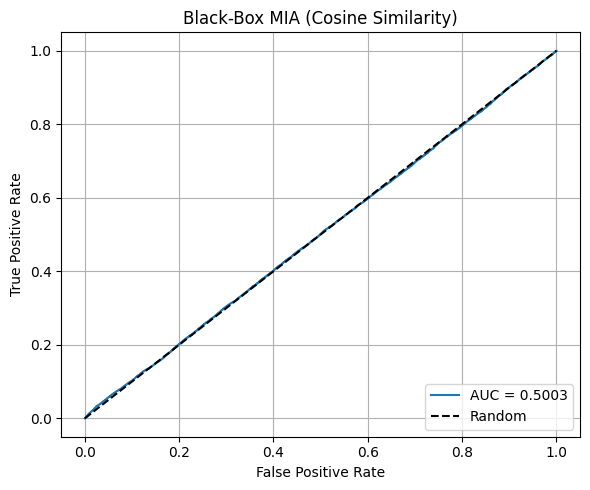


✅ Final AUC Score: 0.5003


In [2]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
import random

# ---------------- CONFIG ----------------
GENERATED_IMAGE_PATH = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba32_Eps1.0_celeba_eps1.0_0725-07:04:43/evaluation/synthesis.npz"
MEMBER_IMAGE_DIR     = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train"
NONMEMBER_IMAGE_DIR  = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test"
NUM_SAMPLES          = 30000  # per class
RANDOM_SEED          = 42
IMAGE_SIZE           = (32, 32)  # or (64, 64) if you're using CelebA-64
# ----------------------------------------

def load_generated_images(path):
    data = np.load(path)
    arr = data["data"]  # shape: (N, 3, 32, 32), float32 in [0,1]
    arr = arr * 2.0 - 1.0  # Normalize to [-1, 1]
    arr = np.transpose(arr, (0, 2, 3, 1))  # To (N, H, W, C) for consistency
    return arr

def load_real_images(folder, image_size):
    files = sorted(os.listdir(folder))
    #random.seed(seed)
    #sampled_files = random.sample(files, num_samples)
    
    images = []
    for file in tqdm(files, desc=f"Loading from {folder}"):
        img = Image.open(os.path.join(folder, file)).convert("RGB")
        img = img.resize(image_size)
        img_np = np.array(img).astype(np.float32) / 255.0  # [0,1]
        img_np = img_np * 2.0 - 1.0  # Normalize to [-1, 1]
        images.append(img_np)
    return np.array(images)

def flatten_images(images):
    return images.reshape(images.shape[0], -1)

def compute_similarity_over_chunks(generated, original, labels, chunk_size=20000):
    n_generated = generated.shape[0]
    max_sims = np.full(n_generated, -np.inf, dtype=np.float32)
    best_match_idx = np.full(n_generated, -1, dtype=np.int32)

    for i in range(0, original.shape[0], chunk_size):
        print(f"🔹 Processing chunk {i // chunk_size + 1}")
        chunk = original[i:i+chunk_size]
        sims = cosine_similarity(generated, chunk)  # shape: [num_gen, chunk_size]

        chunk_max_idx = np.argmax(sims, axis=1)
        chunk_max_vals = sims[np.arange(generated.shape[0]), chunk_max_idx]

        # Update max if this chunk has better matches
        update_mask = chunk_max_vals > max_sims
        max_sims[update_mask] = chunk_max_vals[update_mask]
        best_match_idx[update_mask] = i + chunk_max_idx[update_mask]  # global index

    matched_labels = labels[best_match_idx]
    return max_sims, matched_labels


# ---------------- Main Pipeline ----------------

# Step 1: Load data
print("🔹 Loading synthesized images...")
generated_images = load_generated_images(GENERATED_IMAGE_PATH)

print("🔹 Loading member images...")
member_images    = load_real_images(MEMBER_IMAGE_DIR, IMAGE_SIZE)

print("🔹 Loading non-member images...")
nonmember_images = load_real_images(NONMEMBER_IMAGE_DIR, IMAGE_SIZE)

# Combine original dataset
original_images = np.concatenate([member_images, nonmember_images], axis=0)
labels = np.array([1] * len(member_images) + [0] * len(nonmember_images))

# Step 2: Flatten
gen_flat = flatten_images(generated_images)
orig_flat = flatten_images(original_images)

# Step 3: Compute cosine similarity
print("🔹 Computing cosine similarity...")
mia_scores, mia_labels = compute_similarity_over_chunks(gen_flat, orig_flat, labels, chunk_size=20000)


# Step 4: Evaluate attack
fpr, tpr, _ = roc_curve(mia_labels, mia_scores)
roc_auc = auc(fpr, tpr)

# Step 5: Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Black-Box MIA (Cosine Similarity)')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

print(f"\n✅ Final AUC Score: {roc_auc:.4f}")


🔹 Loading synthesized images...
🔹 Computing cosine similarity...
🔹 Processing chunk 1
🔹 Processing chunk 2
🔹 Processing chunk 3
🔹 Processing chunk 4
🔹 Processing chunk 5
🔹 Processing chunk 6
🔹 Processing chunk 7
🔹 Processing chunk 8
🔹 Processing chunk 9
🔹 Processing chunk 10
🔹 Processing chunk 11


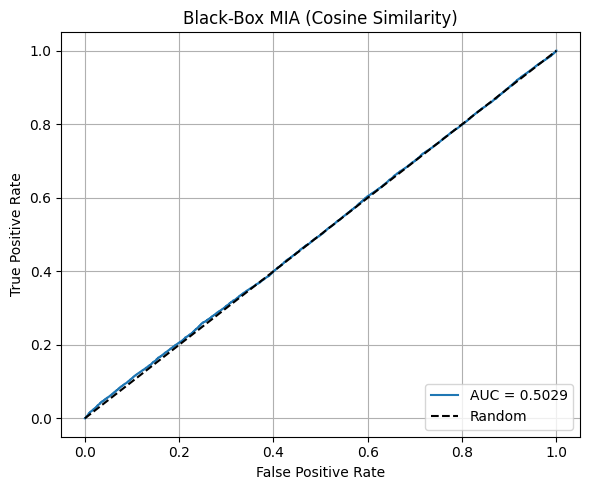


✅ Final AUC Score: 0.5029


In [4]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
import random

# ---------------- CONFIG ----------------
GENERATED_IMAGE_PATH = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba32_Eps5.0_celeba_eps5.0_0726-22:50:56/evaluation/synthesis.npz"
#MEMBER_IMAGE_DIR     = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train"
#NONMEMBER_IMAGE_DIR  = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test"
NUM_SAMPLES          = 30000  # per class
RANDOM_SEED          = 42
IMAGE_SIZE           = (32, 32)  # or (64, 64) if you're using CelebA-64
# ----------------------------------------

def load_generated_images(path):
    data = np.load(path)
    arr = data["data"]  # shape: (N, 3, 32, 32), float32 in [0,1]
    arr = arr * 2.0 - 1.0  # Normalize to [-1, 1]
    arr = np.transpose(arr, (0, 2, 3, 1))  # To (N, H, W, C) for consistency
    return arr

def load_real_images(folder, image_size):
    files = sorted(os.listdir(folder))
    #random.seed(seed)
    #sampled_files = random.sample(files, num_samples)
    
    images = []
    for file in tqdm(files, desc=f"Loading from {folder}"):
        img = Image.open(os.path.join(folder, file)).convert("RGB")
        img = img.resize(image_size)
        img_np = np.array(img).astype(np.float32) / 255.0  # [0,1]
        img_np = img_np * 2.0 - 1.0  # Normalize to [-1, 1]
        images.append(img_np)
    return np.array(images)

def flatten_images(images):
    return images.reshape(images.shape[0], -1)

def compute_similarity_over_chunks(generated, original, labels, chunk_size=20000):
    n_generated = generated.shape[0]
    max_sims = np.full(n_generated, -np.inf, dtype=np.float32)
    best_match_idx = np.full(n_generated, -1, dtype=np.int32)

    for i in range(0, original.shape[0], chunk_size):
        print(f"🔹 Processing chunk {i // chunk_size + 1}")
        chunk = original[i:i+chunk_size]
        sims = cosine_similarity(generated, chunk)  # shape: [num_gen, chunk_size]

        chunk_max_idx = np.argmax(sims, axis=1)
        chunk_max_vals = sims[np.arange(generated.shape[0]), chunk_max_idx]

        # Update max if this chunk has better matches
        update_mask = chunk_max_vals > max_sims
        max_sims[update_mask] = chunk_max_vals[update_mask]
        best_match_idx[update_mask] = i + chunk_max_idx[update_mask]  # global index

    matched_labels = labels[best_match_idx]
    return max_sims, matched_labels


# ---------------- Main Pipeline ----------------

# Step 1: Load data
print("🔹 Loading synthesized images...")
generated_images = load_generated_images(GENERATED_IMAGE_PATH)

#print("🔹 Loading member images...")
#member_images    = load_real_images(MEMBER_IMAGE_DIR, IMAGE_SIZE)

#print("🔹 Loading non-member images...")
#nonmember_images = load_real_images(NONMEMBER_IMAGE_DIR, IMAGE_SIZE)

# Combine original dataset
#original_images = np.concatenate([member_images, nonmember_images], axis=0)
#labels = np.array([1] * len(member_images) + [0] * len(nonmember_images))

# Step 2: Flatten
gen_flat = flatten_images(generated_images)
orig_flat = flatten_images(original_images)

# Step 3: Compute cosine similarity
print("🔹 Computing cosine similarity...")
mia_scores, mia_labels = compute_similarity_over_chunks(gen_flat, orig_flat, labels, chunk_size=20000)


# Step 4: Evaluate attack
fpr, tpr, _ = roc_curve(mia_labels, mia_scores)
roc_auc = auc(fpr, tpr)

# Step 5: Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Black-Box MIA (Cosine Similarity)')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

print(f"\n✅ Final AUC Score: {roc_auc:.4f}")


🔹 Loading synthesized images...
🔹 Computing cosine similarity...
🔹 Processing chunk 1
🔹 Processing chunk 2
🔹 Processing chunk 3
🔹 Processing chunk 4
🔹 Processing chunk 5
🔹 Processing chunk 6
🔹 Processing chunk 7
🔹 Processing chunk 8
🔹 Processing chunk 9
🔹 Processing chunk 10
🔹 Processing chunk 11


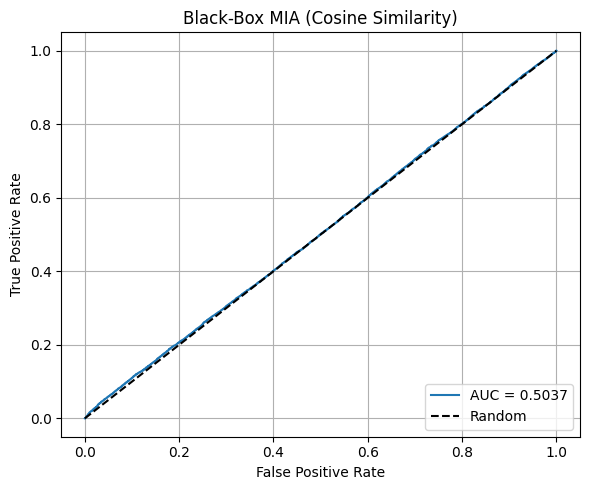


✅ Final AUC Score: 0.5037


In [5]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
import random

# ---------------- CONFIG ----------------
GENERATED_IMAGE_PATH = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba32_Eps10.0_celeba_eps10.0_0727-19:01:27/evaluation/synthesis.npz"
#MEMBER_IMAGE_DIR     = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train"
#NONMEMBER_IMAGE_DIR  = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test"
NUM_SAMPLES          = 30000  # per class
RANDOM_SEED          = 42
IMAGE_SIZE           = (32, 32)  # or (64, 64) if you're using CelebA-64
# ----------------------------------------

def load_generated_images(path):
    data = np.load(path)
    arr = data["data"]  # shape: (N, 3, 32, 32), float32 in [0,1]
    arr = arr * 2.0 - 1.0  # Normalize to [-1, 1]
    arr = np.transpose(arr, (0, 2, 3, 1))  # To (N, H, W, C) for consistency
    return arr

def load_real_images(folder, image_size):
    files = sorted(os.listdir(folder))
    #random.seed(seed)
    #sampled_files = random.sample(files, num_samples)
    
    images = []
    for file in tqdm(files, desc=f"Loading from {folder}"):
        img = Image.open(os.path.join(folder, file)).convert("RGB")
        img = img.resize(image_size)
        img_np = np.array(img).astype(np.float32) / 255.0  # [0,1]
        img_np = img_np * 2.0 - 1.0  # Normalize to [-1, 1]
        images.append(img_np)
    return np.array(images)

def flatten_images(images):
    return images.reshape(images.shape[0], -1)

def compute_similarity_over_chunks(generated, original, labels, chunk_size=20000):
    n_generated = generated.shape[0]
    max_sims = np.full(n_generated, -np.inf, dtype=np.float32)
    best_match_idx = np.full(n_generated, -1, dtype=np.int32)

    for i in range(0, original.shape[0], chunk_size):
        print(f"🔹 Processing chunk {i // chunk_size + 1}")
        chunk = original[i:i+chunk_size]
        sims = cosine_similarity(generated, chunk)  # shape: [num_gen, chunk_size]

        chunk_max_idx = np.argmax(sims, axis=1)
        chunk_max_vals = sims[np.arange(generated.shape[0]), chunk_max_idx]

        # Update max if this chunk has better matches
        update_mask = chunk_max_vals > max_sims
        max_sims[update_mask] = chunk_max_vals[update_mask]
        best_match_idx[update_mask] = i + chunk_max_idx[update_mask]  # global index

    matched_labels = labels[best_match_idx]
    return max_sims, matched_labels


# ---------------- Main Pipeline ----------------

# Step 1: Load data
print("🔹 Loading synthesized images...")
generated_images = load_generated_images(GENERATED_IMAGE_PATH)

#print("🔹 Loading member images...")
#member_images    = load_real_images(MEMBER_IMAGE_DIR, IMAGE_SIZE)

#print("🔹 Loading non-member images...")
#nonmember_images = load_real_images(NONMEMBER_IMAGE_DIR, IMAGE_SIZE)

# Combine original dataset
#original_images = np.concatenate([member_images, nonmember_images], axis=0)
#labels = np.array([1] * len(member_images) + [0] * len(nonmember_images))

# Step 2: Flatten
gen_flat = flatten_images(generated_images)
orig_flat = flatten_images(original_images)

# Step 3: Compute cosine similarity
print("🔹 Computing cosine similarity...")
mia_scores, mia_labels = compute_similarity_over_chunks(gen_flat, orig_flat, labels, chunk_size=20000)


# Step 4: Evaluate attack
fpr, tpr, _ = roc_curve(mia_labels, mia_scores)
roc_auc = auc(fpr, tpr)

# Step 5: Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Black-Box MIA (Cosine Similarity)')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

print(f"\n✅ Final AUC Score: {roc_auc:.4f}")


🔹 Loading synthesized images...
🔹 Loading member images...


Loading from /rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train: 100%|██████████| 162079/162079 [06:24<00:00, 421.33it/s]


🔹 Loading non-member images...


Loading from /rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test: 100%|██████████| 40520/40520 [01:44<00:00, 388.19it/s]


🔹 Computing cosine similarity...
🔹 Processing chunk 1
🔹 Processing chunk 2
🔹 Processing chunk 3
🔹 Processing chunk 4
🔹 Processing chunk 5
🔹 Processing chunk 6
🔹 Processing chunk 7
🔹 Processing chunk 8
🔹 Processing chunk 9
🔹 Processing chunk 10
🔹 Processing chunk 11


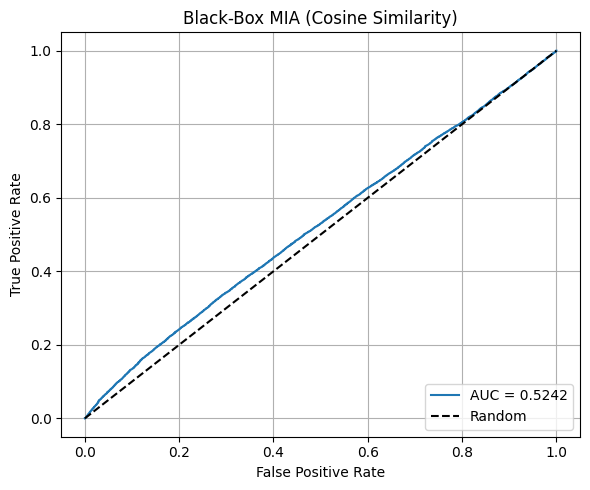


✅ Final AUC Score: 0.5242


In [3]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
import random

# ---------------- CONFIG ----------------
GENERATED_IMAGE_PATH = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba64_Eps1.0_celeba64_eps1.0_0803-05:32:50/evaluation/synthesis.npz"
MEMBER_IMAGE_DIR     = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train"
NONMEMBER_IMAGE_DIR  = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test"
NUM_SAMPLES          = 30000  # per class
RANDOM_SEED          = 42
IMAGE_SIZE           = (64, 64)  # or (64, 64) if you're using CelebA-64
# ----------------------------------------

def load_generated_images(path):
    data = np.load(path)
    arr = data["data"]  # shape: (N, 3, 32, 32), float32 in [0,1]
    arr = arr * 2.0 - 1.0  # Normalize to [-1, 1]
    arr = np.transpose(arr, (0, 2, 3, 1))  # To (N, H, W, C) for consistency
    return arr

def load_real_images(folder, image_size):
    files = sorted(os.listdir(folder))
    #random.seed(seed)
    #sampled_files = random.sample(files, num_samples)
    
    images = []
    for file in tqdm(files, desc=f"Loading from {folder}"):
        img = Image.open(os.path.join(folder, file)).convert("RGB")
        img = img.resize(image_size)
        img_np = np.array(img).astype(np.float32) / 255.0  # [0,1]
        img_np = img_np * 2.0 - 1.0  # Normalize to [-1, 1]
        images.append(img_np)
    return np.array(images)

def flatten_images(images):
    return images.reshape(images.shape[0], -1)

def compute_similarity_over_chunks(generated, original, labels, chunk_size=20000):
    n_generated = generated.shape[0]
    max_sims = np.full(n_generated, -np.inf, dtype=np.float32)
    best_match_idx = np.full(n_generated, -1, dtype=np.int32)

    for i in range(0, original.shape[0], chunk_size):
        print(f"🔹 Processing chunk {i // chunk_size + 1}")
        chunk = original[i:i+chunk_size]
        sims = cosine_similarity(generated, chunk)  # shape: [num_gen, chunk_size]

        chunk_max_idx = np.argmax(sims, axis=1)
        chunk_max_vals = sims[np.arange(generated.shape[0]), chunk_max_idx]

        # Update max if this chunk has better matches
        update_mask = chunk_max_vals > max_sims
        max_sims[update_mask] = chunk_max_vals[update_mask]
        best_match_idx[update_mask] = i + chunk_max_idx[update_mask]  # global index

    matched_labels = labels[best_match_idx]
    return max_sims, matched_labels


# ---------------- Main Pipeline ----------------

# Step 1: Load data
print("🔹 Loading synthesized images...")
generated_images = load_generated_images(GENERATED_IMAGE_PATH)

print("🔹 Loading member images...")
member_images    = load_real_images(MEMBER_IMAGE_DIR, IMAGE_SIZE)

print("🔹 Loading non-member images...")
nonmember_images = load_real_images(NONMEMBER_IMAGE_DIR, IMAGE_SIZE)

# Combine original dataset
original_images = np.concatenate([member_images, nonmember_images], axis=0)
labels = np.array([1] * len(member_images) + [0] * len(nonmember_images))

# Step 2: Flatten
gen_flat = flatten_images(generated_images)
orig_flat = flatten_images(original_images)

# Step 3: Compute cosine similarity
print("🔹 Computing cosine similarity...")
mia_scores, mia_labels = compute_similarity_over_chunks(gen_flat, orig_flat, labels, chunk_size=20000)


# Step 4: Evaluate attack
fpr, tpr, _ = roc_curve(mia_labels, mia_scores)
roc_auc = auc(fpr, tpr)

# Step 5: Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Black-Box MIA (Cosine Similarity)')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

print(f"\n✅ Final AUC Score: {roc_auc:.4f}")


🔹 Loading synthesized images...
🔹 Loading member images...


Loading from /rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train: 100%|██████████| 162079/162079 [06:26<00:00, 419.75it/s]


🔹 Loading non-member images...


Loading from /rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test: 100%|██████████| 40520/40520 [01:44<00:00, 389.08it/s]


🔹 Computing cosine similarity...
🔹 Processing chunk 1
🔹 Processing chunk 2
🔹 Processing chunk 3
🔹 Processing chunk 4
🔹 Processing chunk 5
🔹 Processing chunk 6
🔹 Processing chunk 7
🔹 Processing chunk 8
🔹 Processing chunk 9
🔹 Processing chunk 10
🔹 Processing chunk 11


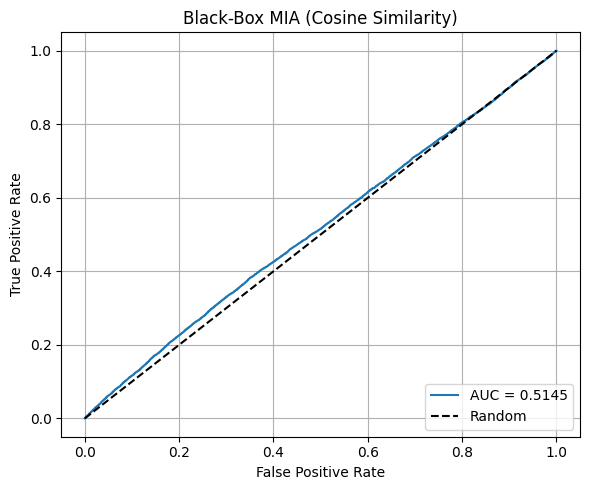


✅ Final AUC Score: 0.5145


In [2]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
import random

# ---------------- CONFIG ----------------
GENERATED_IMAGE_PATH = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba64_Eps5.0_celeba64_eps5.0_0727-04:48:09/evaluation/synthesis.npz"
MEMBER_IMAGE_DIR     = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train"
NONMEMBER_IMAGE_DIR  = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test"
NUM_SAMPLES          = 30000  # per class
RANDOM_SEED          = 42
IMAGE_SIZE           = (64, 64)  # or (64, 64) if you're using CelebA-64
# ----------------------------------------

def load_generated_images(path):
    data = np.load(path)
    arr = data["data"]  # shape: (N, 3, 32, 32), float32 in [0,1]
    arr = arr * 2.0 - 1.0  # Normalize to [-1, 1]
    arr = np.transpose(arr, (0, 2, 3, 1))  # To (N, H, W, C) for consistency
    return arr

def load_real_images(folder, image_size):
    files = sorted(os.listdir(folder))
    #random.seed(seed)
    #sampled_files = random.sample(files, num_samples)
    
    images = []
    for file in tqdm(files, desc=f"Loading from {folder}"):
        img = Image.open(os.path.join(folder, file)).convert("RGB")
        img = img.resize(image_size)
        img_np = np.array(img).astype(np.float32) / 255.0  # [0,1]
        img_np = img_np * 2.0 - 1.0  # Normalize to [-1, 1]
        images.append(img_np)
    return np.array(images)

def flatten_images(images):
    return images.reshape(images.shape[0], -1)

def compute_similarity_over_chunks(generated, original, labels, chunk_size=20000):
    n_generated = generated.shape[0]
    max_sims = np.full(n_generated, -np.inf, dtype=np.float32)
    best_match_idx = np.full(n_generated, -1, dtype=np.int32)

    for i in range(0, original.shape[0], chunk_size):
        print(f"🔹 Processing chunk {i // chunk_size + 1}")
        chunk = original[i:i+chunk_size]
        sims = cosine_similarity(generated, chunk)  # shape: [num_gen, chunk_size]

        chunk_max_idx = np.argmax(sims, axis=1)
        chunk_max_vals = sims[np.arange(generated.shape[0]), chunk_max_idx]

        # Update max if this chunk has better matches
        update_mask = chunk_max_vals > max_sims
        max_sims[update_mask] = chunk_max_vals[update_mask]
        best_match_idx[update_mask] = i + chunk_max_idx[update_mask]  # global index

    matched_labels = labels[best_match_idx]
    return max_sims, matched_labels


# ---------------- Main Pipeline ----------------

# Step 1: Load data
print("🔹 Loading synthesized images...")
generated_images = load_generated_images(GENERATED_IMAGE_PATH)

print("🔹 Loading member images...")
member_images    = load_real_images(MEMBER_IMAGE_DIR, IMAGE_SIZE)

print("🔹 Loading non-member images...")
nonmember_images = load_real_images(NONMEMBER_IMAGE_DIR, IMAGE_SIZE)

# Combine original dataset
original_images = np.concatenate([member_images, nonmember_images], axis=0)
labels = np.array([1] * len(member_images) + [0] * len(nonmember_images))

# Step 2: Flatten
gen_flat = flatten_images(generated_images)
orig_flat = flatten_images(original_images)

# Step 3: Compute cosine similarity
print("🔹 Computing cosine similarity...")
mia_scores, mia_labels = compute_similarity_over_chunks(gen_flat, orig_flat, labels, chunk_size=20000)


# Step 4: Evaluate attack
fpr, tpr, _ = roc_curve(mia_labels, mia_scores)
roc_auc = auc(fpr, tpr)

# Step 5: Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Black-Box MIA (Cosine Similarity)')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

print(f"\n✅ Final AUC Score: {roc_auc:.4f}")


🔹 Loading synthesized images...
🔹 Loading member images...


Loading from /rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train: 100%|██████████| 162079/162079 [06:50<00:00, 394.53it/s]


🔹 Loading non-member images...


Loading from /rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test: 100%|██████████| 40520/40520 [01:44<00:00, 389.52it/s]


🔹 Computing cosine similarity...
🔹 Processing chunk 1
🔹 Processing chunk 2
🔹 Processing chunk 3
🔹 Processing chunk 4
🔹 Processing chunk 5
🔹 Processing chunk 6
🔹 Processing chunk 7
🔹 Processing chunk 8
🔹 Processing chunk 9
🔹 Processing chunk 10
🔹 Processing chunk 11


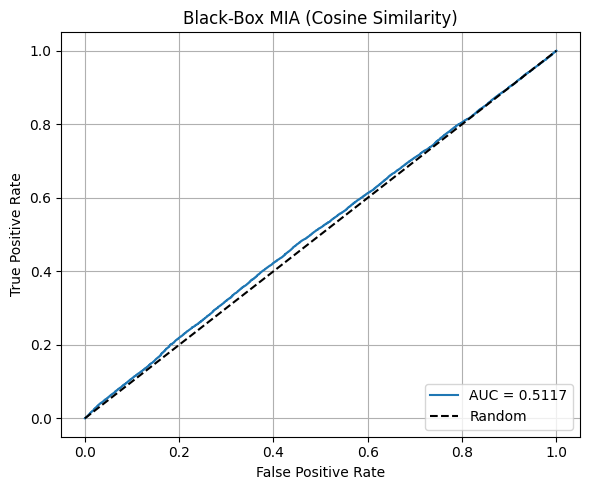


✅ Final AUC Score: 0.5117


In [2]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
import random

# ---------------- CONFIG ----------------
GENERATED_IMAGE_PATH = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba64_Eps10.0_celeba64_eps10.0_0728-09:55:24/evaluation/synthesis.npz"
MEMBER_IMAGE_DIR     = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train"
NONMEMBER_IMAGE_DIR  = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test"
NUM_SAMPLES          = 30000  # per class
RANDOM_SEED          = 42
IMAGE_SIZE           = (64, 64)  # or (64, 64) if you're using CelebA-64
# ----------------------------------------

def load_generated_images(path):
    data = np.load(path)
    arr = data["data"]  # shape: (N, 3, 32, 32), float32 in [0,1]
    arr = arr * 2.0 - 1.0  # Normalize to [-1, 1]
    arr = np.transpose(arr, (0, 2, 3, 1))  # To (N, H, W, C) for consistency
    return arr

def load_real_images(folder, image_size):
    files = sorted(os.listdir(folder))
    #random.seed(seed)
    #sampled_files = random.sample(files, num_samples)
    
    images = []
    for file in tqdm(files, desc=f"Loading from {folder}"):
        img = Image.open(os.path.join(folder, file)).convert("RGB")
        img = img.resize(image_size)
        img_np = np.array(img).astype(np.float32) / 255.0  # [0,1]
        img_np = img_np * 2.0 - 1.0  # Normalize to [-1, 1]
        images.append(img_np)
    return np.array(images)

def flatten_images(images):
    return images.reshape(images.shape[0], -1)

def compute_similarity_over_chunks(generated, original, labels, chunk_size=20000):
    n_generated = generated.shape[0]
    max_sims = np.full(n_generated, -np.inf, dtype=np.float32)
    best_match_idx = np.full(n_generated, -1, dtype=np.int32)

    for i in range(0, original.shape[0], chunk_size):
        print(f"🔹 Processing chunk {i // chunk_size + 1}")
        chunk = original[i:i+chunk_size]
        sims = cosine_similarity(generated, chunk)  # shape: [num_gen, chunk_size]

        chunk_max_idx = np.argmax(sims, axis=1)
        chunk_max_vals = sims[np.arange(generated.shape[0]), chunk_max_idx]

        # Update max if this chunk has better matches
        update_mask = chunk_max_vals > max_sims
        max_sims[update_mask] = chunk_max_vals[update_mask]
        best_match_idx[update_mask] = i + chunk_max_idx[update_mask]  # global index

    matched_labels = labels[best_match_idx]
    return max_sims, matched_labels


# ---------------- Main Pipeline ----------------

# Step 1: Load data
print("🔹 Loading synthesized images...")
generated_images = load_generated_images(GENERATED_IMAGE_PATH)

print("🔹 Loading member images...")
member_images    = load_real_images(MEMBER_IMAGE_DIR, IMAGE_SIZE)

print("🔹 Loading non-member images...")
nonmember_images = load_real_images(NONMEMBER_IMAGE_DIR, IMAGE_SIZE)

# Combine original dataset
original_images = np.concatenate([member_images, nonmember_images], axis=0)
labels = np.array([1] * len(member_images) + [0] * len(nonmember_images))

# Step 2: Flatten
gen_flat = flatten_images(generated_images)
orig_flat = flatten_images(original_images)

# Step 3: Compute cosine similarity
print("🔹 Computing cosine similarity...")
mia_scores, mia_labels = compute_similarity_over_chunks(gen_flat, orig_flat, labels, chunk_size=20000)


# Step 4: Evaluate attack
fpr, tpr, _ = roc_curve(mia_labels, mia_scores)
roc_auc = auc(fpr, tpr)

# Step 5: Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Black-Box MIA (Cosine Similarity)')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

print(f"\n✅ Final AUC Score: {roc_auc:.4f}")


## Black Box attack on Celeba 32 & 64 using Euclidean distance(Knn) of Raw pixel

🔹 Loading member images...


Loading from /rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train: 100%|██████████| 10000/10000 [01:14<00:00, 135.03it/s]


🔹 Loading non-member images...


Loading from /rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test: 100%|██████████| 10000/10000 [00:36<00:00, 272.52it/s]



🔹 Loading synthesized images for ε=1...
🔹 Computing k-NN distances for ε=1...
🔹 Processing chunk 1

🔹 Loading synthesized images for ε=5...
🔹 Computing k-NN distances for ε=5...
🔹 Processing chunk 1

🔹 Loading synthesized images for ε=10...
🔹 Computing k-NN distances for ε=10...
🔹 Processing chunk 1


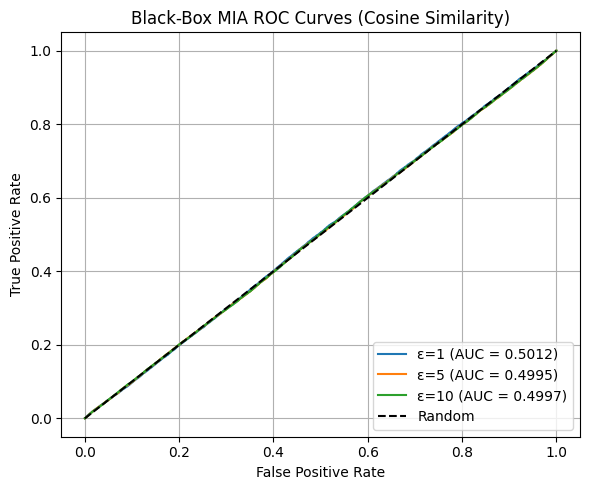

In [8]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
#from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc
import random

# ---------------- CONFIG ----------------
#GENERATED_IMAGE_PATH = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba32_Eps1.0_celeba_eps1.0_0725-07:04:43/evaluation/synthesis.npz"
MEMBER_IMAGE_DIR     = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train"
NONMEMBER_IMAGE_DIR  = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test"
NUM_SAMPLES          = 10000  # per class
RANDOM_SEED          = 42
IMAGE_SIZE           = (32, 32)  # or (64, 64) if you're using CelebA-64
# ----------------------------------------


# Add at the top
GENERATED_IMAGE_PATHS = {
    "ε=1": "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba32_Eps1.0_celeba_eps1.0_0725-07:04:43/evaluation/synthesis.npz",
    "ε=5": "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba32_Eps5.0_celeba_eps5.0_0726-22:50:56/evaluation/synthesis.npz",
    "ε=10": "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba32_Eps10.0_celeba_eps10.0_0727-19:01:27/evaluation/synthesis.npz"
}

def load_generated_images(path):
    data = np.load(path)
    arr = data["data"]  # shape: (N, 3, 32, 32), float32 in [0,1]
    arr = arr * 2.0 - 1.0  # Normalize to [-1, 1]
    arr = np.transpose(arr, (0, 2, 3, 1))  # To (N, H, W, C) for consistency
    return arr

def load_real_images(folder, num_samples, image_size, seed=42):
    files = sorted(os.listdir(folder))
    random.seed(seed)
    sampled_files = random.sample(files, num_samples)
    
    images = []
    for file in tqdm(sampled_files, desc=f"Loading from {folder}"):
        img = Image.open(os.path.join(folder, file)).convert("RGB")
        #img = img.resize(image_size)
        img_np = np.array(img).astype(np.float32) / 255.0  # [0,1]
        img_np = img_np * 2.0 - 1.0  # Normalize to [-1, 1]
        images.append(img_np)
    return np.array(images)

def flatten_images(images):
    return images.reshape(images.shape[0], -1)

def compute_knn_scores_over_chunks(generated, original, labels, chunk_size=20000):
    n_generated = generated.shape[0]
    min_dists = np.full(n_generated, np.inf, dtype=np.float32)
    best_match_idx = np.full(n_generated, -1, dtype=np.int32)

    for i in range(0, original.shape[0], chunk_size):
        print(f"🔹 Processing chunk {i // chunk_size + 1}")
        chunk = original[i:i+chunk_size]
        dists = euclidean_distances(generated, chunk)  # shape: [num_gen, chunk_size]

        chunk_min_idx = np.argmin(dists, axis=1)
        chunk_min_vals = dists[np.arange(generated.shape[0]), chunk_min_idx]

        # Update min if this chunk has better matches
        update_mask = chunk_min_vals < min_dists
        min_dists[update_mask] = chunk_min_vals[update_mask]
        best_match_idx[update_mask] = i + chunk_min_idx[update_mask]  # global index

    matched_labels = labels[best_match_idx]
    return -min_dists, matched_labels  # negative for ROC curve (higher = more member-like)

def evaluate_attack_knn(generated_path, label, orig_flat, labels):
    print(f"\n🔹 Loading synthesized images for {label}...")
    generated_images = load_generated_images(generated_path)
    gen_flat = flatten_images(generated_images)
    
    print(f"🔹 Computing k-NN distances for {label}...")
    mia_scores, mia_labels = compute_knn_scores_over_chunks(gen_flat, orig_flat, labels, chunk_size=20000)
    
    fpr, tpr, _ = roc_curve(mia_labels, mia_scores)
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc


# Load member/non-member data only once
print("🔹 Loading member images...")
member_images = load_real_images(MEMBER_IMAGE_DIR, NUM_SAMPLES, IMAGE_SIZE, seed=RANDOM_SEED)

print("🔹 Loading non-member images...")
nonmember_images = load_real_images(NONMEMBER_IMAGE_DIR, NUM_SAMPLES, IMAGE_SIZE, seed=RANDOM_SEED)

original_images = np.concatenate([member_images, nonmember_images], axis=0)
labels = np.array([1] * len(member_images) + [0] * len(nonmember_images))
orig_flat = flatten_images(original_images)

# Evaluate each generated dataset
plt.figure(figsize=(6, 5))
for label, gen_path in GENERATED_IMAGE_PATHS.items():
    fpr, tpr, roc_auc = evaluate_attack_knn(gen_path, label, orig_flat, labels)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.4f})')

# Finalize plot
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Black-Box MIA ROC Curves (Knn - Distance)')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


🔹 Loading member images...


Loading from /rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train: 100%|██████████| 10000/10000 [05:07<00:00, 32.54it/s]


🔹 Loading non-member images...


Loading from /rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test: 100%|██████████| 10000/10000 [03:11<00:00, 52.23it/s]



🔹 Loading synthesized images for ε=1...
🔹 Computing k-NN distances for ε=1...
🔹 Processing chunk 1

🔹 Loading synthesized images for ε=5...
🔹 Computing k-NN distances for ε=5...
🔹 Processing chunk 1

🔹 Loading synthesized images for ε=10...
🔹 Computing k-NN distances for ε=10...
🔹 Processing chunk 1


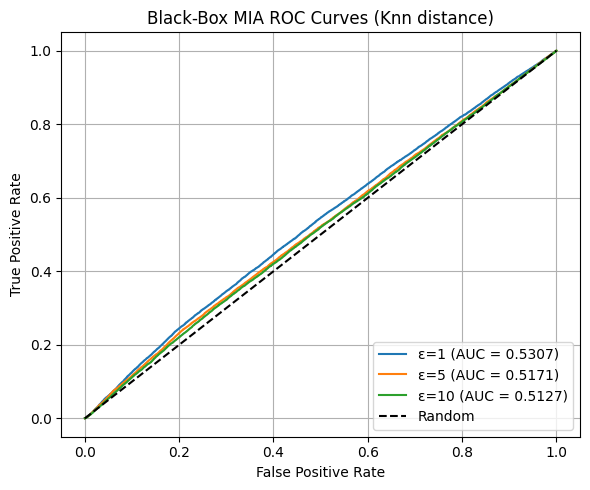

In [9]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
#from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc
import random

# ---------------- CONFIG ----------------
#GENERATED_IMAGE_PATH = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba32_Eps1.0_celeba_eps1.0_0725-07:04:43/evaluation/synthesis.npz"
MEMBER_IMAGE_DIR     = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train"
NONMEMBER_IMAGE_DIR  = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test"
NUM_SAMPLES          = 10000  # per class
RANDOM_SEED          = 42
IMAGE_SIZE           = (64, 64)  # or (64, 64) if you're using CelebA-64
# ----------------------------------------


# Add at the top
GENERATED_IMAGE_PATHS = {
    "ε=1": "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba64_Eps1.0_celeba64_eps1.0_0803-05:32:50/evaluation/synthesis.npz",
    "ε=5": "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba64_Eps5.0_celeba64_eps5.0_0727-04:48:09/evaluation/synthesis.npz",
    "ε=10": "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba64_Eps10.0_celeba64_eps10.0_0728-09:55:24/evaluation/synthesis.npz"
}

def load_generated_images(path):
    data = np.load(path)
    arr = data["data"]  # shape: (N, 3, 32, 32), float32 in [0,1]
    arr = arr * 2.0 - 1.0  # Normalize to [-1, 1]
    arr = np.transpose(arr, (0, 2, 3, 1))  # To (N, H, W, C) for consistency
    return arr

def load_real_images(folder, num_samples, image_size, seed=42):
    files = sorted(os.listdir(folder))
    random.seed(seed)
    sampled_files = random.sample(files, num_samples)
    
    images = []
    for file in tqdm(sampled_files, desc=f"Loading from {folder}"):
        img = Image.open(os.path.join(folder, file)).convert("RGB")
        #img = img.resize(image_size)
        img_np = np.array(img).astype(np.float32) / 255.0  # [0,1]
        img_np = img_np * 2.0 - 1.0  # Normalize to [-1, 1]
        images.append(img_np)
    return np.array(images)

def flatten_images(images):
    return images.reshape(images.shape[0], -1)

def compute_knn_scores_over_chunks(generated, original, labels, chunk_size=20000):
    n_generated = generated.shape[0]
    min_dists = np.full(n_generated, np.inf, dtype=np.float32)
    best_match_idx = np.full(n_generated, -1, dtype=np.int32)

    for i in range(0, original.shape[0], chunk_size):
        print(f"🔹 Processing chunk {i // chunk_size + 1}")
        chunk = original[i:i+chunk_size]
        dists = euclidean_distances(generated, chunk)  # shape: [num_gen, chunk_size]

        chunk_min_idx = np.argmin(dists, axis=1)
        chunk_min_vals = dists[np.arange(generated.shape[0]), chunk_min_idx]

        # Update min if this chunk has better matches
        update_mask = chunk_min_vals < min_dists
        min_dists[update_mask] = chunk_min_vals[update_mask]
        best_match_idx[update_mask] = i + chunk_min_idx[update_mask]  # global index

    matched_labels = labels[best_match_idx]
    return -min_dists, matched_labels  # negative for ROC curve (higher = more member-like)

def evaluate_attack_knn(generated_path, label, orig_flat, labels):
    print(f"\n🔹 Loading synthesized images for {label}...")
    generated_images = load_generated_images(generated_path)
    gen_flat = flatten_images(generated_images)
    
    print(f"🔹 Computing k-NN distances for {label}...")
    mia_scores, mia_labels = compute_knn_scores_over_chunks(gen_flat, orig_flat, labels, chunk_size=20000)
    
    fpr, tpr, _ = roc_curve(mia_labels, mia_scores)
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc


# Load member/non-member data only once
print("🔹 Loading member images...")
member_images = load_real_images(MEMBER_IMAGE_DIR, NUM_SAMPLES, IMAGE_SIZE, seed=RANDOM_SEED)

print("🔹 Loading non-member images...")
nonmember_images = load_real_images(NONMEMBER_IMAGE_DIR, NUM_SAMPLES, IMAGE_SIZE, seed=RANDOM_SEED)

original_images = np.concatenate([member_images, nonmember_images], axis=0)
labels = np.array([1] * len(member_images) + [0] * len(nonmember_images))
orig_flat = flatten_images(original_images)

# Evaluate each generated dataset
plt.figure(figsize=(6, 5))
for label, gen_path in GENERATED_IMAGE_PATHS.items():
    fpr, tpr, roc_auc = evaluate_attack_knn(gen_path, label, orig_flat, labels)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.4f})')

# Finalize plot
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Black-Box MIA ROC Curves (Knn distance)')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


## code to retrieve the synthesis.npz

In [ ]:
# used this code to retrieve the synthesis.npz file to .png file and then proceeded the further testing
import numpy as np
from PIL import Image
import os

# Load NPZ
npz_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba64_Eps10.0_celeba64_eps10.0_0809-20:46:35/evaluation/synthesis.npz"
data = np.load(npz_path)

images = data["data"]  # shape: (N, C, H, W)
labels = data["labels"]

# Create output folder
out_dir = "Generated Images/samples_celeba64_eps10"
os.makedirs(out_dir, exist_ok=True)

# Save each image
for idx, img_tensor in enumerate(images):
    # Convert from (C,H,W) to (H,W,C) and [0,1] to [0,255]
    img_array = (np.transpose(img_tensor, (1, 2, 0)) * 255).astype(np.uint8)
    img = Image.fromarray(img_array)
    img.save(os.path.join(out_dir, f"{idx:06d}.png"))  # PNG to avoid extra compression


## Celeba 32 (Seed 1234) - Black Box Attack on DP-Promise using CLIP & LPIP 

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps1')

# Limit number of images
max_members = 500
max_nonmembers = 500
max_generated = 1000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_all_mem_features_celeba32_eps1_seed1234.npy", all_mem_features)
np.save(f"New_all_nonmem_features_celeba32_eps1_seed1234.npy", all_nonmem_features)
print(f"Saved features as New_all_mem_features_celeba32_eps1_seed1234.npy and New_all_nonmem_features_celeba32_eps1_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 500 member images
Using 500 non-member images
Using 1000 generated images
Extracting CLIP features for members...


100%|██████████| 500/500 [00:11<00:00, 43.61it/s]


Extracting CLIP features for non-members...


100%|██████████| 500/500 [00:10<00:00, 48.02it/s]


Extracting CLIP features for generated images...


100%|██████████| 1000/1000 [00:19<00:00, 50.38it/s]


Computing features for generated images...


100%|██████████| 1000/1000 [1:08:16<00:00,  4.10s/it]


Saved features as New_all_mem_features_celeba32_eps1_seed1234.npy and New_all_nonmem_features_celeba32_eps1_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.6271


In [3]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps1')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba32_eps1_seed1234.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba32_eps1_seed1234.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba32_eps1_seed1234.npy and New_10000_all_nonmem_features_celeba32_eps1_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 142.22it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:02<00:00, 42.99it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [02:22<00:00, 70.40it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [2:18:13<00:00,  1.21it/s] 

Saved features as New_10000_all_mem_features_celeba32_eps1_seed1234.npy and New_10000_all_nonmem_features_celeba32_eps1_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.7752


In [4]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps1')

# Limit number of images
max_members = 200
max_nonmembers = 200
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba32_200_eps1_seed1234.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba32_200_eps1_seed1234.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba32_200_eps1_seed1234.npy and New_10000_all_nonmem_features_celeba32_200_eps1_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 200 member images
Using 200 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 200/200 [00:01<00:00, 155.58it/s]


Extracting CLIP features for non-members...


100%|██████████| 200/200 [00:01<00:00, 150.64it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [01:53<00:00, 87.98it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [4:30:54<00:00,  1.63s/it] 

Saved features as New_10000_all_mem_features_celeba32_200_eps1_seed1234.npy and New_10000_all_nonmem_features_celeba32_200_eps1_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.7185


In [2]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps5')

# Limit number of images
max_members = 500
max_nonmembers = 500
max_generated = 1000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_all_mem_features_celeba32_eps5_seed1234.npy", all_mem_features)
np.save(f"New_all_nonmem_features_celeba32_eps5_seed1234.npy", all_nonmem_features)
print(f"Saved features as New_all_mem_features_celeba32_eps5_seed1234.npy and New_all_nonmem_features_celeba32_eps5_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 500 member images
Using 500 non-member images
Using 1000 generated images
Extracting CLIP features for members...


100%|██████████| 500/500 [00:11<00:00, 43.13it/s]


Extracting CLIP features for non-members...


100%|██████████| 500/500 [00:10<00:00, 48.02it/s]


Extracting CLIP features for generated images...


100%|██████████| 1000/1000 [00:19<00:00, 52.08it/s]


Computing features for generated images...


100%|██████████| 1000/1000 [1:08:26<00:00,  4.11s/it]


Saved features as New_all_mem_features_celeba32_eps5_seed1234.npy and New_all_nonmem_features_celeba32_eps5_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.5979


In [3]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps5')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba32_eps5_seed1234.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba32_eps5_seed1234.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba32_eps5_seed1234.npy and New_10000_all_nonmem_features_celeba32_eps5_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 112.16it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:01<00:00, 86.84it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [02:13<00:00, 74.91it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [2:17:30<00:00,  1.21it/s] 

Saved features as New_10000_all_mem_features_celeba32_eps5_seed1234.npy and New_10000_all_nonmem_features_celeba32_eps5_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.7725


In [4]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps5')

# Limit number of images
max_members = 200
max_nonmembers = 200
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba32_200_eps5_seed1234.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba32_200_eps5_seed1234.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba32_200_eps5_seed1234.npy and New_10000_all_nonmem_features_celeba32_200_eps5_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 200 member images
Using 200 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 200/200 [00:03<00:00, 66.33it/s] 


Extracting CLIP features for non-members...


100%|██████████| 200/200 [00:04<00:00, 42.73it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [01:59<00:00, 83.98it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [4:32:52<00:00,  1.64s/it] 

Saved features as New_10000_all_mem_features_celeba32_200_eps5_seed1234.npy and New_10000_all_nonmem_features_celeba32_200_eps5_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.6978


In [2]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps10')

# Limit number of images
max_members = 500
max_nonmembers = 500
max_generated = 1000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_all_mem_features_celeba32_eps10_seed1234.npy", all_mem_features)
np.save(f"New_all_nonmem_features_celeba32_eps10_seed1234.npy", all_nonmem_features)
print(f"Saved features as New_all_mem_features_celeba32_eps10_seed1234.npy and New_all_nonmem_features_celeba32_eps10_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 500 member images
Using 500 non-member images
Using 1000 generated images
Extracting CLIP features for members...


100%|██████████| 500/500 [00:11<00:00, 44.29it/s]


Extracting CLIP features for non-members...


100%|██████████| 500/500 [00:10<00:00, 48.02it/s]


Extracting CLIP features for generated images...


100%|██████████| 1000/1000 [00:19<00:00, 51.24it/s]


Computing features for generated images...


100%|██████████| 1000/1000 [1:08:25<00:00,  4.11s/it]


Saved features as New_all_mem_features_celeba32_eps10_seed1234.npy and New_all_nonmem_features_celeba32_eps10_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.5914


In [3]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps10')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba32_eps10_seed1234.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba32_eps10_seed1234.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba32_eps10_seed1234.npy and New_10000_all_nonmem_features_celeba32_eps10_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 157.41it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:00<00:00, 144.02it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [02:13<00:00, 75.16it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [2:18:23<00:00,  1.20it/s] 

Saved features as New_10000_all_mem_features_celeba32_eps10_seed1234.npy and New_10000_all_nonmem_features_celeba32_eps10_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.7718


In [4]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps10')

# Limit number of images
max_members = 200
max_nonmembers = 200
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba32_200_eps10_seed1234.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba32_200_eps10_seed1234.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba32_200_eps10_seed1234.npy and New_10000_all_nonmem_features_celeba32_200_eps10_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 200 member images
Using 200 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 200/200 [00:01<00:00, 156.28it/s]


Extracting CLIP features for non-members...


100%|██████████| 200/200 [00:01<00:00, 148.57it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [01:40<00:00, 99.20it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [4:34:47<00:00,  1.65s/it] 

Saved features as New_10000_all_mem_features_celeba32_200_eps10_seed1234.npy and New_10000_all_nonmem_features_celeba32_200_eps10_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.6935


## Celeba 32 (Seed 42) - Black Box Attack on DP-Promise using CLIP & LPIP

In [5]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps1')

# Limit number of images
max_members = 500
max_nonmembers = 500
max_generated = 1000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_all_mem_features_celeba32_eps1.npy", all_mem_features)
np.save(f"New_all_nonmem_features_celeba32_eps1.npy", all_nonmem_features)
print(f"Saved features as New_all_mem_features_celeba32_eps1.npy and New_all_nonmem_features_celeba32_eps1.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 500 member images
Using 500 non-member images
Using 1000 generated images
Extracting CLIP features for members...


100%|██████████| 500/500 [00:03<00:00, 144.12it/s]


Extracting CLIP features for non-members...


100%|██████████| 500/500 [00:03<00:00, 146.48it/s]


Extracting CLIP features for generated images...


100%|██████████| 1000/1000 [00:20<00:00, 48.93it/s]


Computing features for generated images...


100%|██████████| 1000/1000 [1:08:03<00:00,  4.08s/it]

Saved features as New_all_mem_features_celeba32_eps1.npy and New_all_nonmem_features_celeba32_eps1.npy
ROC-AUC for membership inference attack (test set): 0.9745


In [3]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps1')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba32_eps1.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba32_eps1.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba32_eps1.npy and New_10000_all_nonmem_features_celeba32_eps1.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
Using 100 member images
Using 100 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:02<00:00, 34.52it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:02<00:00, 41.87it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [02:17<00:00, 72.84it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [2:18:49<00:00,  1.20it/s] 


Saved features as New_10000_all_mem_features_celeba32_eps1.npy and New_10000_all_nonmem_features_celeba32_eps1.npy
ROC-AUC for membership inference attack (test set): 0.9043


In [4]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps1')

# Limit number of images
max_members = 200
max_nonmembers = 200
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba32_200_eps1.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba32_200_eps1.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba32_200_eps1.npy and New_10000_all_nonmem_features_celeba32_200_eps1.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 200 member images
Using 200 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 200/200 [00:03<00:00, 64.38it/s] 


Extracting CLIP features for non-members...


100%|██████████| 200/200 [00:04<00:00, 43.94it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [01:35<00:00, 104.59it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [4:33:27<00:00,  1.64s/it] 

Saved features as New_10000_all_mem_features_celeba32_200_eps1.npy and New_10000_all_nonmem_features_celeba32_200_eps1.npy
ROC-AUC for membership inference attack (test set): 0.6631


In [5]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps5')

# Limit number of images
max_members = 500
max_nonmembers = 500
max_generated = 1000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_all_mem_features_celeba32_eps5.npy", all_mem_features)
np.save(f"New_all_nonmem_features_celeba32_eps5.npy", all_nonmem_features)
print(f"Saved features as New_all_mem_features_celeba32_eps5.npy and New_all_nonmem_features_celeba32_eps5.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
Using 500 member images
Using 500 non-member images
Using 1000 generated images
Extracting CLIP features for members...


100%|██████████| 500/500 [00:08<00:00, 56.98it/s] 


Extracting CLIP features for non-members...


100%|██████████| 500/500 [00:10<00:00, 46.21it/s]


Extracting CLIP features for generated images...


100%|██████████| 1000/1000 [00:18<00:00, 54.55it/s]


Computing features for generated images...


100%|██████████| 1000/1000 [1:08:10<00:00,  4.09s/it]

Saved features as New_all_mem_features_celeba32_eps5.npy and New_all_nonmem_features_celeba32_eps5.npy
ROC-AUC for membership inference attack (test set): 0.9758


In [2]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps5')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba32_eps5.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba32_eps5.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba32_eps5.npy and New_10000_all_nonmem_features_celeba32_eps5.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:02<00:00, 40.26it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:00<00:00, 146.80it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [02:10<00:00, 76.44it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [2:17:53<00:00,  1.21it/s] 


Saved features as New_10000_all_mem_features_celeba32_eps5.npy and New_10000_all_nonmem_features_celeba32_eps5.npy
ROC-AUC for membership inference attack (test set): 0.9131


In [3]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps5')

# Limit number of images
max_members = 200
max_nonmembers = 200
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba32_200_eps5.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba32_200_eps5.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba32_200_eps5.npy and New_10000_all_nonmem_features_celeba32_200_eps5.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 200 member images
Using 200 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 200/200 [00:01<00:00, 153.90it/s]


Extracting CLIP features for non-members...


100%|██████████| 200/200 [00:01<00:00, 150.22it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [01:28<00:00, 112.36it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [4:33:43<00:00,  1.64s/it] 

Saved features as New_10000_all_mem_features_celeba32_200_eps5.npy and New_10000_all_nonmem_features_celeba32_200_eps5.npy
ROC-AUC for membership inference attack (test set): 0.6626


In [9]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps10')

# Limit number of images
max_members = 500
max_nonmembers = 500
max_generated = 1000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_all_mem_features_celeba32_eps10.npy", all_mem_features)
np.save(f"New_all_nonmem_features_celeba32_eps10.npy", all_nonmem_features)
print(f"Saved features as New_all_mem_features_celeba32_eps10.npy and New_all_nonmem_features_celeba32_eps10.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 500 member images
Using 500 non-member images
Using 1000 generated images
Extracting CLIP features for members...


100%|██████████| 500/500 [00:06<00:00, 71.99it/s] 


Extracting CLIP features for non-members...


100%|██████████| 500/500 [00:03<00:00, 144.64it/s]


Extracting CLIP features for generated images...


100%|██████████| 1000/1000 [00:20<00:00, 49.68it/s]


Computing features for generated images...


100%|██████████| 1000/1000 [1:07:45<00:00,  4.07s/it]

Saved features as New_all_mem_features_celeba32_eps10.npy and New_all_nonmem_features_celeba32_eps10.npy
ROC-AUC for membership inference attack (test set): 0.9760


In [7]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps10')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba32_eps10.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba32_eps10.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba32_eps10.npy and New_10000_all_nonmem_features_celeba32_eps10.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 140.12it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:00<00:00, 144.35it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [02:09<00:00, 77.03it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [2:18:09<00:00,  1.21it/s] 

Saved features as New_10000_all_mem_features_celeba32_eps10.npy and New_10000_all_nonmem_features_celeba32_eps10.npy
ROC-AUC for membership inference attack (test set): 0.9149


In [8]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps10')

# Limit number of images
max_members = 200
max_nonmembers = 200
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba32_200_eps10.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba32_200_eps10.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba32_200_eps10.npy and New_10000_all_nonmem_features_celeba32_200_eps10.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 200 member images
Using 200 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 200/200 [00:01<00:00, 151.89it/s]


Extracting CLIP features for non-members...


100%|██████████| 200/200 [00:01<00:00, 145.18it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [01:24<00:00, 118.80it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [4:32:45<00:00,  1.64s/it] 

Saved features as New_10000_all_mem_features_celeba32_200_eps10.npy and New_10000_all_nonmem_features_celeba32_200_eps10.npy
ROC-AUC for membership inference attack (test set): 0.6583


## Celeba 64 (Seed 1234) - Black Box Attack on DP-Promise using CLIP & LPIP

In [5]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps1')

# Limit number of images
max_members = 500
max_nonmembers = 500
max_generated = 1000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_all_mem_features_celeba64_eps1_seed1234.npy", all_mem_features)
np.save(f"New_all_nonmem_features_celeba64_eps1_seed1234.npy", all_nonmem_features)
print(f"Saved features as New_all_mem_features_celeba64_eps1_seed1234.npy and New_all_nonmem_features_celeba64_eps1_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 500 member images
Using 500 non-member images
Using 1000 generated images
Extracting CLIP features for members...


100%|██████████| 500/500 [00:20<00:00, 24.86it/s]


Extracting CLIP features for non-members...


100%|██████████| 500/500 [00:19<00:00, 25.90it/s]


Extracting CLIP features for generated images...


100%|██████████| 1000/1000 [00:37<00:00, 26.39it/s]


Computing features for generated images...


100%|██████████| 1000/1000 [1:12:43<00:00,  4.36s/it]

Saved features as New_all_mem_features_celeba64_eps1_seed1234.npy and New_all_nonmem_features_celeba64_eps1_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.6810


In [6]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps1')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba64_eps1_seed1234.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba64_eps1_seed1234.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba64_eps1_seed1234.npy and New_10000_all_nonmem_features_celeba64_eps1_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 160.44it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:04<00:00, 23.02it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [05:05<00:00, 32.76it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [2:28:31<00:00,  1.12it/s] 


Saved features as New_10000_all_mem_features_celeba64_eps1_seed1234.npy and New_10000_all_nonmem_features_celeba64_eps1_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.9575


In [7]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps1')

# Limit number of images
max_members = 200
max_nonmembers = 200
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba64_200_eps1_seed1234.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba64_200_eps1_seed1234.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba64_200_eps1_seed1234.npy and New_10000_all_nonmem_features_celeba64_200_eps1_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 200 member images
Using 200 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 200/200 [00:03<00:00, 65.97it/s] 


Extracting CLIP features for non-members...


100%|██████████| 200/200 [00:07<00:00, 25.47it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [03:26<00:00, 48.38it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [4:53:55<00:00,  1.76s/it] 

Saved features as New_10000_all_mem_features_celeba64_200_eps1_seed1234.npy and New_10000_all_nonmem_features_celeba64_200_eps1_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.8676


In [5]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps5')

# Limit number of images
max_members = 500
max_nonmembers = 500
max_generated = 1000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_all_mem_features_celeba64_eps5_seed1234.npy", all_mem_features)
np.save(f"New_all_nonmem_features_celeba64_eps5_seed1234.npy", all_nonmem_features)
print(f"Saved features as New_all_mem_features_celeba64_eps5_seed1234.npy and New_all_nonmem_features_celeba64_eps5_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 500 member images
Using 500 non-member images
Using 1000 generated images
Extracting CLIP features for members...


100%|██████████| 500/500 [00:03<00:00, 142.27it/s]


Extracting CLIP features for non-members...


100%|██████████| 500/500 [00:09<00:00, 54.63it/s] 


Extracting CLIP features for generated images...


100%|██████████| 1000/1000 [00:38<00:00, 25.84it/s]


Computing features for generated images...


100%|██████████| 1000/1000 [1:13:29<00:00,  4.41s/it]

Saved features as New_all_mem_features_celeba64_eps5_seed1234.npy and New_all_nonmem_features_celeba64_eps5_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.6961


In [6]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps5')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba64_eps5_seed1234.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba64_eps5_seed1234.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba64_eps5_seed1234.npy and New_10000_all_nonmem_features_celeba64_eps5_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 158.81it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:01<00:00, 68.32it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [05:05<00:00, 32.75it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [2:32:22<00:00,  1.09it/s] 


Saved features as New_10000_all_mem_features_celeba64_eps5_seed1234.npy and New_10000_all_nonmem_features_celeba64_eps5_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.9493


In [7]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps5')

# Limit number of images
max_members = 200
max_nonmembers = 200
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba64_200_eps5_seed1234.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba64_200_eps5_seed1234.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba64_200_eps5_seed1234.npy and New_10000_all_nonmem_features_celeba64_200_eps5_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 200 member images
Using 200 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 200/200 [00:02<00:00, 77.93it/s] 


Extracting CLIP features for non-members...


100%|██████████| 200/200 [00:03<00:00, 50.63it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [04:09<00:00, 40.05it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [4:58:44<00:00,  1.79s/it] 

Saved features as New_10000_all_mem_features_celeba64_200_eps5_seed1234.npy and New_10000_all_nonmem_features_celeba64_200_eps5_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.8613


In [5]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps10')

# Limit number of images
max_members = 500
max_nonmembers = 500
max_generated = 1000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_all_mem_features_celeba64_eps10_seed1234.npy", all_mem_features)
np.save(f"New_all_nonmem_features_celeba64_eps10_seed1234.npy", all_nonmem_features)
print(f"Saved features as New_all_mem_features_celeba64_eps10_seed1234.npy and New_all_nonmem_features_celeba64_eps10_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 500 member images
Using 500 non-member images
Using 1000 generated images
Extracting CLIP features for members...


100%|██████████| 500/500 [00:10<00:00, 49.78it/s]


Extracting CLIP features for non-members...


100%|██████████| 500/500 [00:11<00:00, 42.99it/s]


Extracting CLIP features for generated images...


100%|██████████| 1000/1000 [00:41<00:00, 24.35it/s]


Computing features for generated images...


100%|██████████| 1000/1000 [1:13:11<00:00,  4.39s/it]

Saved features as New_all_mem_features_celeba64_eps10_seed1234.npy and New_all_nonmem_features_celeba64_eps10_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.6578


In [6]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps10')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba64_eps10_seed1234.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba64_eps10_seed1234.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba64_eps10_seed1234.npy and New_10000_all_nonmem_features_celeba64_eps10_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 159.04it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:01<00:00, 61.51it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [05:07<00:00, 32.54it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [2:30:10<00:00,  1.11it/s] 


Saved features as New_10000_all_mem_features_celeba64_eps10_seed1234.npy and New_10000_all_nonmem_features_celeba64_eps10_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.9473


In [7]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps10')

# Limit number of images
max_members = 200
max_nonmembers = 200
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba64_200_eps10_seed1234.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba64_200_eps10_seed1234.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba64_200_eps10_seed1234.npy and New_10000_all_nonmem_features_celeba64_200_eps10_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 200 member images
Using 200 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 200/200 [00:04<00:00, 46.45it/s]


Extracting CLIP features for non-members...


100%|██████████| 200/200 [00:03<00:00, 54.28it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [03:08<00:00, 53.08it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [4:57:42<00:00,  1.79s/it] 

Saved features as New_10000_all_mem_features_celeba64_200_eps10_seed1234.npy and New_10000_all_nonmem_features_celeba64_200_eps10_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.8532


## Celeba 64 (Seed 42) - Black Box Attack on DP-Promise using CLIP & LPIP

In [9]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps1')

# Limit number of images
max_members = 500
max_nonmembers = 500
max_generated = 1000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_all_mem_features_celeba64_eps1.npy", all_mem_features)
np.save(f"New_all_nonmem_features_celeba64_eps1.npy", all_nonmem_features)
print(f"Saved features as New_all_mem_features_celeba64_eps1.npy and New_all_nonmem_features_celeba64_eps1.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 500 member images
Using 500 non-member images
Using 1000 generated images
Extracting CLIP features for members...


100%|██████████| 500/500 [00:16<00:00, 29.52it/s] 


Extracting CLIP features for non-members...


100%|██████████| 500/500 [00:20<00:00, 24.03it/s]


Extracting CLIP features for generated images...


100%|██████████| 1000/1000 [00:34<00:00, 28.70it/s]


Computing features for generated images...


100%|██████████| 1000/1000 [1:12:32<00:00,  4.35s/it]

Saved features as New_all_mem_features_celeba64_eps1.npy and New_all_nonmem_features_celeba64_eps1.npy
ROC-AUC for membership inference attack (test set): 0.8895


In [30]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps1')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba64_eps1.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba64_eps1.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba64_eps1.npy and New_10000_all_nonmem_features_celeba64_eps1.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 137.78it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:04<00:00, 22.08it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [05:02<00:00, 33.05it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [2:31:13<00:00,  1.10it/s] 


Saved features as New_10000_all_mem_features_celeba64_eps1.npy and New_10000_all_nonmem_features_celeba64_eps1.npy
ROC-AUC for membership inference attack (test set): 0.7545


In [8]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps1')

# Limit number of images
max_members = 200
max_nonmembers = 200
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba64_200_eps1.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba64_200_eps1.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba64_200_eps1.npy and New_10000_all_nonmem_features_celeba64_200_eps1.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 200 member images
Using 200 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 200/200 [00:03<00:00, 60.41it/s]


Extracting CLIP features for non-members...


100%|██████████| 200/200 [00:05<00:00, 37.46it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [05:31<00:00, 30.19it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [4:54:18<00:00,  1.77s/it] 

Saved features as New_10000_all_mem_features_celeba64_200_eps1.npy and New_10000_all_nonmem_features_celeba64_200_eps1.npy
ROC-AUC for membership inference attack (test set): 0.7509


In [9]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps5')

# Limit number of images
max_members = 500
max_nonmembers = 500
max_generated = 1000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_all_mem_features_celeba64_eps5.npy", all_mem_features)
np.save(f"New_all_nonmem_features_celeba64_eps5.npy", all_nonmem_features)
print(f"Saved features as New_all_mem_features_celeba64_eps5.npy and New_all_nonmem_features_celeba64_eps5.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 500 member images
Using 500 non-member images
Using 1000 generated images
Extracting CLIP features for members...


100%|██████████| 500/500 [00:06<00:00, 76.06it/s] 


Extracting CLIP features for non-members...


100%|██████████| 500/500 [00:07<00:00, 70.98it/s]


Extracting CLIP features for generated images...


100%|██████████| 1000/1000 [00:23<00:00, 43.28it/s]


Computing features for generated images...


100%|██████████| 1000/1000 [1:13:57<00:00,  4.44s/it]

Saved features as New_all_mem_features_celeba64_eps5.npy and New_all_nonmem_features_celeba64_eps5.npy
ROC-AUC for membership inference attack (test set): 0.8187


In [32]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps5')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba64_eps5.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba64_eps5.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba64_eps5.npy and New_10000_all_nonmem_features_celeba64_eps5.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 156.65it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:00<00:00, 156.22it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [06:33<00:00, 25.43it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [2:30:04<00:00,  1.11it/s] 


Saved features as New_10000_all_mem_features_celeba64_eps5.npy and New_10000_all_nonmem_features_celeba64_eps5.npy
ROC-AUC for membership inference attack (test set): 0.7258


In [8]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps5')

# Limit number of images
max_members = 200
max_nonmembers = 200
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba64_200_eps5.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba64_200_eps5.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba64_200_eps5.npy and New_10000_all_nonmem_features_celeba64_200_eps5.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 200 member images
Using 200 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 200/200 [00:04<00:00, 42.87it/s]


Extracting CLIP features for non-members...


100%|██████████| 200/200 [00:04<00:00, 47.60it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [05:57<00:00, 28.00it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [4:57:54<00:00,  1.79s/it] 

Saved features as New_10000_all_mem_features_celeba64_200_eps5.npy and New_10000_all_nonmem_features_celeba64_200_eps5.npy
ROC-AUC for membership inference attack (test set): 0.7393


In [9]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps10')

# Limit number of images
max_members = 500
max_nonmembers = 500
max_generated = 1000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_all_mem_features_celeba64_eps10.npy", all_mem_features)
np.save(f"New_all_nonmem_features_celeba64_eps10.npy", all_nonmem_features)
print(f"Saved features as New_all_mem_features_celeba64_eps10.npy and New_all_nonmem_features_celeba64_eps10.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 500 member images
Using 500 non-member images
Using 1000 generated images
Extracting CLIP features for members...


100%|██████████| 500/500 [00:09<00:00, 52.26it/s] 


Extracting CLIP features for non-members...


100%|██████████| 500/500 [00:13<00:00, 36.54it/s]


Extracting CLIP features for generated images...


100%|██████████| 1000/1000 [00:41<00:00, 24.30it/s]


Computing features for generated images...


100%|██████████| 1000/1000 [1:13:27<00:00,  4.41s/it]

Saved features as New_all_mem_features_celeba64_eps10.npy and New_all_nonmem_features_celeba64_eps10.npy
ROC-AUC for membership inference attack (test set): 0.8198


In [31]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps10')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba64_eps10.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba64_eps10.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba64_eps10.npy and New_10000_all_nonmem_features_celeba64_eps10.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 156.44it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:00<00:00, 155.05it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [05:07<00:00, 32.55it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [2:31:35<00:00,  1.10it/s] 

Saved features as New_10000_all_mem_features_celeba64_eps10.npy and New_10000_all_nonmem_features_celeba64_eps10.npy
ROC-AUC for membership inference attack (test set): 0.7290


In [8]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps10')

# Limit number of images
max_members = 200
max_nonmembers = 200
max_generated = 10000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"New_10000_all_mem_features_celeba64_200_eps10.npy", all_mem_features)
np.save(f"New_10000_all_nonmem_features_celeba64_200_eps10.npy", all_nonmem_features)
print(f"Saved features as New_10000_all_mem_features_celeba64_200_eps10.npy and New_10000_all_nonmem_features_celeba64_200_eps10.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 200 member images
Using 200 non-member images
Using 10000 generated images
Extracting CLIP features for members...


100%|██████████| 200/200 [00:06<00:00, 32.67it/s]


Extracting CLIP features for non-members...


100%|██████████| 200/200 [00:09<00:00, 21.89it/s]


Extracting CLIP features for generated images...


100%|██████████| 10000/10000 [05:49<00:00, 28.62it/s]


Computing features for generated images...


100%|██████████| 10000/10000 [4:58:16<00:00,  1.79s/it] 

Saved features as New_10000_all_mem_features_celeba64_200_eps10.npy and New_10000_all_nonmem_features_celeba64_200_eps10.npy
ROC-AUC for membership inference attack (test set): 0.7209


## Celeba 32 Extended testing for 60K generated image against 100 Member & 100 NonMember with Seed 1234 & 42

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps1')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 60000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"60000_all_mem_features_celeba32_eps1.npy", all_mem_features)
np.save(f"60000_all_nonmem_features_celeba32_eps1.npy", all_nonmem_features)
print(f"Saved features as 60000_all_mem_features_celeba32_eps1.npy and 60000_all_nonmem_features_celeba32_eps1.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 60000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:03<00:00, 26.19it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:02<00:00, 35.90it/s]


Extracting CLIP features for generated images...


100%|██████████| 60000/60000 [15:46<00:00, 63.39it/s]


Computing features for generated images...


100%|██████████| 60000/60000 [13:41:15<00:00,  1.22it/s]  


Saved features as 60000_all_mem_features_celeba32_eps1.npy and 60000_all_nonmem_features_celeba32_eps1.npy
ROC-AUC for membership inference attack (test set): 0.9095


In [2]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps5')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 60000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"60000_all_mem_features_celeba32_eps5.npy", all_mem_features)
np.save(f"60000_all_nonmem_features_celeba32_eps5.npy", all_nonmem_features)
print(f"Saved features as 60000_all_mem_features_celeba32_eps5.npy and 60000_all_nonmem_features_celeba32_eps5.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 60000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:01<00:00, 55.40it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:00<00:00, 150.86it/s]


Extracting CLIP features for generated images...


100%|██████████| 60000/60000 [14:52<00:00, 67.19it/s] 


Computing features for generated images...


100%|██████████| 60000/60000 [13:50:32<00:00,  1.20it/s]  


Saved features as 60000_all_mem_features_celeba32_eps5.npy and 60000_all_nonmem_features_celeba32_eps5.npy
ROC-AUC for membership inference attack (test set): 0.9179


In [3]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps10')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 60000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"60000_all_mem_features_celeba32_eps10.npy", all_mem_features)
np.save(f"60000_all_nonmem_features_celeba32_eps10.npy", all_nonmem_features)
print(f"Saved features as 60000_all_mem_features_celeba32_eps10.npy and 60000_all_nonmem_features_celeba32_eps10.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 60000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 165.34it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:00<00:00, 165.80it/s]


Extracting CLIP features for generated images...


100%|██████████| 60000/60000 [10:58<00:00, 91.06it/s] 


Computing features for generated images...


100%|██████████| 60000/60000 [13:32:50<00:00,  1.23it/s]  


Saved features as 60000_all_mem_features_celeba32_eps10.npy and 60000_all_nonmem_features_celeba32_eps10.npy
ROC-AUC for membership inference attack (test set): 0.9190


In [2]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps1')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 60000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"60000_all_mem_features_celeba32_eps1_seed1234.npy", all_mem_features)
np.save(f"60000_all_nonmem_features_celeba32_eps1_seed1234.npy", all_nonmem_features)
print(f"Saved features as 60000_all_mem_features_celeba32_eps1_seed1234.npy and 60000_all_nonmem_features_celeba32_eps1_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 60000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:03<00:00, 31.97it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:02<00:00, 39.91it/s]


Extracting CLIP features for generated images...


100%|██████████| 60000/60000 [08:58<00:00, 111.49it/s]


Computing features for generated images...


100%|██████████| 60000/60000 [13:44:53<00:00,  1.21it/s]  


Saved features as 60000_all_mem_features_celeba32_eps1_seed1234.npy and 60000_all_nonmem_features_celeba32_eps1_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.7736


In [5]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps5')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 60000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"60000_all_mem_features_celeba32_eps5_seed1234.npy", all_mem_features)
np.save(f"60000_all_nonmem_features_celeba32_eps5_seed1234.npy", all_nonmem_features)
print(f"Saved features as 60000_all_mem_features_celeba32_eps5_seed1234.npy and 60000_all_nonmem_features_celeba32_eps5_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
Using 100 member images
Using 100 non-member images
Using 60000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:02<00:00, 47.75it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:01<00:00, 56.42it/s]


Extracting CLIP features for generated images...


100%|██████████| 60000/60000 [11:09<00:00, 89.59it/s] 


Computing features for generated images...


100%|██████████| 60000/60000 [14:05:52<00:00,  1.18it/s]  


Saved features as 60000_all_mem_features_celeba32_eps5_seed1234.npy and 60000_all_nonmem_features_celeba32_eps5_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.7741


In [3]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba32_eps10')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 60000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"60000_all_mem_features_celeba32_eps10_seed1234.npy", all_mem_features)
np.save(f"60000_all_nonmem_features_celeba32_eps10_seed1234.npy", all_nonmem_features)
print(f"Saved features as 60000_all_mem_features_celeba32_eps10_seed1234.npy and 60000_all_nonmem_features_celeba32_eps10_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 60000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 162.86it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:00<00:00, 163.32it/s]


Extracting CLIP features for generated images...


100%|██████████| 60000/60000 [08:12<00:00, 121.85it/s]


Computing features for generated images...


100%|██████████| 60000/60000 [13:36:36<00:00,  1.22it/s]  


Saved features as 60000_all_mem_features_celeba32_eps10_seed1234.npy and 60000_all_nonmem_features_celeba32_eps10_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.7717


## Celeba 64 Extended testing for 60K generated image against 100 Member & 100 NonMember with Seed 1234 & 42

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps1')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 60000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"60000_all_mem_features_celeba64_eps1.npy", all_mem_features)
np.save(f"60000_all_nonmem_features_celeba64_eps1.npy", all_nonmem_features)
print(f"Saved features as 60000_all_mem_features_celeba64_eps1.npy and 60000_all_nonmem_features_celeba64_eps1.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 60000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:06<00:00, 16.62it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Extracting CLIP features for generated images...


100%|██████████| 60000/60000 [20:14<00:00, 49.41it/s] 


Computing features for generated images...


100%|██████████| 60000/60000 [15:16:42<00:00,  1.09it/s]  


Saved features as 60000_all_mem_features_celeba64_eps1.npy and 60000_all_nonmem_features_celeba64_eps1.npy
ROC-AUC for membership inference attack (test set): 0.7618


In [3]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps5')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 60000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"60000_all_mem_features_celeba64_eps5.npy", all_mem_features)
np.save(f"60000_all_nonmem_features_celeba64_eps5.npy", all_nonmem_features)
print(f"Saved features as 60000_all_mem_features_celeba64_eps5.npy and 60000_all_nonmem_features_celeba64_eps5.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 60000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:03<00:00, 25.39it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Extracting CLIP features for generated images...


100%|██████████| 60000/60000 [23:06<00:00, 43.29it/s]


Computing features for generated images...


100%|██████████| 60000/60000 [15:18:37<00:00,  1.09it/s]  


Saved features as 60000_all_mem_features_celeba64_eps5.npy and 60000_all_nonmem_features_celeba64_eps5.npy
ROC-AUC for membership inference attack (test set): 0.7331


In [3]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps10')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 60000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"60000_all_mem_features_celeba64_eps10.npy", all_mem_features)
np.save(f"60000_all_nonmem_features_celeba64_eps10.npy", all_nonmem_features)
print(f"Saved features as 60000_all_mem_features_celeba64_eps10.npy and 60000_all_nonmem_features_celeba64_eps10.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 60000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 158.38it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:00<00:00, 158.38it/s]


Extracting CLIP features for generated images...


100%|██████████| 60000/60000 [31:40<00:00, 31.57it/s]  


Computing features for generated images...


100%|██████████| 60000/60000 [15:30:46<00:00,  1.07it/s]  


Saved features as 60000_all_mem_features_celeba64_eps10.npy and 60000_all_nonmem_features_celeba64_eps10.npy
ROC-AUC for membership inference attack (test set): 0.7341


In [3]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps1')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 60000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"60000_all_mem_features_celeba64_eps1_seed1234.npy", all_mem_features)
np.save(f"60000_all_nonmem_features_celeba64_eps1_seed1234.npy", all_nonmem_features)
print(f"Saved features as 60000_all_mem_features_celeba64_eps1_seed1234.npy and 60000_all_nonmem_features_celeba64_eps1_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
Using 100 member images
Using 100 non-member images
Using 60000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:07<00:00, 13.80it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:04<00:00, 22.06it/s]


Extracting CLIP features for generated images...


100%|██████████| 60000/60000 [29:45<00:00, 33.60it/s]  


Computing features for generated images...


100%|██████████| 60000/60000 [15:27:05<00:00,  1.08it/s]  


Saved features as 60000_all_mem_features_celeba64_eps1_seed1234.npy and 60000_all_nonmem_features_celeba64_eps1_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.9600


In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps5')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 60000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"60000_all_mem_features_celeba64_eps5_seed1234.npy", all_mem_features)
np.save(f"60000_all_nonmem_features_celeba64_eps5_seed1234.npy", all_nonmem_features)
print(f"Saved features as 60000_all_mem_features_celeba64_eps5_seed1234.npy and 60000_all_nonmem_features_celeba64_eps5_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 60000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:02<00:00, 35.08it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:02<00:00, 42.83it/s]


Extracting CLIP features for generated images...


100%|██████████| 60000/60000 [31:33<00:00, 31.69it/s]  


Computing features for generated images...


 12%|█▏        | 7272/60000 [1:49:45<13:09:13,  1.11it/s]

In [4]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lpips
import clip


# Set seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

# Helper: Load image and preprocess for CLIP
def load_image_for_clip(path):
    image = clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    return image

# Helper: Load image and preprocess for LPIPS
def load_image_for_lpips(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    img_t = (torch.tensor(np.array(img)).permute(2,0,1).float() / 255.0).unsqueeze(0)  # [1,3,H,W]
    img_t = (img_t - 0.5) * 2  # Normalize to [-1,1]
    return img_t.to(device)

# Extract CLIP feature for a single image
def extract_clip_feature(path):
    with torch.no_grad():
        img = load_image_for_clip(path)
        feat = clip_model.encode_image(img)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

# LPIPS distance between two images
def lpips_distance(path1, path2):
    with torch.no_grad():
        img1 = load_image_for_lpips(path1)
        img2 = load_image_for_lpips(path2)
        dist = lpips_model(img1, img2).item()
    return dist

# Get image paths helper
def get_image_paths(folder, exts=['.png', '.jpg', '.jpeg']):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts]

# Paths - update to your data
members_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train')
nonmembers_paths_full = get_image_paths('/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test')
generated_paths_full = get_image_paths('Generated Images/samples_celeba64_eps10')

# Limit number of images
max_members = 100
max_nonmembers = 100
max_generated = 60000

members_paths = random.sample(members_paths_full, min(max_members, len(members_paths_full)))
nonmembers_paths = random.sample(nonmembers_paths_full, min(max_nonmembers, len(nonmembers_paths_full)))
generated_paths = random.sample(generated_paths_full, min(max_generated, len(generated_paths_full)))

print(f"Using {len(members_paths)} member images")
print(f"Using {len(nonmembers_paths)} non-member images")
print(f"Using {len(generated_paths)} generated images")

print("Extracting CLIP features for members...")
                                                                                             
mem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(members_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for non-members...")
                                                                                                   
nonmem_feats = torch.cat([extract_clip_feature(p) for p in tqdm(nonmembers_paths)], dim=0).float().cpu().numpy()
print("Extracting CLIP features for generated images...")
                                                                                               
gen_feats = torch.cat([extract_clip_feature(p) for p in tqdm(generated_paths)], dim=0).float().cpu().numpy()

# Cosine similarity between one generated feature and reference features
def cosine_similarity(gen_feat, ref_feats):
    gen_feat = torch.tensor(gen_feat).unsqueeze(0)
    ref_feats = torch.tensor(ref_feats)
    gen_feat = F.normalize(gen_feat, dim=1)
    ref_feats = F.normalize(ref_feats, dim=1)
    sims = (ref_feats @ gen_feat.T).squeeze(1).numpy()
    return sims

# LPIPS distances between one generated image and list of reference image paths
def lpips_distances(gen_path, ref_paths):
              
                       
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])
                          

# Compute features for one generated image
def compute_features_for_generated_image(gen_idx):
    gen_feat = gen_feats[gen_idx]
    gen_path = generated_paths[gen_idx]

    cos_mem = cosine_similarity(gen_feat, mem_feats)
    cos_nonmem = cosine_similarity(gen_feat, nonmem_feats)

    lpips_mem = lpips_distances(gen_path, members_paths)
    lpips_nonmem = lpips_distances(gen_path, nonmembers_paths)

                                   
    def stats(arr):
        return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

    mem_stats = stats(cos_mem) + stats(lpips_mem)
    nonmem_stats = stats(cos_nonmem) + stats(lpips_nonmem)

    return mem_stats, nonmem_stats

all_mem_features = []
all_nonmem_features = []

print("Computing features for generated images...")
for i in tqdm(range(len(generated_paths))):
    mem_feats_i, nonmem_feats_i = compute_features_for_generated_image(i)
    all_mem_features.append(mem_feats_i)
    all_nonmem_features.append(nonmem_feats_i)

all_mem_features = np.array(all_mem_features)
all_nonmem_features = np.array(all_nonmem_features)

# Save features for later ROC plotting
np.save(f"60000_all_mem_features_celeba64_eps10_seed1234.npy", all_mem_features)
np.save(f"60000_all_nonmem_features_celeba64_eps10_seed1234.npy", all_nonmem_features)
print(f"Saved features as 60000_all_mem_features_celeba64_eps10_seed1234.npy and 60000_all_nonmem_features_celeba64_eps10_seed1234.npy")

# Combine features and labels
X = np.vstack([all_mem_features, all_nonmem_features])
y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)

# Train logistic regression on training split
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test split
y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC for membership inference attack (test set): {auc:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Using 100 member images
Using 100 non-member images
Using 60000 generated images
Extracting CLIP features for members...


100%|██████████| 100/100 [00:00<00:00, 157.16it/s]


Extracting CLIP features for non-members...


100%|██████████| 100/100 [00:00<00:00, 157.87it/s]


Extracting CLIP features for generated images...


100%|██████████| 60000/60000 [22:56<00:00, 43.59it/s] 


Computing features for generated images...


100%|██████████| 60000/60000 [15:27:33<00:00,  1.08it/s]  


Saved features as 60000_all_mem_features_celeba64_eps10_seed1234.npy and 60000_all_nonmem_features_celeba64_eps10_seed1234.npy
ROC-AUC for membership inference attack (test set): 0.9509


## ROC-AUC Score check using ROC-AUC curve

In [2]:
cd /rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github

/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github


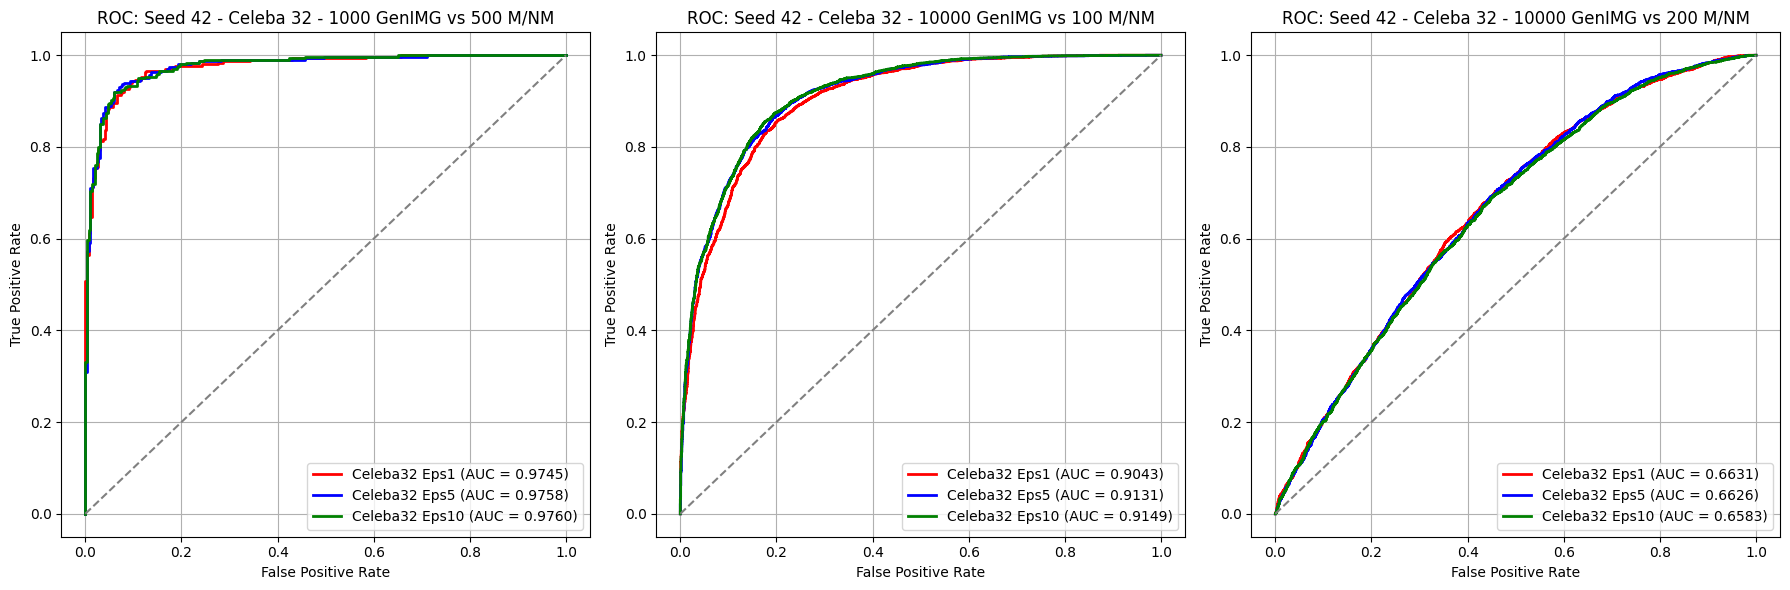

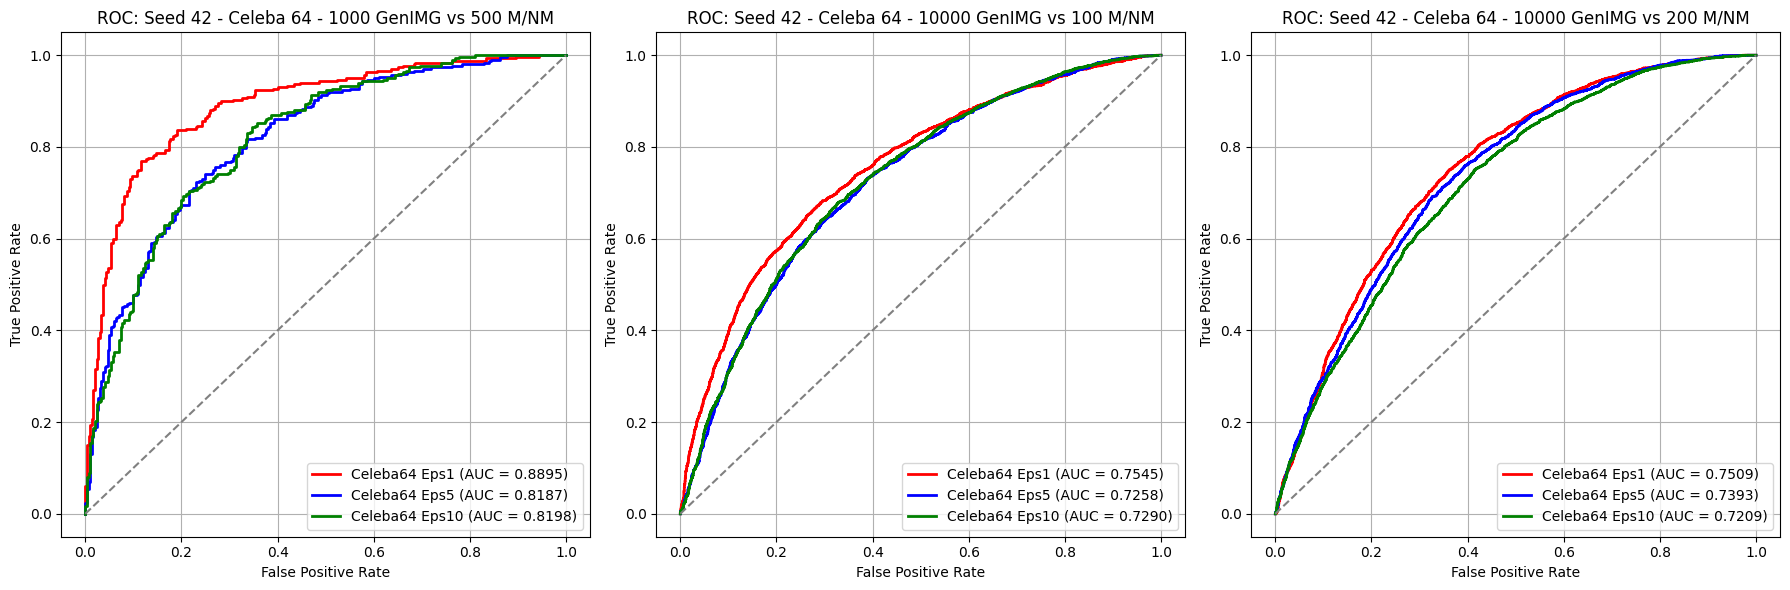

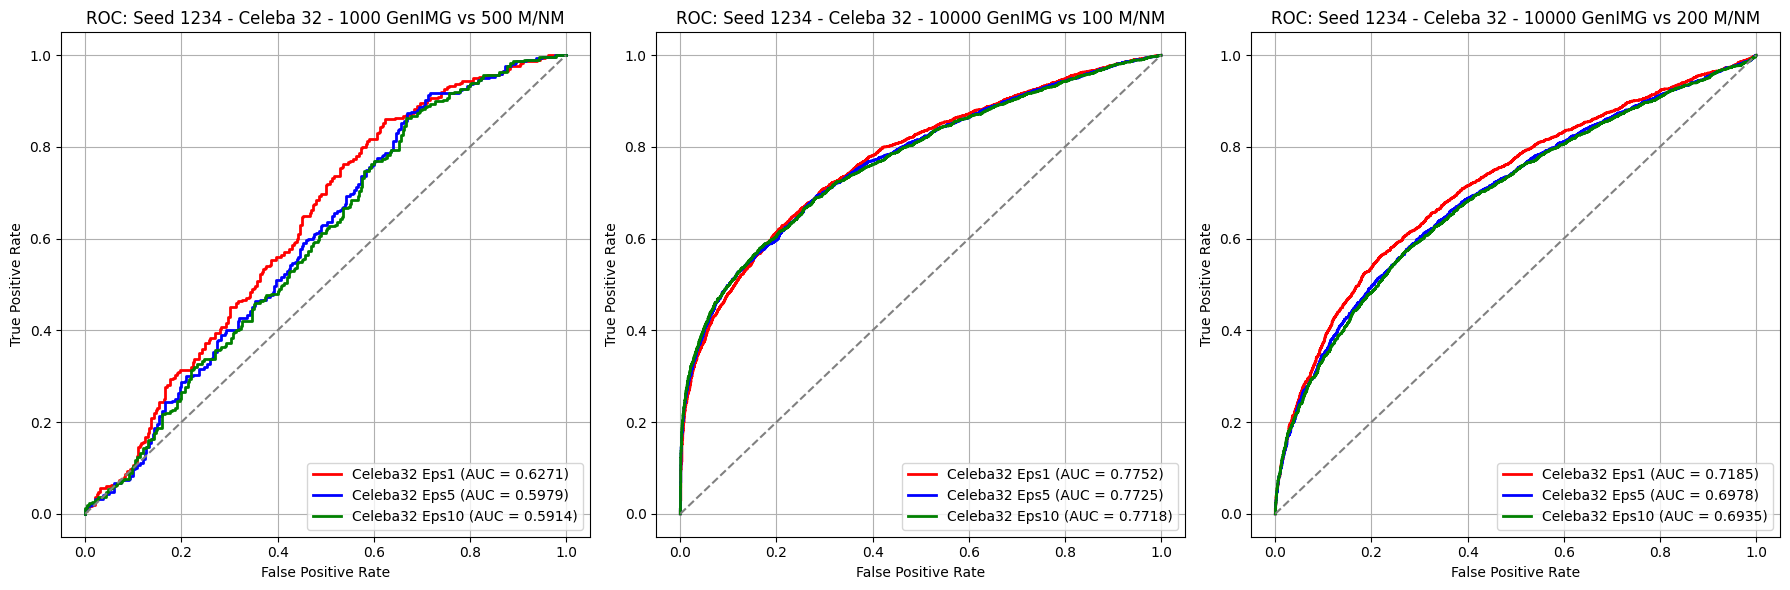

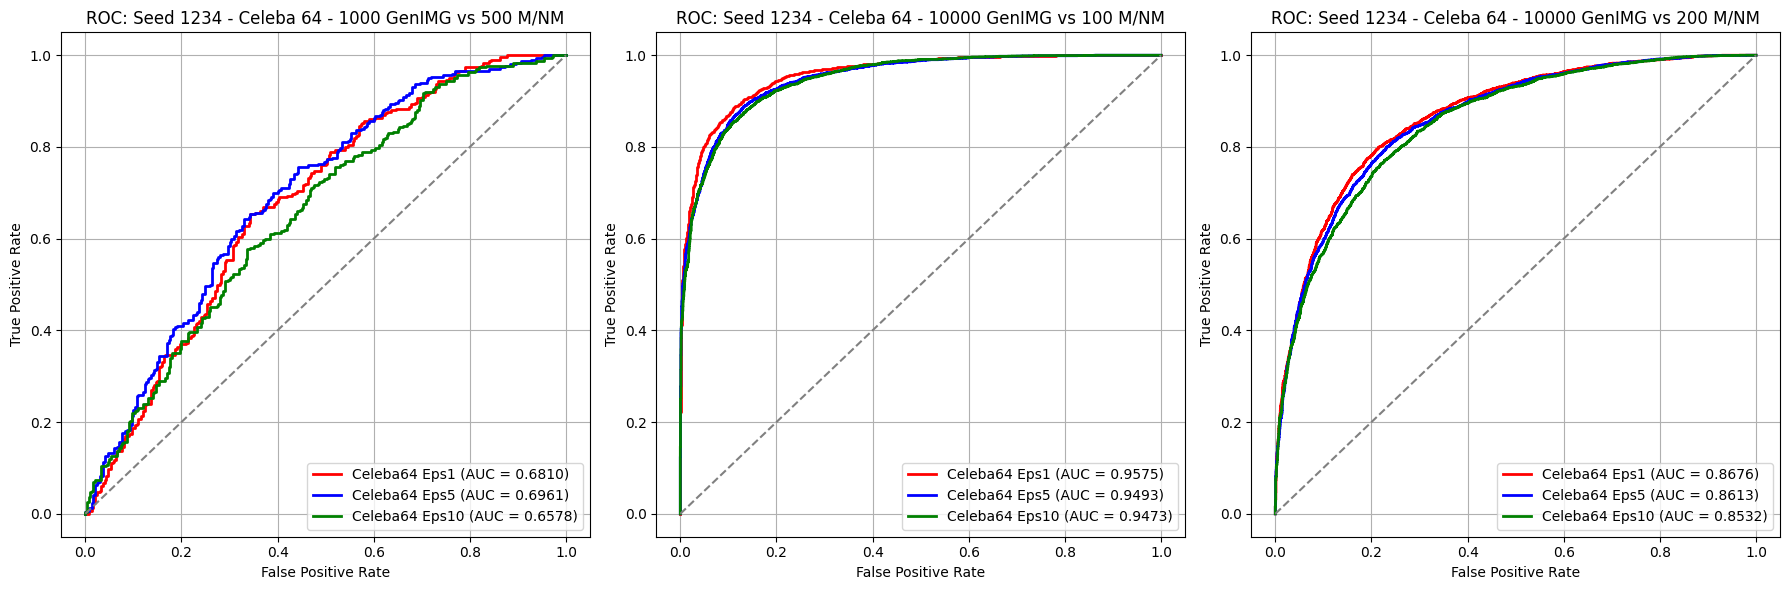

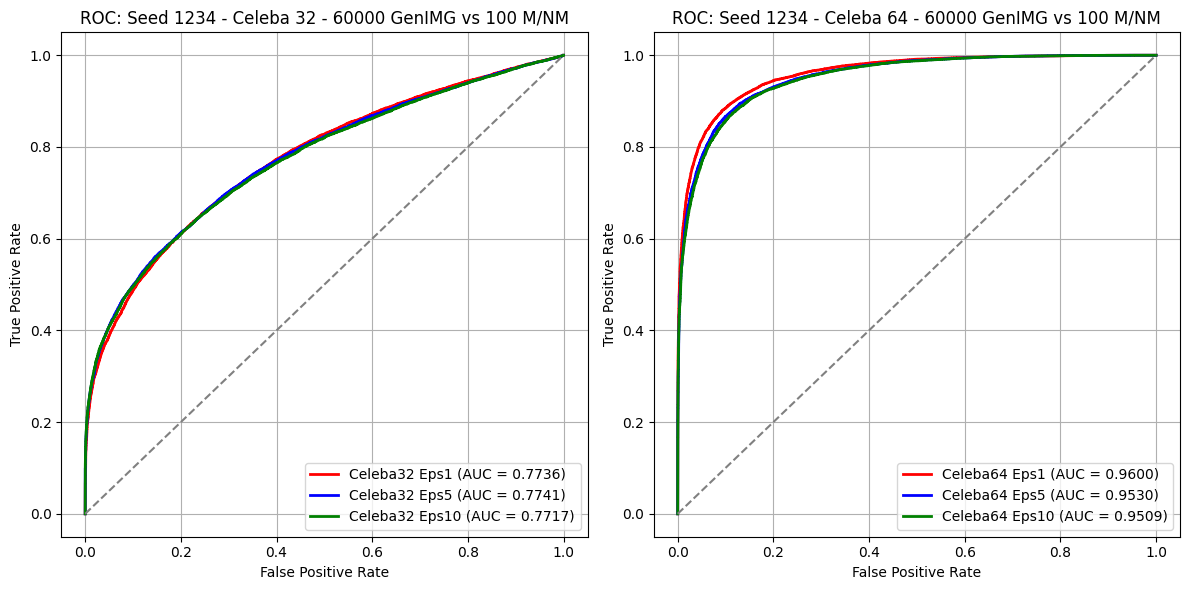

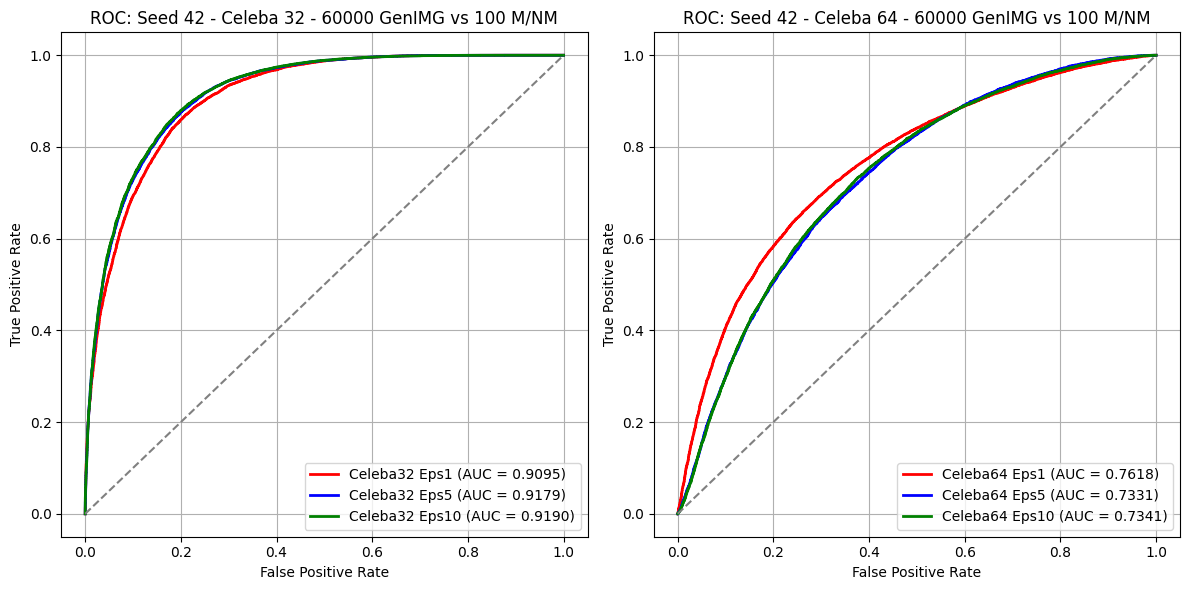

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

def evaluate_sampler(ax, mem_file, nonmem_file, label, color,seed = 42):
    # Load features
    all_mem_features = np.load(mem_file)
    all_nonmem_features = np.load(nonmem_file)

    # Prepare X, y
    X = np.vstack([all_mem_features, all_nonmem_features])
    y = np.array([1] * len(all_mem_features) + [0] * len(all_nonmem_features))

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=seed, stratify=y
    )

    # Train classifier
    clf = LogisticRegression(max_iter=500)
    clf.fit(X_train, y_train)

    # Predictions
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc_score = auc(fpr, tpr)

    # Plot ROC curve in the given subplot axis
    ax.plot(fpr, tpr, color=color, lw=2,
            label=f"{label} (AUC = {auc_score:.4f})")


# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.title("ROC-AUC Scores for DP-Promise Model")
# --- Subplot 1 ---
evaluate_sampler(axes[0], "New_all_mem_features_celeba32_eps1.npy", "New_all_nonmem_features_celeba32_eps1.npy", "Celeba32 Eps1", "red", seed=42)
evaluate_sampler(axes[0], "New_all_mem_features_celeba32_eps5.npy", "New_all_nonmem_features_celeba32_eps5.npy", "Celeba32 Eps5", "blue", seed=42)
evaluate_sampler(axes[0], "New_all_mem_features_celeba32_eps10.npy", "New_all_nonmem_features_celeba32_eps10.npy", "Celeba32 Eps10", "green", seed=42)
axes[0].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC: Seed 42 - Celeba 32 - 1000 GenIMG vs 500 M/NM")
axes[0].legend(loc="lower right")
axes[0].grid(True)

# --- Subplot 2 ---
evaluate_sampler(axes[1], "New_10000_all_mem_features_celeba32_eps1.npy", "New_10000_all_nonmem_features_celeba32_eps1.npy", "Celeba32 Eps1", "red", seed=42)
evaluate_sampler(axes[1], "New_10000_all_mem_features_celeba32_eps5.npy", "New_10000_all_nonmem_features_celeba32_eps5.npy", "Celeba32 Eps5", "blue", seed=42)
evaluate_sampler(axes[1], "New_10000_all_mem_features_celeba32_eps10.npy", "New_10000_all_nonmem_features_celeba32_eps10.npy", "Celeba32 Eps10", "green", seed=42)
axes[1].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC: Seed 42 - Celeba 32 - 10000 GenIMG vs 100 M/NM")
axes[1].legend(loc="lower right")
axes[1].grid(True)

# --- Subplot 3 ---
evaluate_sampler(axes[2], "New_10000_all_mem_features_celeba32_200_eps1.npy", "New_10000_all_nonmem_features_celeba32_200_eps1.npy", "Celeba32 Eps1", "red", seed=42)
evaluate_sampler(axes[2], "New_10000_all_mem_features_celeba32_200_eps5.npy", "New_10000_all_nonmem_features_celeba32_200_eps5.npy", "Celeba32 Eps5", "blue", seed=42)
evaluate_sampler(axes[2], "New_10000_all_mem_features_celeba32_200_eps10.npy", "New_10000_all_nonmem_features_celeba32_200_eps10.npy", "Celeba32 Eps10", "green", seed=42)
axes[2].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[2].set_xlabel("False Positive Rate")
axes[2].set_ylabel("True Positive Rate")
axes[2].set_title("ROC: Seed 42 - Celeba 32 - 10000 GenIMG vs 200 M/NM")
axes[2].legend(loc="lower right")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.title("ROC-AUC Scores for DP-Promise Model")
# --- Subplot 1 ---
evaluate_sampler(axes[0], "New_all_mem_features_celeba64_eps1.npy", "New_all_nonmem_features_celeba64_eps1.npy", "Celeba64 Eps1", "red", seed=42)
evaluate_sampler(axes[0], "New_all_mem_features_celeba64_eps5.npy", "New_all_nonmem_features_celeba64_eps5.npy", "Celeba64 Eps5", "blue", seed=42)
evaluate_sampler(axes[0], "New_all_mem_features_celeba64_eps10.npy", "New_all_nonmem_features_celeba64_eps10.npy", "Celeba64 Eps10", "green", seed=42)
axes[0].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC: Seed 42 - Celeba 64 - 1000 GenIMG vs 500 M/NM")
axes[0].legend(loc="lower right")
axes[0].grid(True)

# --- Subplot 2 ---
evaluate_sampler(axes[1], "New_10000_all_mem_features_celeba64_eps1.npy", "New_10000_all_nonmem_features_celeba64_eps1.npy", "Celeba64 Eps1", "red", seed=42)
evaluate_sampler(axes[1], "New_10000_all_mem_features_celeba64_eps5.npy", "New_10000_all_nonmem_features_celeba64_eps5.npy", "Celeba64 Eps5", "blue", seed=42)
evaluate_sampler(axes[1], "New_10000_all_mem_features_celeba64_eps10.npy", "New_10000_all_nonmem_features_celeba64_eps10.npy", "Celeba64 Eps10", "green", seed=42)
axes[1].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC: Seed 42 - Celeba 64 - 10000 GenIMG vs 100 M/NM")
axes[1].legend(loc="lower right")
axes[1].grid(True)

# --- Subplot 3 ---
evaluate_sampler(axes[2], "New_10000_all_mem_features_celeba64_200_eps1.npy", "New_10000_all_nonmem_features_celeba64_200_eps1.npy", "Celeba64 Eps1", "red", seed=42)
evaluate_sampler(axes[2], "New_10000_all_mem_features_celeba64_200_eps5.npy", "New_10000_all_nonmem_features_celeba64_200_eps5.npy", "Celeba64 Eps5", "blue", seed=42)
evaluate_sampler(axes[2], "New_10000_all_mem_features_celeba64_200_eps10.npy", "New_10000_all_nonmem_features_celeba64_200_eps10.npy", "Celeba64 Eps10", "green", seed=42)
axes[2].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[2].set_xlabel("False Positive Rate")
axes[2].set_ylabel("True Positive Rate")
axes[2].set_title("ROC: Seed 42 - Celeba 64 - 10000 GenIMG vs 200 M/NM")
axes[2].legend(loc="lower right")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.title("ROC-AUC Scores for DP-Promise Model")
# --- Subplot 1 ---
evaluate_sampler(axes[0], "New_all_mem_features_celeba32_eps1_seed1234.npy", "New_all_nonmem_features_celeba32_eps1_seed1234.npy", "Celeba32 Eps1", "red", seed=1234)
evaluate_sampler(axes[0], "New_all_mem_features_celeba32_eps5_seed1234.npy", "New_all_nonmem_features_celeba32_eps5_seed1234.npy", "Celeba32 Eps5", "blue", seed=1234)
evaluate_sampler(axes[0], "New_all_mem_features_celeba32_eps10_seed1234.npy", "New_all_nonmem_features_celeba32_eps10_seed1234.npy", "Celeba32 Eps10", "green", seed=1234)
axes[0].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC: Seed 1234 - Celeba 32 - 1000 GenIMG vs 500 M/NM")
axes[0].legend(loc="lower right")
axes[0].grid(True)

# --- Subplot 2 ---
evaluate_sampler(axes[1], "New_10000_all_mem_features_celeba32_eps1_seed1234.npy", "New_10000_all_nonmem_features_celeba32_eps1_seed1234.npy", "Celeba32 Eps1", "red", seed=1234)
evaluate_sampler(axes[1], "New_10000_all_mem_features_celeba32_eps5_seed1234.npy", "New_10000_all_nonmem_features_celeba32_eps5_seed1234.npy", "Celeba32 Eps5", "blue", seed=1234)
evaluate_sampler(axes[1], "New_10000_all_mem_features_celeba32_eps10_seed1234.npy", "New_10000_all_nonmem_features_celeba32_eps10_seed1234.npy", "Celeba32 Eps10", "green", seed=1234)
axes[1].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC: Seed 1234 - Celeba 32 - 10000 GenIMG vs 100 M/NM")
axes[1].legend(loc="lower right")
axes[1].grid(True)

# --- Subplot 3 ---
evaluate_sampler(axes[2], "New_10000_all_mem_features_celeba32_200_eps1_seed1234.npy", "New_10000_all_nonmem_features_celeba32_200_eps1_seed1234.npy", "Celeba32 Eps1", "red", seed=1234)
evaluate_sampler(axes[2], "New_10000_all_mem_features_celeba32_200_eps5_seed1234.npy", "New_10000_all_nonmem_features_celeba32_200_eps5_seed1234.npy", "Celeba32 Eps5", "blue", seed=1234)
evaluate_sampler(axes[2], "New_10000_all_mem_features_celeba32_200_eps10_seed1234.npy", "New_10000_all_nonmem_features_celeba32_200_eps10_seed1234.npy", "Celeba32 Eps10", "green", seed=1234)
axes[2].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[2].set_xlabel("False Positive Rate")
axes[2].set_ylabel("True Positive Rate")
axes[2].set_title("ROC: Seed 1234 - Celeba 32 - 10000 GenIMG vs 200 M/NM")
axes[2].legend(loc="lower right")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.title("ROC-AUC Scores for DP-Promise Model")
# --- Subplot 1 ---
evaluate_sampler(axes[0], "New_all_mem_features_celeba64_eps1_seed1234.npy", "New_all_nonmem_features_celeba64_eps1_seed1234.npy", "Celeba64 Eps1", "red", seed=1234)
evaluate_sampler(axes[0], "New_all_mem_features_celeba64_eps5_seed1234.npy", "New_all_nonmem_features_celeba64_eps5_seed1234.npy", "Celeba64 Eps5", "blue", seed=1234)
evaluate_sampler(axes[0], "New_all_mem_features_celeba64_eps10_seed1234.npy", "New_all_nonmem_features_celeba64_eps10_seed1234.npy", "Celeba64 Eps10", "green", seed=1234)
axes[0].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC: Seed 1234 - Celeba 64 - 1000 GenIMG vs 500 M/NM")
axes[0].legend(loc="lower right")
axes[0].grid(True)

# --- Subplot 2 ---
evaluate_sampler(axes[1], "New_10000_all_mem_features_celeba64_eps1_seed1234.npy", "New_10000_all_nonmem_features_celeba64_eps1_seed1234.npy", "Celeba64 Eps1", "red", seed=1234)
evaluate_sampler(axes[1], "New_10000_all_mem_features_celeba64_eps5_seed1234.npy", "New_10000_all_nonmem_features_celeba64_eps5_seed1234.npy", "Celeba64 Eps5", "blue", seed=1234)
evaluate_sampler(axes[1], "New_10000_all_mem_features_celeba64_eps10_seed1234.npy", "New_10000_all_nonmem_features_celeba64_eps10_seed1234.npy", "Celeba64 Eps10", "green", seed=1234)
axes[1].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC: Seed 1234 - Celeba 64 - 10000 GenIMG vs 100 M/NM")
axes[1].legend(loc="lower right")
axes[1].grid(True)

# --- Subplot 3 ---
evaluate_sampler(axes[2], "New_10000_all_mem_features_celeba64_200_eps1_seed1234.npy", "New_10000_all_nonmem_features_celeba64_200_eps1_seed1234.npy", "Celeba64 Eps1", "red", seed=1234)
evaluate_sampler(axes[2], "New_10000_all_mem_features_celeba64_200_eps5_seed1234.npy", "New_10000_all_nonmem_features_celeba64_200_eps5_seed1234.npy", "Celeba64 Eps5", "blue", seed=1234)
evaluate_sampler(axes[2], "New_10000_all_mem_features_celeba64_200_eps10_seed1234.npy", "New_10000_all_nonmem_features_celeba64_200_eps10_seed1234.npy", "Celeba64 Eps10", "green", seed=1234)
axes[2].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[2].set_xlabel("False Positive Rate")
axes[2].set_ylabel("True Positive Rate")
axes[2].set_title("ROC: Seed 1234 - Celeba 64 - 10000 GenIMG vs 200 M/NM")
axes[2].legend(loc="lower right")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.title("ROC-AUC Scores for DP-Promise Model")
# --- Subplot 1 ---
evaluate_sampler(axes[0], "60000_all_mem_features_celeba32_eps1_seed1234.npy", "60000_all_nonmem_features_celeba32_eps1_seed1234.npy", "Celeba32 Eps1", "red", seed=1234)
evaluate_sampler(axes[0], "60000_all_mem_features_celeba32_eps5_seed1234.npy", "60000_all_nonmem_features_celeba32_eps5_seed1234.npy", "Celeba32 Eps5", "blue", seed=1234)
evaluate_sampler(axes[0], "60000_all_mem_features_celeba32_eps10_seed1234.npy", "60000_all_nonmem_features_celeba32_eps10_seed1234.npy", "Celeba32 Eps10", "green", seed=1234)
axes[0].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC: Seed 1234 - Celeba 32 - 60000 GenIMG vs 100 M/NM")
axes[0].legend(loc="lower right")
axes[0].grid(True)
	
# --- Subplot 2 ---
evaluate_sampler(axes[1], "60000_all_mem_features_celeba64_eps1_seed1234.npy", "60000_all_nonmem_features_celeba64_eps1_seed1234.npy", "Celeba64 Eps1", "red", seed=1234)
evaluate_sampler(axes[1], "60000_all_mem_features_celeba64_eps5_seed1234.npy", "60000_all_nonmem_features_celeba64_eps5_seed1234.npy", "Celeba64 Eps5", "blue", seed=1234)
evaluate_sampler(axes[1], "60000_all_mem_features_celeba64_eps10_seed1234.npy", "60000_all_nonmem_features_celeba64_eps10_seed1234.npy", "Celeba64 Eps10", "green", seed=1234)
axes[1].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC: Seed 1234 - Celeba 64 - 60000 GenIMG vs 100 M/NM")
axes[1].legend(loc="lower right")
axes[1].grid(True)
plt.tight_layout()
plt.show()

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.title("ROC-AUC Scores for DP-Promise Model")
# --- Subplot 1 ---
evaluate_sampler(axes[0], "60000_all_mem_features_celeba32_eps1.npy", "60000_all_nonmem_features_celeba32_eps1.npy", "Celeba32 Eps1", "red", seed=42)
evaluate_sampler(axes[0], "60000_all_mem_features_celeba32_eps5.npy", "60000_all_nonmem_features_celeba32_eps5.npy", "Celeba32 Eps5", "blue", seed=42)
evaluate_sampler(axes[0], "60000_all_mem_features_celeba32_eps10.npy", "60000_all_nonmem_features_celeba32_eps10.npy", "Celeba32 Eps10", "green", seed=42)
axes[0].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC: Seed 42 - Celeba 32 - 60000 GenIMG vs 100 M/NM")
axes[0].legend(loc="lower right")
axes[0].grid(True)
	
# --- Subplot 2 ---
evaluate_sampler(axes[1], "60000_all_mem_features_celeba64_eps1.npy", "60000_all_nonmem_features_celeba64_eps1.npy", "Celeba64 Eps1", "red", seed=42)
evaluate_sampler(axes[1], "60000_all_mem_features_celeba64_eps5.npy", "60000_all_nonmem_features_celeba64_eps5.npy", "Celeba64 Eps5", "blue", seed=42)
evaluate_sampler(axes[1], "60000_all_mem_features_celeba64_eps10.npy", "60000_all_nonmem_features_celeba64_eps10.npy", "Celeba64 Eps10", "green", seed=42)
axes[1].plot([0, 1], [0, 1], color="gray", linestyle="--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC: Seed 42 - Celeba 64 - 60000 GenIMG vs 100 M/NM")
axes[1].legend(loc="lower right")
axes[1].grid(True)
plt.tight_layout()
plt.show()

## Black Box Attack(CLIP & LPIP) on CelebA 32(Eps 1, 5 & 10) with Median of 10 Random seed with Visuals
We have tested the Black box using CLIP Feature and LPIP distance for Random seed 1234 & 42 which resulted in fluctuation due to randomness in picking inputs for attack.  


So we decided to do a minimal attack of 100 Member & 100 Non Member against 1000 Generated Images with 10 different random seeds(10 set if this attack) and getting a median of them to get better understanding of privacy leakage across random seeds

Seeds used - [10, 21, 37, 42, 73, 85, 1234, 2024, 4096, 9999]

In [3]:
import os
import math
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import lpips
import clip
import pandas as pd

# --- plotting (headless-safe) ---
import matplotlib
matplotlib.use("Agg")  # safe on servers without display
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
SEEDS = [10, 21, 37, 42, 73, 85, 1234, 2024, 4096, 9999]
N_MEM, N_NONMEM, N_GEN = 100, 100, 1000  # images per seed

# data paths (update if needed)
MEMBERS_DIR    = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train"
NONMEMBERS_DIR = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test"
GEN_DIR        = "Generated Images/samples_celeba32_eps1"

# ---- hard-coded titles / name stem ----
FIG_TITLE = "CelebA 32 — ε=1 — Score histograms per seed"
FILE_STEM = "Celeba32_Eps1_BB"   # final files: <stem>_Histogram.png, <stem>_ROC_Curve.png

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
print(f"Using device: {device}")

# -----------------------------
# UTILITIES
# -----------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_image_paths(folder, exts={".png", ".jpg", ".jpeg"}):
    return [os.path.join(folder, f) for f in os.listdir(folder)
            if os.path.splitext(f)[1].lower() in exts]

# models
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
lpips_model = lpips.LPIPS(net="alex").to(device)

def load_image_for_clip(path):
    return clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)

def load_image_for_lpips(path):
    img = Image.open(path).convert("RGB").resize((224, 224))
    t = (torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255.).unsqueeze(0)
    t = (t - 0.5) * 2
    return t.to(device)

@torch.no_grad()
def extract_clip_feature(path):
    img = load_image_for_clip(path)
    feat = clip_model.encode_image(img)
    feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

@torch.no_grad()
def lpips_distance(p1, p2):
    return lpips_model(load_image_for_lpips(p1), load_image_for_lpips(p2)).item()

def cosine_similarity(gen_feat, ref_feats):
    g = torch.tensor(gen_feat).unsqueeze(0)
    r = torch.tensor(ref_feats)
    g = F.normalize(g, dim=1); r = F.normalize(r, dim=1)
    return (r @ g.T).squeeze(1).numpy()

def lpips_distances(gen_path, ref_paths):
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])

def stats(arr):
    return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

# -----------------------------
# LOAD PATH LISTS
# -----------------------------
members_all    = get_image_paths(MEMBERS_DIR)
nonmembers_all = get_image_paths(NONMEMBERS_DIR)
generated_all  = get_image_paths(GEN_DIR)

print(f"Pool sizes — members: {len(members_all)}, non-members: {len(nonmembers_all)}, generated: {len(generated_all)}")

# -----------------------------
# RUN EXPERIMENT OVER SEEDS
# -----------------------------
seed_rows = []
roc_curves = []  # store fpr/tpr/auc per seed for overlay figure

# Collect per-seed score distributions for final grid
all_probs_mem_by_seed = []
all_probs_nonmem_by_seed = []
aucs_by_seed = []
seeds_in_order = []

for seed in SEEDS:
    print(f"\n=== Seed {seed} ===")
    set_seed(seed)

    # fresh sample for each seed
    mem_paths    = random.sample(members_all, N_MEM)
    nonmem_paths = random.sample(nonmembers_all, N_NONMEM)
    gen_paths    = random.sample(generated_all, N_GEN)

    # CLIP features (no batching)
    mem_clip    = torch.cat([extract_clip_feature(p) for p in tqdm(mem_paths, desc="CLIP members")], 0).numpy()
    nonmem_clip = torch.cat([extract_clip_feature(p) for p in tqdm(nonmem_paths, desc="CLIP non-members")], 0).numpy()
    gen_clip    = torch.cat([extract_clip_feature(p) for p in tqdm(gen_paths, desc="CLIP generated")], 0).numpy()

    # build features
    all_mem_features, all_nonmem_features = [], []
    for i, gen_path in enumerate(tqdm(gen_paths, desc="Features per generated")):
        cos_mem    = cosine_similarity(gen_clip[i], mem_clip)
        cos_nonmem = cosine_similarity(gen_clip[i], nonmem_clip)
        lp_mem     = lpips_distances(gen_path, mem_paths)
        lp_nonmem  = lpips_distances(gen_path, nonmem_paths)
        all_mem_features.append(stats(cos_mem) + stats(lp_mem))
        all_nonmem_features.append(stats(cos_nonmem) + stats(lp_nonmem))

    X = np.vstack([np.array(all_mem_features), np.array(all_nonmem_features)])
    y = np.array([1]*len(all_mem_features) + [0]*len(all_nonmem_features))

    # split/train/test
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, random_state=seed, stratify=y)
    clf = LogisticRegression(max_iter=500, random_state=seed)
    clf.fit(X_tr, y_tr)
    y_prob = clf.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, y_prob)

    # ROC for overlay plot
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    roc_curves.append({"seed": seed, "fpr": fpr, "tpr": tpr, "auc": auc})

    # Collect per-seed score distributions for histogram grid
    all_probs_mem_by_seed.append(y_prob[y_te == 1])
    all_probs_nonmem_by_seed.append(y_prob[y_te == 0])
    aucs_by_seed.append(auc)
    seeds_in_order.append(seed)

    print(f"ROC-AUC (seed {seed}): {auc:.4f}")
    seed_rows.append({"seed": seed, "roc_auc": auc})

# -----------------------------
# SUMMARY
# -----------------------------
df = pd.DataFrame(seed_rows).sort_values("seed").reset_index(drop=True)
print("\nPer-seed ROC-AUCs:")
print(df.to_string(index=False, formatters={"roc_auc": lambda x: f"{x:.4f}"}))

aucs = df["roc_auc"].to_numpy()
mean_auc = aucs.mean()
std_auc  = aucs.std(ddof=1)

print("\n=== Summary over seeds ===")
print(f"Mean ROC-AUC: {mean_auc:.4f}")
print(f"Std  ROC-AUC: {std_auc:.4f}")

df.to_csv(f"{FILE_STEM}_seed_results.csv", index=False)
print(f"\nSaved per-seed results to: {FILE_STEM}_seed_results.csv")

# -----------------------------
# FINAL CONSOLIDATED FIGURES
# -----------------------------

# (1) Grid of member vs non-member histograms, one subplot per seed
n = len(seeds_in_order)
ncols = 4
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3), sharex=True, sharey=True)
axes = np.array(axes).reshape(-1)
bins = np.linspace(0.0, 1.0, 21)
legend_handles = None

for i, seed in enumerate(seeds_in_order):
    ax = axes[i]
    h1 = ax.hist(all_probs_mem_by_seed[i],    bins=bins, alpha=0.6, density=True, edgecolor="black", label="Member")
    h2 = ax.hist(all_probs_nonmem_by_seed[i], bins=bins, alpha=0.6, density=True, edgecolor="black", label="Non-member")
    ax.set_title(f"Seed {seed} (AUC={aucs_by_seed[i]:.2f})", fontsize=9)
    if legend_handles is None:
        legend_handles = [h1[2][0], h2[2][0]]

# hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

for r in range(nrows):
    axes[r*ncols].set_ylabel("Density")
for c in range(ncols):
    idx = (nrows-1)*ncols + c
    if idx < len(axes):
        axes[idx].set_xlabel("Predicted P(member) on test set")

fig.suptitle(FIG_TITLE, y=0.99, fontsize=12)
if legend_handles:
    fig.legend(legend_handles, ["Member", "Non-member"], loc="upper right", frameon=False)

fig.tight_layout(rect=[0,0,0.98,0.95])
out_hist = f"{FILE_STEM}_Histogram.png"
plt.savefig(out_hist, dpi=220)
plt.show()
print(f"Saved consolidated histogram grid: {out_hist}")

# (2) Overlay ROC curves across seeds (single consolidated figure)
plt.figure(figsize=(6,5))
for r in roc_curves:
    plt.plot(r["fpr"], r["tpr"], linewidth=1.2, alpha=0.35, label=f"seed {r['seed']} (AUC={r['auc']:.2f})")
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nROC curves across seeds")
plt.legend(loc="lower right", fontsize=7, frameon=False, ncol=2)
plt.tight_layout()
out_roc = f"{FILE_STEM}_ROC_Curve.png"
plt.savefig(out_roc, dpi=220)
plt.show()
print(f"Saved consolidated ROC overlay: {out_roc}")


Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Pool sizes — members: 162079, non-members: 40520, generated: 60000

=== Seed 10 ===


Features per generated: 100%|██████████| 1000/1000 [15:34<00:00,  1.07it/s]


ROC-AUC (seed 10): 0.6710

=== Seed 21 ===


Features per generated: 100%|██████████| 1000/1000 [15:31<00:00,  1.07it/s]


ROC-AUC (seed 21): 0.8085

=== Seed 37 ===


Features per generated: 100%|██████████| 1000/1000 [15:31<00:00,  1.07it/s]


ROC-AUC (seed 37): 0.9312

=== Seed 42 ===


Features per generated: 100%|██████████| 1000/1000 [15:31<00:00,  1.07it/s]


ROC-AUC (seed 42): 0.8425

=== Seed 73 ===


Features per generated: 100%|██████████| 1000/1000 [15:26<00:00,  1.08it/s]


ROC-AUC (seed 73): 0.5902

=== Seed 85 ===


Features per generated: 100%|██████████| 1000/1000 [15:26<00:00,  1.08it/s]


ROC-AUC (seed 85): 0.7207

=== Seed 1234 ===


Features per generated: 100%|██████████| 1000/1000 [15:26<00:00,  1.08it/s]


ROC-AUC (seed 1234): 0.7463

=== Seed 2024 ===


Features per generated: 100%|██████████| 1000/1000 [15:26<00:00,  1.08it/s]


ROC-AUC (seed 2024): 0.8954

=== Seed 4096 ===


Features per generated: 100%|██████████| 1000/1000 [14:37<00:00,  1.14it/s]


ROC-AUC (seed 4096): 0.8516

=== Seed 9999 ===


Features per generated: 100%|██████████| 1000/1000 [13:30<00:00,  1.23it/s]


ROC-AUC (seed 9999): 0.9475

Per-seed ROC-AUCs:
 seed roc_auc
   10  0.6710
   21  0.8085
   37  0.9312
   42  0.8425
   73  0.5902
   85  0.7207
 1234  0.7463
 2024  0.8954
 4096  0.8516
 9999  0.9475

=== Summary over seeds ===
Mean ROC-AUC: 0.8005
Std  ROC-AUC: 0.1166

Saved per-seed results to: Celeba32_Eps1_BB_seed_results.csv
Saved consolidated histogram grid: Celeba32_Eps1_BB_Histogram.png
Saved consolidated ROC overlay: Celeba32_Eps1_BB_ROC_Curve.png


In [15]:
# === VISUALS ONLY (no recompute) ===
import math, numpy as np
import matplotlib.pyplot as plt

# ---- titles / filenames (hardcode to match your test) ----
FIG_TITLE = "CelebA 32 — ε=1 — Score histograms per seed"
FILE_STEM = "Celeba32_Eps1_BB"   # outputs: <stem>_Histogram.png, _ROC_Curve_mean.png, _ROC_Curve_overlay.png

# ---- pull AUCs robustly (from df if present; else from roc_curves) ----
try:
    aucs = df["roc_auc"].to_numpy()
except Exception:
    aucs = np.array([r["auc"] for r in roc_curves])
mean_auc = float(np.mean(aucs))
std_auc  = float(np.std(aucs, ddof=1))

# =========================
# 1) CONSOLIDATED HISTOGRAM GRID (counts, per-seed)
# =========================
n = len(seeds_in_order)
ncols = 4
nrows = math.ceil(n / ncols)
BINS  = 40

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = np.array(axes).reshape(-1)

for i, seed in enumerate(seeds_in_order):
    ax  = axes[i]
    mem = np.asarray(all_probs_mem_by_seed[i])
    non = np.asarray(all_probs_nonmem_by_seed[i])

    ax.hist(mem, bins=BINS, alpha=0.6, label="Members")
    ax.hist(non, bins=BINS, alpha=0.6, label="Non-members")

    # auto-zoom to central 99% to make separation visible
    lo, hi = np.percentile(np.r_[mem, non], [0.5, 99.5])
    pad = 0.02 * (hi - lo + 1e-12)
    ax.set_xlim(lo - pad, hi + pad)

    ax.set_title(f"Seed {seed} (AUC={aucs[i]:.2f})", fontsize=9)
    ax.set_xlabel("Scores")
    ax.set_ylabel("Count")
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(frameon=False)

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.suptitle(FIG_TITLE, y=0.99, fontsize=12)
plt.tight_layout(rect=[0,0,1,0.96])
out_hist = f"{FILE_STEM}_Histogram.png"
plt.savefig(out_hist, dpi=220)
plt.show()
print(f"Saved consolidated histogram grid: {out_hist}")

# =========================
# 2) MEAN ROC + ±1σ BAND
# =========================
# Interpolate each seed’s ROC onto a common FPR grid, then average
fpr_grid = np.linspace(0.0, 1.0, 201)
tprs_interp = np.array([np.interp(fpr_grid, r["fpr"], r["tpr"]) for r in roc_curves])

mean_tpr = tprs_interp.mean(axis=0)
std_tpr  = tprs_interp.std(axis=0, ddof=1)
lower = np.clip(mean_tpr - std_tpr, 0, 1)
upper = np.clip(mean_tpr + std_tpr, 0, 1)

plt.figure(figsize=(6,5))
plt.plot(fpr_grid, mean_tpr, linewidth=2.8, label=f"Mean ROC (AUC={mean_auc:.2f})")
plt.fill_between(fpr_grid, lower, upper, alpha=0.25, label="±1 std")
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nMean ROC across seeds")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
out_mean = f"{FILE_STEM}_ROC_Curve_mean.png"
plt.savefig(out_mean, dpi=220)
plt.show()
print(f"Saved mean ROC with band: {out_mean}")

# =========================
# 3) OVERLAY ROCs, HIGHLIGHT MEDIAN-AUC SEED (brighter)
# =========================
# choose the median-AUC seed to avoid cherry-picking
if 'df' in globals():
    median_idx = np.argsort(df["roc_auc"].to_numpy())[len(aucs)//2]
    highlight_seed = int(df.loc[median_idx, "seed"])
else:
    # fall back: pick by sorted(aucs)
    order = np.argsort(aucs)
    highlight_seed = roc_curves[order[len(aucs)//2]]["seed"]

plt.figure(figsize=(6,5))
for r in roc_curves:
    lw = 1.0
    alpha = 0.20
    if r["seed"] == highlight_seed:
        lw = 2.8
        alpha = 0.95
    plt.plot(r["fpr"], r["tpr"], linewidth=lw, alpha=alpha,
             label=(f"seed {r['seed']} (AUC={r['auc']:.2f})" if r["seed"] == highlight_seed else None))
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nROC curves (median seed highlighted)")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
out_overlay = f"{FILE_STEM}_ROC_Curve_overlay.png"
plt.savefig(out_overlay, dpi=220)
plt.show()
print(f"Saved ROC overlay (highlighted): {out_overlay}")


Saved consolidated histogram grid: Celeba32_Eps1_BB_Histogram.png
Saved mean ROC with band: Celeba32_Eps1_BB_ROC_Curve_mean.png
Saved ROC overlay (highlighted): Celeba32_Eps1_BB_ROC_Curve_overlay.png


Median in ROC-AUC Curve


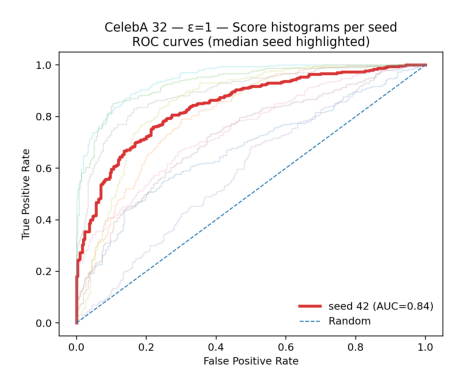

Mean & STD in ROC-AUC Curve


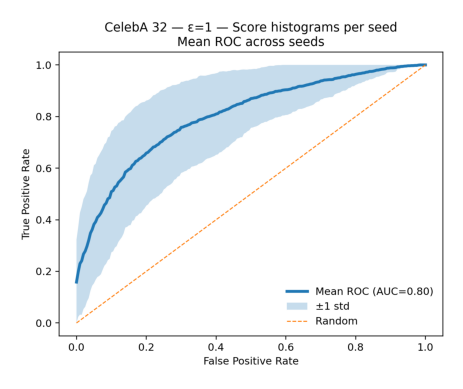

Histogram for different seeds


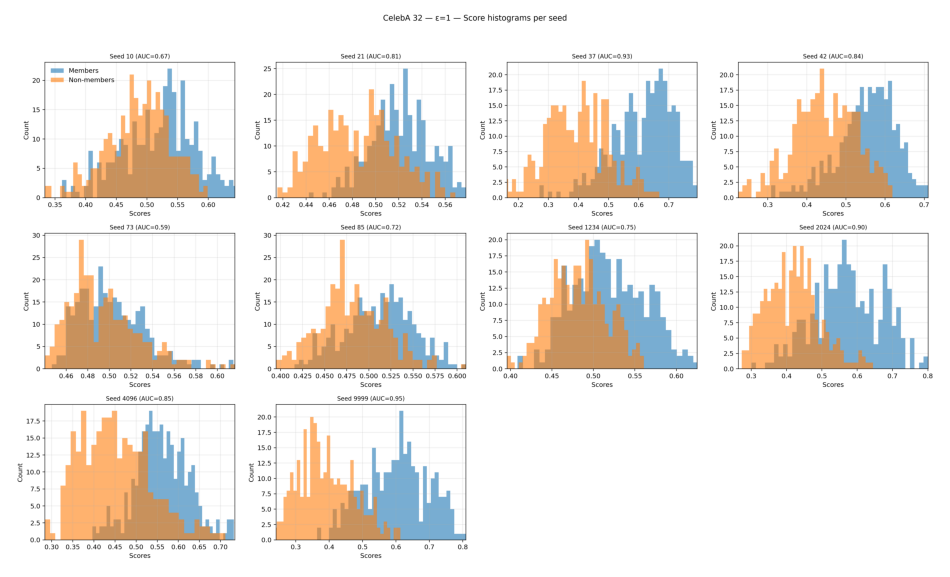

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print("Median in ROC-AUC Curve")
img = mpimg.imread('Celeba32_Eps1_BB_ROC_Curve_overlay.png')
plt.imshow(img)
plt.axis('off')  # Hide axis ticks
plt.show()
print("Mean & STD in ROC-AUC Curve")
img1 = mpimg.imread('Celeba32_Eps1_BB_ROC_Curve_mean.png')
plt.imshow(img1)
plt.axis('off')  # Hide axis ticks
plt.show()
print("Histogram for different seeds")
img2 = mpimg.imread('Celeba32_Eps1_BB_Histogram.png')
plt.figure(figsize=(12, 8))
plt.imshow(img2)
plt.axis('off')  # Hide axis ticks
plt.show()



In [17]:
import os
import math
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import lpips
import clip
import pandas as pd

# --- plotting (headless-safe) ---
import matplotlib
matplotlib.use("Agg")  # safe on servers without display
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
SEEDS = [10, 21, 37, 42, 73, 85, 1234, 2024, 4096, 9999]
N_MEM, N_NONMEM, N_GEN = 100, 100, 1000  # images per seed

# data paths (update if needed)
MEMBERS_DIR    = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train"
NONMEMBERS_DIR = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test"
GEN_DIR        = "Generated Images/samples_celeba32_eps5"

# ---- hard-coded titles / name stem ----
FIG_TITLE = "CelebA 32 — ε=5 — Score histograms per seed"
FILE_STEM = "Celeba32_Eps5_BB"   # final files: <stem>_Histogram.png, _ROC_Curve_mean.png, _ROC_Curve_overlay.png

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
print(f"Using device: {device}")

# -----------------------------
# UTILITIES
# -----------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_image_paths(folder, exts={".png", ".jpg", ".jpeg"}):
    return [os.path.join(folder, f) for f in os.listdir(folder)
            if os.path.splitext(f)[1].lower() in exts]

# models
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
lpips_model = lpips.LPIPS(net="alex").to(device)

def load_image_for_clip(path):
    return clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)

def load_image_for_lpips(path):
    img = Image.open(path).convert("RGB").resize((224, 224))
    t = (torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255.).unsqueeze(0)
    t = (t - 0.5) * 2
    return t.to(device)

@torch.no_grad()
def extract_clip_feature(path):
    img = load_image_for_clip(path)
    feat = clip_model.encode_image(img)
    feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

@torch.no_grad()
def lpips_distance(p1, p2):
    return lpips_model(load_image_for_lpips(p1), load_image_for_lpips(p2)).item()

def cosine_similarity(gen_feat, ref_feats):
    g = torch.tensor(gen_feat).unsqueeze(0)
    r = torch.tensor(ref_feats)
    g = F.normalize(g, dim=1); r = F.normalize(r, dim=1)
    return (r @ g.T).squeeze(1).numpy()

def lpips_distances(gen_path, ref_paths):
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])

def stats(arr):
    return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

# -----------------------------
# LOAD PATH LISTS
# -----------------------------
members_all    = get_image_paths(MEMBERS_DIR)
nonmembers_all = get_image_paths(NONMEMBERS_DIR)
generated_all  = get_image_paths(GEN_DIR)

print(f"Pool sizes — members: {len(members_all)}, non-members: {len(nonmembers_all)}, generated: {len(generated_all)}")

# -----------------------------
# RUN EXPERIMENT OVER SEEDS
# -----------------------------
seed_rows = []
roc_curves = []  # store fpr/tpr/auc per seed for overlay figure

# Collect per-seed score distributions for final grid
all_probs_mem_by_seed = []
all_probs_nonmem_by_seed = []
aucs_by_seed = []
seeds_in_order = []

for seed in SEEDS:
    print(f"\n=== Seed {seed} ===")
    set_seed(seed)

    # fresh sample for each seed
    mem_paths    = random.sample(members_all, N_MEM)
    nonmem_paths = random.sample(nonmembers_all, N_NONMEM)
    gen_paths    = random.sample(generated_all, N_GEN)

    # CLIP features (no batching)
    mem_clip    = torch.cat([extract_clip_feature(p) for p in tqdm(mem_paths, desc="CLIP members")], 0).numpy()
    nonmem_clip = torch.cat([extract_clip_feature(p) for p in tqdm(nonmem_paths, desc="CLIP non-members")], 0).numpy()
    gen_clip    = torch.cat([extract_clip_feature(p) for p in tqdm(gen_paths, desc="CLIP generated")], 0).numpy()

    # build features
    all_mem_features, all_nonmem_features = [], []
    for i, gen_path in enumerate(tqdm(gen_paths, desc="Features per generated")):
        cos_mem    = cosine_similarity(gen_clip[i], mem_clip)
        cos_nonmem = cosine_similarity(gen_clip[i], nonmem_clip)
        lp_mem     = lpips_distances(gen_path, mem_paths)
        lp_nonmem  = lpips_distances(gen_path, nonmem_paths)
        all_mem_features.append(stats(cos_mem) + stats(lp_mem))
        all_nonmem_features.append(stats(cos_nonmem) + stats(lp_nonmem))

    X = np.vstack([np.array(all_mem_features), np.array(all_nonmem_features)])
    y = np.array([1]*len(all_mem_features) + [0]*len(all_nonmem_features))

    # split/train/test
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, random_state=seed, stratify=y)
    clf = LogisticRegression(max_iter=500, random_state=seed)
    clf.fit(X_tr, y_tr)
    y_prob = clf.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, y_prob)

    # ROC for later fig
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    roc_curves.append({"seed": seed, "fpr": fpr, "tpr": tpr, "auc": auc})

    # per-seed score distributions
    all_probs_mem_by_seed.append(y_prob[y_te == 1])
    all_probs_nonmem_by_seed.append(y_prob[y_te == 0])
    aucs_by_seed.append(auc)
    seeds_in_order.append(seed)

    print(f"ROC-AUC (seed {seed}): {auc:.4f}")
    seed_rows.append({"seed": seed, "roc_auc": auc})

# -----------------------------
# SUMMARY
# -----------------------------
df = pd.DataFrame(seed_rows).sort_values("seed").reset_index(drop=True)
print("\nPer-seed ROC-AUCs:")
print(df.to_string(index=False, formatters={"roc_auc": lambda x: f"{x:.4f}"}))

aucs = df["roc_auc"].to_numpy()
mean_auc = aucs.mean()
std_auc  = aucs.std(ddof=1)

print("\n=== Summary over seeds ===")
print(f"Mean ROC-AUC: {mean_auc:.4f}")
print(f"Std  ROC-AUC: {std_auc:.4f}")

df.to_csv(f"{FILE_STEM}_seed_results.csv", index=False)
print(f"\nSaved per-seed results to: {FILE_STEM}_seed_results.csv")

# -----------------------------
# FINAL CONSOLIDATED FIGURES
# -----------------------------

# (1) Consolidated histogram grid (counts, per-seed, auto-zoomed)
n = len(seeds_in_order)
ncols = 4
nrows = math.ceil(n / ncols)
BINS  = 40

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = np.array(axes).reshape(-1)

for i, seed in enumerate(seeds_in_order):
    ax  = axes[i]
    mem = np.asarray(all_probs_mem_by_seed[i])
    non = np.asarray(all_probs_nonmem_by_seed[i])

    ax.hist(mem, bins=BINS, alpha=0.6, label="Members")
    ax.hist(non, bins=BINS, alpha=0.6, label="Non-members")

    # zoom to central 99% to make separation visible
    lo, hi = np.percentile(np.r_[mem, non], [0.5, 99.5])
    pad = 0.02 * (hi - lo + 1e-12)
    ax.set_xlim(lo - pad, hi + pad)

    ax.set_title(f"Seed {seed} (AUC={aucs_by_seed[i]:.2f})", fontsize=9)
    ax.set_xlabel("Scores")
    ax.set_ylabel("Count")
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(frameon=False)

# hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.suptitle(FIG_TITLE, y=0.99, fontsize=12)
plt.tight_layout(rect=[0,0,1,0.96])
out_hist = f"{FILE_STEM}_Histogram.png"
plt.savefig(out_hist, dpi=220)
plt.show()
plt.close()
print(f"Saved consolidated histogram grid: {out_hist}")

# (2A) Mean ROC + ±1σ band (single clean curve)
fpr_grid = np.linspace(0.0, 1.0, 201)
tprs_interp = np.array([np.interp(fpr_grid, r["fpr"], r["tpr"]) for r in roc_curves])

mean_tpr = tprs_interp.mean(axis=0)
std_tpr  = tprs_interp.std(axis=0, ddof=1)
lower = np.clip(mean_tpr - std_tpr, 0, 1)
upper = np.clip(mean_tpr + std_tpr, 0, 1)

plt.figure(figsize=(6,5))
plt.plot(fpr_grid, mean_tpr, linewidth=2.8, label=f"Mean ROC (AUC={mean_auc:.2f})")
plt.fill_between(fpr_grid, lower, upper, alpha=0.25, label="±1 std")
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nMean ROC across seeds")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
out_mean = f"{FILE_STEM}_ROC_Curve_mean.png"
plt.savefig(out_mean, dpi=220)
plt.show()
plt.close()
print(f"Saved mean ROC with band: {out_mean}")

# (2B) Overlay all ROCs, highlight median-AUC seed
median_idx = np.argsort(aucs)[len(aucs)//2]
highlight_seed = int(df.loc[median_idx, "seed"])

plt.figure(figsize=(6,5))
for r in roc_curves:
    lw = 1.0
    alpha = 0.20
    if r["seed"] == highlight_seed:
        lw = 2.8
        alpha = 0.95
    plt.plot(r["fpr"], r["tpr"], linewidth=lw, alpha=alpha,
             label=(f"seed {r['seed']} (AUC={r['auc']:.2f})" if r["seed"] == highlight_seed else None))
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nROC curves (median seed highlighted)")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
out_overlay = f"{FILE_STEM}_ROC_Curve_overlay.png"
plt.savefig(out_overlay, dpi=220)
plt.show()
plt.close()
print(f"Saved consolidated ROC overlay: {out_overlay}")


Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
Pool sizes — members: 162079, non-members: 40520, generated: 60000

=== Seed 10 ===


Features per generated: 100%|██████████| 1000/1000 [13:34<00:00,  1.23it/s]


ROC-AUC (seed 10): 0.6583

=== Seed 21 ===


Features per generated: 100%|██████████| 1000/1000 [13:33<00:00,  1.23it/s]


ROC-AUC (seed 21): 0.7936

=== Seed 37 ===


Features per generated: 100%|██████████| 1000/1000 [13:35<00:00,  1.23it/s]


ROC-AUC (seed 37): 0.9315

=== Seed 42 ===


Features per generated: 100%|██████████| 1000/1000 [13:34<00:00,  1.23it/s]


ROC-AUC (seed 42): 0.8596

=== Seed 73 ===


Features per generated: 100%|██████████| 1000/1000 [13:32<00:00,  1.23it/s]


ROC-AUC (seed 73): 0.6001

=== Seed 85 ===


Features per generated: 100%|██████████| 1000/1000 [13:32<00:00,  1.23it/s]


ROC-AUC (seed 85): 0.7622

=== Seed 1234 ===


Features per generated: 100%|██████████| 1000/1000 [13:34<00:00,  1.23it/s]


ROC-AUC (seed 1234): 0.7387

=== Seed 2024 ===


Features per generated: 100%|██████████| 1000/1000 [13:31<00:00,  1.23it/s]


ROC-AUC (seed 2024): 0.8829

=== Seed 4096 ===


Features per generated: 100%|██████████| 1000/1000 [13:32<00:00,  1.23it/s]


ROC-AUC (seed 4096): 0.8445

=== Seed 9999 ===


Features per generated: 100%|██████████| 1000/1000 [13:31<00:00,  1.23it/s]


ROC-AUC (seed 9999): 0.9316

Per-seed ROC-AUCs:
 seed roc_auc
   10  0.6583
   21  0.7936
   37  0.9315
   42  0.8596
   73  0.6001
   85  0.7622
 1234  0.7387
 2024  0.8829
 4096  0.8445
 9999  0.9316

=== Summary over seeds ===
Mean ROC-AUC: 0.8003
Std  ROC-AUC: 0.1117

Saved per-seed results to: Celeba32_Eps5_BB_seed_results.csv
Saved consolidated histogram grid: Celeba32_Eps5_BB_Histogram.png
Saved mean ROC with band: Celeba32_Eps5_BB_ROC_Curve_mean.png
Saved consolidated ROC overlay: Celeba32_Eps5_BB_ROC_Curve_overlay.png


Median in ROC-AUC Curve


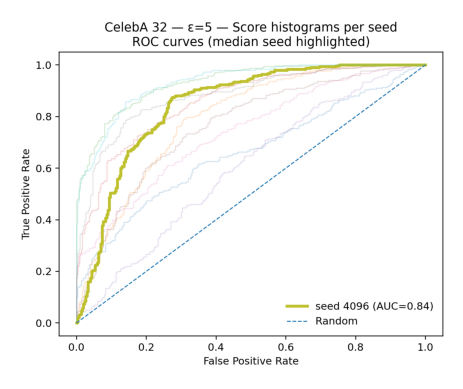

Mean & STD in ROC-AUC Curve


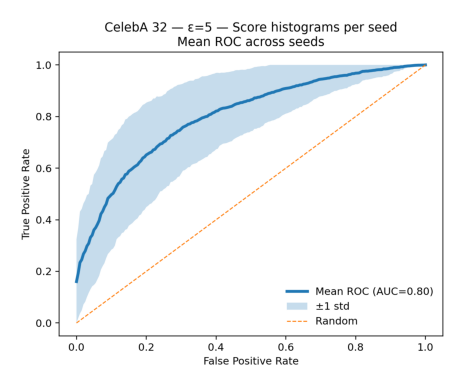

Histogram for different seeds


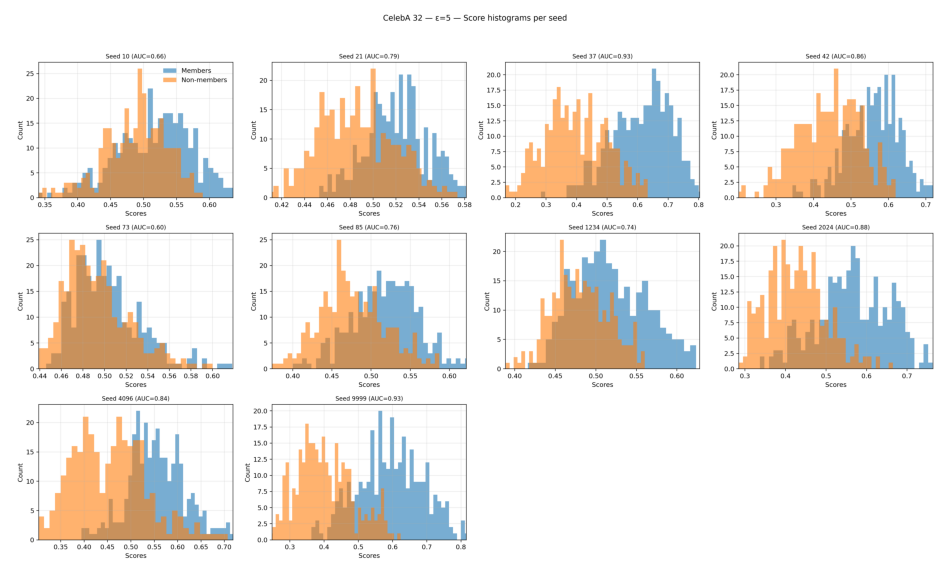

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print("Median in ROC-AUC Curve")
img = mpimg.imread('Celeba32_Eps5_BB_ROC_Curve_overlay.png')
plt.imshow(img)
plt.axis('off')  # Hide axis ticks
plt.show()
print("Mean & STD in ROC-AUC Curve")
img1 = mpimg.imread('Celeba32_Eps5_BB_ROC_Curve_mean.png')
plt.imshow(img1)
plt.axis('off')  # Hide axis ticks
plt.show()
print("Histogram for different seeds")
img2 = mpimg.imread('Celeba32_Eps5_BB_Histogram.png')
plt.figure(figsize=(12, 8))
plt.imshow(img2)
plt.axis('off')  # Hide axis ticks
plt.show()



In [18]:
import os
import math
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import lpips
import clip
import pandas as pd

# --- plotting (headless-safe) ---
import matplotlib
matplotlib.use("Agg")  # safe on servers without display
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
SEEDS = [10, 21, 37, 42, 73, 85, 1234, 2024, 4096, 9999]
N_MEM, N_NONMEM, N_GEN = 100, 100, 1000  # images per seed

# data paths (update if needed)
MEMBERS_DIR    = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train"
NONMEMBERS_DIR = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test"
GEN_DIR        = "Generated Images/samples_celeba32_eps10"

# ---- hard-coded titles / name stem ----
FIG_TITLE = "CelebA 32 — ε=10 — Score histograms per seed"
FILE_STEM = "Celeba32_Eps10_BB"   # final files: <stem>_Histogram.png, _ROC_Curve_mean.png, _ROC_Curve_overlay.png

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
print(f"Using device: {device}")

# -----------------------------
# UTILITIES
# -----------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_image_paths(folder, exts={".png", ".jpg", ".jpeg"}):
    return [os.path.join(folder, f) for f in os.listdir(folder)
            if os.path.splitext(f)[1].lower() in exts]

# models
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
lpips_model = lpips.LPIPS(net="alex").to(device)

def load_image_for_clip(path):
    return clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)

def load_image_for_lpips(path):
    img = Image.open(path).convert("RGB").resize((224, 224))
    t = (torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255.).unsqueeze(0)
    t = (t - 0.5) * 2
    return t.to(device)

@torch.no_grad()
def extract_clip_feature(path):
    img = load_image_for_clip(path)
    feat = clip_model.encode_image(img)
    feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

@torch.no_grad()
def lpips_distance(p1, p2):
    return lpips_model(load_image_for_lpips(p1), load_image_for_lpips(p2)).item()

def cosine_similarity(gen_feat, ref_feats):
    g = torch.tensor(gen_feat).unsqueeze(0)
    r = torch.tensor(ref_feats)
    g = F.normalize(g, dim=1); r = F.normalize(r, dim=1)
    return (r @ g.T).squeeze(1).numpy()

def lpips_distances(gen_path, ref_paths):
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])

def stats(arr):
    return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

# -----------------------------
# LOAD PATH LISTS
# -----------------------------
members_all    = get_image_paths(MEMBERS_DIR)
nonmembers_all = get_image_paths(NONMEMBERS_DIR)
generated_all  = get_image_paths(GEN_DIR)

print(f"Pool sizes — members: {len(members_all)}, non-members: {len(nonmembers_all)}, generated: {len(generated_all)}")

# -----------------------------
# RUN EXPERIMENT OVER SEEDS
# -----------------------------
seed_rows = []
roc_curves = []  # store fpr/tpr/auc per seed for overlay figure

# Collect per-seed score distributions for final grid
all_probs_mem_by_seed = []
all_probs_nonmem_by_seed = []
aucs_by_seed = []
seeds_in_order = []

for seed in SEEDS:
    print(f"\n=== Seed {seed} ===")
    set_seed(seed)

    # fresh sample for each seed
    mem_paths    = random.sample(members_all, N_MEM)
    nonmem_paths = random.sample(nonmembers_all, N_NONMEM)
    gen_paths    = random.sample(generated_all, N_GEN)

    # CLIP features (no batching)
    mem_clip    = torch.cat([extract_clip_feature(p) for p in tqdm(mem_paths, desc="CLIP members")], 0).numpy()
    nonmem_clip = torch.cat([extract_clip_feature(p) for p in tqdm(nonmem_paths, desc="CLIP non-members")], 0).numpy()
    gen_clip    = torch.cat([extract_clip_feature(p) for p in tqdm(gen_paths, desc="CLIP generated")], 0).numpy()

    # build features
    all_mem_features, all_nonmem_features = [], []
    for i, gen_path in enumerate(tqdm(gen_paths, desc="Features per generated")):
        cos_mem    = cosine_similarity(gen_clip[i], mem_clip)
        cos_nonmem = cosine_similarity(gen_clip[i], nonmem_clip)
        lp_mem     = lpips_distances(gen_path, mem_paths)
        lp_nonmem  = lpips_distances(gen_path, nonmem_paths)
        all_mem_features.append(stats(cos_mem) + stats(lp_mem))
        all_nonmem_features.append(stats(cos_nonmem) + stats(lp_nonmem))

    X = np.vstack([np.array(all_mem_features), np.array(all_nonmem_features)])
    y = np.array([1]*len(all_mem_features) + [0]*len(all_nonmem_features))

    # split/train/test
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, random_state=seed, stratify=y)
    clf = LogisticRegression(max_iter=500, random_state=seed)
    clf.fit(X_tr, y_tr)
    y_prob = clf.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, y_prob)

    # ROC for later fig
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    roc_curves.append({"seed": seed, "fpr": fpr, "tpr": tpr, "auc": auc})

    # per-seed score distributions
    all_probs_mem_by_seed.append(y_prob[y_te == 1])
    all_probs_nonmem_by_seed.append(y_prob[y_te == 0])
    aucs_by_seed.append(auc)
    seeds_in_order.append(seed)

    print(f"ROC-AUC (seed {seed}): {auc:.4f}")
    seed_rows.append({"seed": seed, "roc_auc": auc})

# -----------------------------
# SUMMARY
# -----------------------------
df = pd.DataFrame(seed_rows).sort_values("seed").reset_index(drop=True)
print("\nPer-seed ROC-AUCs:")
print(df.to_string(index=False, formatters={"roc_auc": lambda x: f"{x:.4f}"}))

aucs = df["roc_auc"].to_numpy()
mean_auc = aucs.mean()
std_auc  = aucs.std(ddof=1)

print("\n=== Summary over seeds ===")
print(f"Mean ROC-AUC: {mean_auc:.4f}")
print(f"Std  ROC-AUC: {std_auc:.4f}")

df.to_csv(f"{FILE_STEM}_seed_results.csv", index=False)
print(f"\nSaved per-seed results to: {FILE_STEM}_seed_results.csv")

# -----------------------------
# FINAL CONSOLIDATED FIGURES
# -----------------------------

# (1) Consolidated histogram grid (counts, per-seed, auto-zoomed)
n = len(seeds_in_order)
ncols = 4
nrows = math.ceil(n / ncols)
BINS  = 40

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = np.array(axes).reshape(-1)

for i, seed in enumerate(seeds_in_order):
    ax  = axes[i]
    mem = np.asarray(all_probs_mem_by_seed[i])
    non = np.asarray(all_probs_nonmem_by_seed[i])

    ax.hist(mem, bins=BINS, alpha=0.6, label="Members")
    ax.hist(non, bins=BINS, alpha=0.6, label="Non-members")

    # zoom to central 99% to make separation visible
    lo, hi = np.percentile(np.r_[mem, non], [0.5, 99.5])
    pad = 0.02 * (hi - lo + 1e-12)
    ax.set_xlim(lo - pad, hi + pad)

    ax.set_title(f"Seed {seed} (AUC={aucs_by_seed[i]:.2f})", fontsize=9)
    ax.set_xlabel("Scores")
    ax.set_ylabel("Count")
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(frameon=False)

# hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.suptitle(FIG_TITLE, y=0.99, fontsize=12)
plt.tight_layout(rect=[0,0,1,0.96])
out_hist = f"{FILE_STEM}_Histogram.png"
plt.savefig(out_hist, dpi=220)
plt.show()
plt.close()
print(f"Saved consolidated histogram grid: {out_hist}")

# (2A) Mean ROC + ±1σ band (single clean curve)
fpr_grid = np.linspace(0.0, 1.0, 201)
tprs_interp = np.array([np.interp(fpr_grid, r["fpr"], r["tpr"]) for r in roc_curves])

mean_tpr = tprs_interp.mean(axis=0)
std_tpr  = tprs_interp.std(axis=0, ddof=1)
lower = np.clip(mean_tpr - std_tpr, 0, 1)
upper = np.clip(mean_tpr + std_tpr, 0, 1)

plt.figure(figsize=(6,5))
plt.plot(fpr_grid, mean_tpr, linewidth=2.8, label=f"Mean ROC (AUC={mean_auc:.2f})")
plt.fill_between(fpr_grid, lower, upper, alpha=0.25, label="±1 std")
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nMean ROC across seeds")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
out_mean = f"{FILE_STEM}_ROC_Curve_mean.png"
plt.savefig(out_mean, dpi=220)
plt.show()
plt.close()
print(f"Saved mean ROC with band: {out_mean}")

# (2B) Overlay all ROCs, highlight median-AUC seed
median_idx = np.argsort(aucs)[len(aucs)//2]
highlight_seed = int(df.loc[median_idx, "seed"])

plt.figure(figsize=(6,5))
for r in roc_curves:
    lw = 1.0
    alpha = 0.20
    if r["seed"] == highlight_seed:
        lw = 2.8
        alpha = 0.95
    plt.plot(r["fpr"], r["tpr"], linewidth=lw, alpha=alpha,
             label=(f"seed {r['seed']} (AUC={r['auc']:.2f})" if r["seed"] == highlight_seed else None))
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nROC curves (median seed highlighted)")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
out_overlay = f"{FILE_STEM}_ROC_Curve_overlay.png"
plt.savefig(out_overlay, dpi=220)
plt.show()
plt.close()
print(f"Saved consolidated ROC overlay: {out_overlay}")


Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Pool sizes — members: 162079, non-members: 40520, generated: 60000

=== Seed 10 ===


Features per generated: 100%|██████████| 1000/1000 [13:31<00:00,  1.23it/s]


ROC-AUC (seed 10): 0.6537

=== Seed 21 ===


Features per generated: 100%|██████████| 1000/1000 [13:32<00:00,  1.23it/s]


ROC-AUC (seed 21): 0.7880

=== Seed 37 ===


Features per generated: 100%|██████████| 1000/1000 [13:34<00:00,  1.23it/s]


ROC-AUC (seed 37): 0.9280

=== Seed 42 ===


Features per generated: 100%|██████████| 1000/1000 [13:32<00:00,  1.23it/s]


ROC-AUC (seed 42): 0.8593

=== Seed 73 ===


Features per generated: 100%|██████████| 1000/1000 [13:32<00:00,  1.23it/s]


ROC-AUC (seed 73): 0.6035

=== Seed 85 ===


Features per generated: 100%|██████████| 1000/1000 [13:34<00:00,  1.23it/s]


ROC-AUC (seed 85): 0.7708

=== Seed 1234 ===


Features per generated: 100%|██████████| 1000/1000 [13:32<00:00,  1.23it/s]


ROC-AUC (seed 1234): 0.7302

=== Seed 2024 ===


Features per generated: 100%|██████████| 1000/1000 [13:33<00:00,  1.23it/s]


ROC-AUC (seed 2024): 0.8763

=== Seed 4096 ===


Features per generated: 100%|██████████| 1000/1000 [13:32<00:00,  1.23it/s]


ROC-AUC (seed 4096): 0.8416

=== Seed 9999 ===


Features per generated: 100%|██████████| 1000/1000 [13:31<00:00,  1.23it/s]


ROC-AUC (seed 9999): 0.9272

Per-seed ROC-AUCs:
 seed roc_auc
   10  0.6537
   21  0.7880
   37  0.9280
   42  0.8593
   73  0.6035
   85  0.7708
 1234  0.7302
 2024  0.8763
 4096  0.8416
 9999  0.9272

=== Summary over seeds ===
Mean ROC-AUC: 0.7979
Std  ROC-AUC: 0.1103

Saved per-seed results to: Celeba32_Eps10_BB_seed_results.csv
Saved consolidated histogram grid: Celeba32_Eps10_BB_Histogram.png
Saved mean ROC with band: Celeba32_Eps10_BB_ROC_Curve_mean.png
Saved consolidated ROC overlay: Celeba32_Eps10_BB_ROC_Curve_overlay.png


Median in ROC-AUC Curve


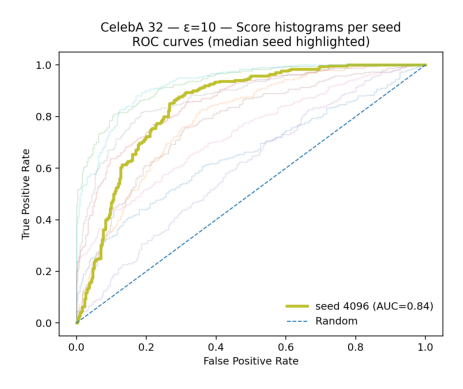

Mean & STD in ROC-AUC Curve


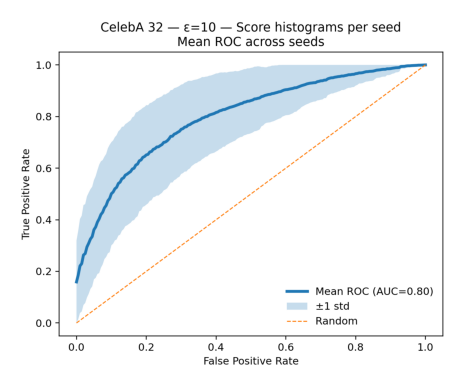

Histogram for different seeds


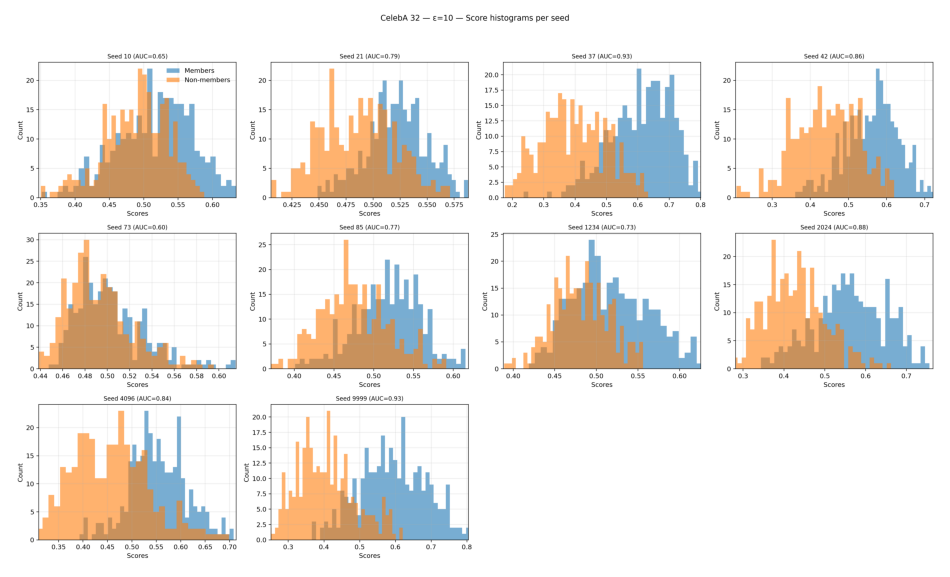

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print("Median in ROC-AUC Curve")
img = mpimg.imread('Celeba32_Eps10_BB_ROC_Curve_overlay.png')
plt.imshow(img)
plt.axis('off')  # Hide axis ticks
plt.show()

print("Mean & STD in ROC-AUC Curve")
img1 = mpimg.imread('Celeba32_Eps10_BB_ROC_Curve_mean.png')
plt.imshow(img1)
plt.axis('off')  # Hide axis ticks
plt.show()

print("Histogram for different seeds")
img2 = mpimg.imread('Celeba32_Eps10_BB_Histogram.png')
plt.figure(figsize=(12, 8))
plt.imshow(img2)
plt.axis('off')  # Hide axis ticks
plt.show()

## Black Box Attack(CLIP & LPIP) on CelebA 64(Eps 1, 5 & 10) with Median of 10 Random seed with Visuals
We have tested the Black box using CLIP Feature and LPIP distance for Random seed 1234 & 42 which resulted in fluctuation due to randomness in picking inputs for attack.  


So we decided to do a minimal attack of 100 Member & 100 Non Member against 1000 Generated Images with 10 different random seeds(10 set if this attack) and getting a median of them to get better understanding of privacy leakage across random seeds

Seeds used - [10, 21, 37, 42, 73, 85, 1234, 2024, 4096, 9999]

In [19]:
import os
import math
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import lpips
import clip
import pandas as pd

# --- plotting (headless-safe) ---
import matplotlib
matplotlib.use("Agg")  # safe on servers without display
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
SEEDS = [10, 21, 37, 42, 73, 85, 1234, 2024, 4096, 9999]
N_MEM, N_NONMEM, N_GEN = 100, 100, 1000  # images per seed

# data paths (update if needed)
MEMBERS_DIR    = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train"
NONMEMBERS_DIR = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test"
GEN_DIR        = "Generated Images/samples_celeba64_eps1"

# ---- hard-coded titles / name stem ----
FIG_TITLE = "CelebA 64 — ε=1 — Score histograms per seed"
FILE_STEM = "Celeba64_Eps1_BB"   # final files: <stem>_Histogram.png, _ROC_Curve_mean.png, _ROC_Curve_overlay.png

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
print(f"Using device: {device}")

# -----------------------------
# UTILITIES
# -----------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_image_paths(folder, exts={".png", ".jpg", ".jpeg"}):
    return [os.path.join(folder, f) for f in os.listdir(folder)
            if os.path.splitext(f)[1].lower() in exts]

# models
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
lpips_model = lpips.LPIPS(net="alex").to(device)

def load_image_for_clip(path):
    return clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)

def load_image_for_lpips(path):
    img = Image.open(path).convert("RGB").resize((224, 224))
    t = (torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255.).unsqueeze(0)
    t = (t - 0.5) * 2
    return t.to(device)

@torch.no_grad()
def extract_clip_feature(path):
    img = load_image_for_clip(path)
    feat = clip_model.encode_image(img)
    feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

@torch.no_grad()
def lpips_distance(p1, p2):
    return lpips_model(load_image_for_lpips(p1), load_image_for_lpips(p2)).item()

def cosine_similarity(gen_feat, ref_feats):
    g = torch.tensor(gen_feat).unsqueeze(0)
    r = torch.tensor(ref_feats)
    g = F.normalize(g, dim=1); r = F.normalize(r, dim=1)
    return (r @ g.T).squeeze(1).numpy()

def lpips_distances(gen_path, ref_paths):
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])

def stats(arr):
    return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

# -----------------------------
# LOAD PATH LISTS
# -----------------------------
members_all    = get_image_paths(MEMBERS_DIR)
nonmembers_all = get_image_paths(NONMEMBERS_DIR)
generated_all  = get_image_paths(GEN_DIR)

print(f"Pool sizes — members: {len(members_all)}, non-members: {len(nonmembers_all)}, generated: {len(generated_all)}")

# -----------------------------
# RUN EXPERIMENT OVER SEEDS
# -----------------------------
seed_rows = []
roc_curves = []  # store fpr/tpr/auc per seed for overlay figure

# Collect per-seed score distributions for final grid
all_probs_mem_by_seed = []
all_probs_nonmem_by_seed = []
aucs_by_seed = []
seeds_in_order = []

for seed in SEEDS:
    print(f"\n=== Seed {seed} ===")
    set_seed(seed)

    # fresh sample for each seed
    mem_paths    = random.sample(members_all, N_MEM)
    nonmem_paths = random.sample(nonmembers_all, N_NONMEM)
    gen_paths    = random.sample(generated_all, N_GEN)

    # CLIP features (no batching)
    mem_clip    = torch.cat([extract_clip_feature(p) for p in tqdm(mem_paths, desc="CLIP members")], 0).numpy()
    nonmem_clip = torch.cat([extract_clip_feature(p) for p in tqdm(nonmem_paths, desc="CLIP non-members")], 0).numpy()
    gen_clip    = torch.cat([extract_clip_feature(p) for p in tqdm(gen_paths, desc="CLIP generated")], 0).numpy()

    # build features
    all_mem_features, all_nonmem_features = [], []
    for i, gen_path in enumerate(tqdm(gen_paths, desc="Features per generated")):
        cos_mem    = cosine_similarity(gen_clip[i], mem_clip)
        cos_nonmem = cosine_similarity(gen_clip[i], nonmem_clip)
        lp_mem     = lpips_distances(gen_path, mem_paths)
        lp_nonmem  = lpips_distances(gen_path, nonmem_paths)
        all_mem_features.append(stats(cos_mem) + stats(lp_mem))
        all_nonmem_features.append(stats(cos_nonmem) + stats(lp_nonmem))

    X = np.vstack([np.array(all_mem_features), np.array(all_nonmem_features)])
    y = np.array([1]*len(all_mem_features) + [0]*len(all_nonmem_features))

    # split/train/test
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, random_state=seed, stratify=y)
    clf = LogisticRegression(max_iter=500, random_state=seed)
    clf.fit(X_tr, y_tr)
    y_prob = clf.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, y_prob)

    # ROC for later fig
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    roc_curves.append({"seed": seed, "fpr": fpr, "tpr": tpr, "auc": auc})

    # per-seed score distributions
    all_probs_mem_by_seed.append(y_prob[y_te == 1])
    all_probs_nonmem_by_seed.append(y_prob[y_te == 0])
    aucs_by_seed.append(auc)
    seeds_in_order.append(seed)

    print(f"ROC-AUC (seed {seed}): {auc:.4f}")
    seed_rows.append({"seed": seed, "roc_auc": auc})

# -----------------------------
# SUMMARY
# -----------------------------
df = pd.DataFrame(seed_rows).sort_values("seed").reset_index(drop=True)
print("\nPer-seed ROC-AUCs:")
print(df.to_string(index=False, formatters={"roc_auc": lambda x: f"{x:.4f}"}))

aucs = df["roc_auc"].to_numpy()
mean_auc = aucs.mean()
std_auc  = aucs.std(ddof=1)

print("\n=== Summary over seeds ===")
print(f"Mean ROC-AUC: {mean_auc:.4f}")
print(f"Std  ROC-AUC: {std_auc:.4f}")

df.to_csv(f"{FILE_STEM}_seed_results.csv", index=False)
print(f"\nSaved per-seed results to: {FILE_STEM}_seed_results.csv")

# -----------------------------
# FINAL CONSOLIDATED FIGURES
# -----------------------------

# (1) Consolidated histogram grid (counts, per-seed, auto-zoomed)
n = len(seeds_in_order)
ncols = 4
nrows = math.ceil(n / ncols)
BINS  = 40

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = np.array(axes).reshape(-1)

for i, seed in enumerate(seeds_in_order):
    ax  = axes[i]
    mem = np.asarray(all_probs_mem_by_seed[i])
    non = np.asarray(all_probs_nonmem_by_seed[i])

    ax.hist(mem, bins=BINS, alpha=0.6, label="Members")
    ax.hist(non, bins=BINS, alpha=0.6, label="Non-members")

    # zoom to central 99% to make separation visible
    lo, hi = np.percentile(np.r_[mem, non], [0.5, 99.5])
    pad = 0.02 * (hi - lo + 1e-12)
    ax.set_xlim(lo - pad, hi + pad)

    ax.set_title(f"Seed {seed} (AUC={aucs_by_seed[i]:.2f})", fontsize=9)
    ax.set_xlabel("Scores")
    ax.set_ylabel("Count")
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(frameon=False)

# hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.suptitle(FIG_TITLE, y=0.99, fontsize=12)
plt.tight_layout(rect=[0,0,1,0.96])
out_hist = f"{FILE_STEM}_Histogram.png"
plt.savefig(out_hist, dpi=220)
plt.show()
plt.close()
print(f"Saved consolidated histogram grid: {out_hist}")

# (2A) Mean ROC + ±1σ band (single clean curve)
fpr_grid = np.linspace(0.0, 1.0, 201)
tprs_interp = np.array([np.interp(fpr_grid, r["fpr"], r["tpr"]) for r in roc_curves])

mean_tpr = tprs_interp.mean(axis=0)
std_tpr  = tprs_interp.std(axis=0, ddof=1)
lower = np.clip(mean_tpr - std_tpr, 0, 1)
upper = np.clip(mean_tpr + std_tpr, 0, 1)

plt.figure(figsize=(6,5))
plt.plot(fpr_grid, mean_tpr, linewidth=2.8, label=f"Mean ROC (AUC={mean_auc:.2f})")
plt.fill_between(fpr_grid, lower, upper, alpha=0.25, label="±1 std")
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nMean ROC across seeds")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
out_mean = f"{FILE_STEM}_ROC_Curve_mean.png"
plt.savefig(out_mean, dpi=220)
plt.show()
plt.close()
print(f"Saved mean ROC with band: {out_mean}")

# (2B) Overlay all ROCs, highlight median-AUC seed
median_idx = np.argsort(aucs)[len(aucs)//2]
highlight_seed = int(df.loc[median_idx, "seed"])

plt.figure(figsize=(6,5))
for r in roc_curves:
    lw = 1.0
    alpha = 0.20
    if r["seed"] == highlight_seed:
        lw = 2.8
        alpha = 0.95
    plt.plot(r["fpr"], r["tpr"], linewidth=lw, alpha=alpha,
             label=(f"seed {r['seed']} (AUC={r['auc']:.2f})" if r["seed"] == highlight_seed else None))
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nROC curves (median seed highlighted)")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
out_overlay = f"{FILE_STEM}_ROC_Curve_overlay.png"
plt.savefig(out_overlay, dpi=220)
plt.show()
plt.close()
print(f"Saved consolidated ROC overlay: {out_overlay}")


Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Pool sizes — members: 162079, non-members: 40520, generated: 60000

=== Seed 10 ===


Features per generated: 100%|██████████| 1000/1000 [14:40<00:00,  1.14it/s]


ROC-AUC (seed 10): 0.8465

=== Seed 21 ===


Features per generated: 100%|██████████| 1000/1000 [14:41<00:00,  1.13it/s]


ROC-AUC (seed 21): 0.7280

=== Seed 37 ===


Features per generated: 100%|██████████| 1000/1000 [14:41<00:00,  1.13it/s]


ROC-AUC (seed 37): 0.9278

=== Seed 42 ===


Features per generated: 100%|██████████| 1000/1000 [14:40<00:00,  1.14it/s]


ROC-AUC (seed 42): 0.6958

=== Seed 73 ===


Features per generated: 100%|██████████| 1000/1000 [14:41<00:00,  1.14it/s]


ROC-AUC (seed 73): 0.8130

=== Seed 85 ===


Features per generated: 100%|██████████| 1000/1000 [14:40<00:00,  1.14it/s]


ROC-AUC (seed 85): 0.5931

=== Seed 1234 ===


Features per generated: 100%|██████████| 1000/1000 [14:38<00:00,  1.14it/s]


ROC-AUC (seed 1234): 0.9308

=== Seed 2024 ===


Features per generated: 100%|██████████| 1000/1000 [14:42<00:00,  1.13it/s]


ROC-AUC (seed 2024): 0.8960

=== Seed 4096 ===


Features per generated: 100%|██████████| 1000/1000 [14:40<00:00,  1.14it/s]


ROC-AUC (seed 4096): 0.9202

=== Seed 9999 ===


Features per generated: 100%|██████████| 1000/1000 [14:39<00:00,  1.14it/s]


ROC-AUC (seed 9999): 0.9035

Per-seed ROC-AUCs:
 seed roc_auc
   10  0.8465
   21  0.7280
   37  0.9278
   42  0.6958
   73  0.8130
   85  0.5931
 1234  0.9308
 2024  0.8960
 4096  0.9202
 9999  0.9035

=== Summary over seeds ===
Mean ROC-AUC: 0.8255
Std  ROC-AUC: 0.1167

Saved per-seed results to: Celeba64_Eps1_BB_seed_results.csv
Saved consolidated histogram grid: Celeba64_Eps1_BB_Histogram.png
Saved mean ROC with band: Celeba64_Eps1_BB_ROC_Curve_mean.png
Saved consolidated ROC overlay: Celeba64_Eps1_BB_ROC_Curve_overlay.png


Median in ROC-AUC Curve


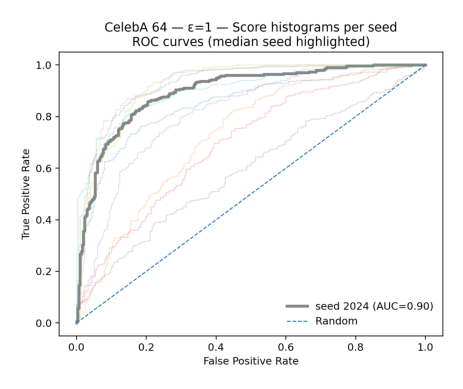

Mean & STD in ROC-AUC Curve


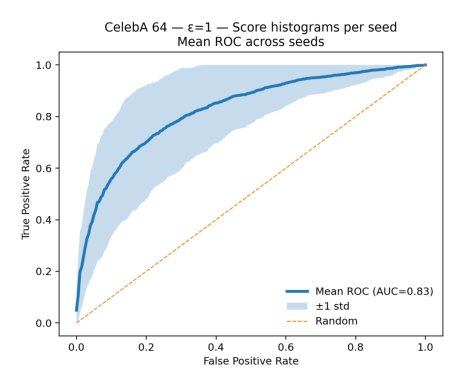

Histogram for different seeds


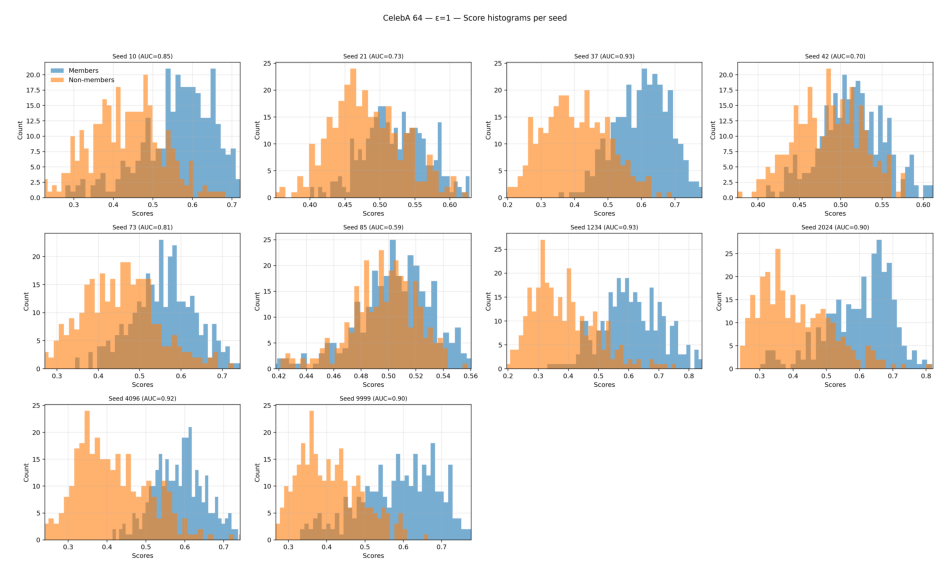

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print("Median in ROC-AUC Curve")
img = mpimg.imread('Celeba64_Eps1_BB_ROC_Curve_overlay.png')
plt.imshow(img)
plt.axis('off')  # Hide axis ticks
plt.show()

print("Mean & STD in ROC-AUC Curve")
img1 = mpimg.imread('Celeba64_Eps1_BB_ROC_Curve_mean.png')
plt.imshow(img1)
plt.axis('off')  # Hide axis ticks
plt.show()

print("Histogram for different seeds")
img2 = mpimg.imread('Celeba64_Eps1_BB_Histogram.png')
plt.figure(figsize=(12, 8))
plt.imshow(img2)
plt.axis('off')  # Hide axis ticks
plt.show()

In [2]:
import os
import math
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import lpips
import clip
import pandas as pd

# --- plotting (headless-safe) ---
import matplotlib
matplotlib.use("Agg")  # safe on servers without display
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
SEEDS = [10, 21, 37, 42, 73, 85, 1234, 2024, 4096, 9999]
N_MEM, N_NONMEM, N_GEN = 100, 100, 1000  # images per seed

# data paths (update if needed)
MEMBERS_DIR    = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train"
NONMEMBERS_DIR = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test"
GEN_DIR        = "Generated Images/samples_celeba64_eps5"

# ---- hard-coded titles / name stem ----
FIG_TITLE = "CelebA 64 — ε=5 — Score histograms per seed"
FILE_STEM = "Celeba64_Eps5_BB"   # final files: <stem>_Histogram.png, _ROC_Curve_mean.png, _ROC_Curve_overlay.png

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
print(f"Using device: {device}")

# -----------------------------
# UTILITIES
# -----------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_image_paths(folder, exts={".png", ".jpg", ".jpeg"}):
    return [os.path.join(folder, f) for f in os.listdir(folder)
            if os.path.splitext(f)[1].lower() in exts]

# models
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
lpips_model = lpips.LPIPS(net="alex").to(device)

def load_image_for_clip(path):
    return clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)

def load_image_for_lpips(path):
    img = Image.open(path).convert("RGB").resize((224, 224))
    t = (torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255.).unsqueeze(0)
    t = (t - 0.5) * 2
    return t.to(device)

@torch.no_grad()
def extract_clip_feature(path):
    img = load_image_for_clip(path)
    feat = clip_model.encode_image(img)
    feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

@torch.no_grad()
def lpips_distance(p1, p2):
    return lpips_model(load_image_for_lpips(p1), load_image_for_lpips(p2)).item()

def cosine_similarity(gen_feat, ref_feats):
    g = torch.tensor(gen_feat).unsqueeze(0)
    r = torch.tensor(ref_feats)
    g = F.normalize(g, dim=1); r = F.normalize(r, dim=1)
    return (r @ g.T).squeeze(1).numpy()

def lpips_distances(gen_path, ref_paths):
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])

def stats(arr):
    return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

# -----------------------------
# LOAD PATH LISTS
# -----------------------------
members_all    = get_image_paths(MEMBERS_DIR)
nonmembers_all = get_image_paths(NONMEMBERS_DIR)
generated_all  = get_image_paths(GEN_DIR)

print(f"Pool sizes — members: {len(members_all)}, non-members: {len(nonmembers_all)}, generated: {len(generated_all)}")

# -----------------------------
# RUN EXPERIMENT OVER SEEDS
# -----------------------------
seed_rows = []
roc_curves = []  # store fpr/tpr/auc per seed for overlay figure

# Collect per-seed score distributions for final grid
all_probs_mem_by_seed = []
all_probs_nonmem_by_seed = []
aucs_by_seed = []
seeds_in_order = []

for seed in SEEDS:
    print(f"\n=== Seed {seed} ===")
    set_seed(seed)

    # fresh sample for each seed
    mem_paths    = random.sample(members_all, N_MEM)
    nonmem_paths = random.sample(nonmembers_all, N_NONMEM)
    gen_paths    = random.sample(generated_all, N_GEN)

    # CLIP features (no batching)
    mem_clip    = torch.cat([extract_clip_feature(p) for p in tqdm(mem_paths, desc="CLIP members")], 0).numpy()
    nonmem_clip = torch.cat([extract_clip_feature(p) for p in tqdm(nonmem_paths, desc="CLIP non-members")], 0).numpy()
    gen_clip    = torch.cat([extract_clip_feature(p) for p in tqdm(gen_paths, desc="CLIP generated")], 0).numpy()

    # build features
    all_mem_features, all_nonmem_features = [], []
    for i, gen_path in enumerate(tqdm(gen_paths, desc="Features per generated")):
        cos_mem    = cosine_similarity(gen_clip[i], mem_clip)
        cos_nonmem = cosine_similarity(gen_clip[i], nonmem_clip)
        lp_mem     = lpips_distances(gen_path, mem_paths)
        lp_nonmem  = lpips_distances(gen_path, nonmem_paths)
        all_mem_features.append(stats(cos_mem) + stats(lp_mem))
        all_nonmem_features.append(stats(cos_nonmem) + stats(lp_nonmem))

    X = np.vstack([np.array(all_mem_features), np.array(all_nonmem_features)])
    y = np.array([1]*len(all_mem_features) + [0]*len(all_nonmem_features))

    # split/train/test
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, random_state=seed, stratify=y)
    clf = LogisticRegression(max_iter=500, random_state=seed)
    clf.fit(X_tr, y_tr)
    y_prob = clf.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, y_prob)

    # ROC for later fig
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    roc_curves.append({"seed": seed, "fpr": fpr, "tpr": tpr, "auc": auc})

    # per-seed score distributions
    all_probs_mem_by_seed.append(y_prob[y_te == 1])
    all_probs_nonmem_by_seed.append(y_prob[y_te == 0])
    aucs_by_seed.append(auc)
    seeds_in_order.append(seed)

    print(f"ROC-AUC (seed {seed}): {auc:.4f}")
    seed_rows.append({"seed": seed, "roc_auc": auc})

# -----------------------------
# SUMMARY
# -----------------------------
df = pd.DataFrame(seed_rows).sort_values("seed").reset_index(drop=True)
print("\nPer-seed ROC-AUCs:")
print(df.to_string(index=False, formatters={"roc_auc": lambda x: f"{x:.4f}"}))

aucs = df["roc_auc"].to_numpy()
mean_auc = aucs.mean()
std_auc  = aucs.std(ddof=1)

print("\n=== Summary over seeds ===")
print(f"Mean ROC-AUC: {mean_auc:.4f}")
print(f"Std  ROC-AUC: {std_auc:.4f}")

df.to_csv(f"{FILE_STEM}_seed_results.csv", index=False)
print(f"\nSaved per-seed results to: {FILE_STEM}_seed_results.csv")

# -----------------------------
# FINAL CONSOLIDATED FIGURES
# -----------------------------

# (1) Consolidated histogram grid (counts, per-seed, auto-zoomed)
n = len(seeds_in_order)
ncols = 4
nrows = math.ceil(n / ncols)
BINS  = 40

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = np.array(axes).reshape(-1)

for i, seed in enumerate(seeds_in_order):
    ax  = axes[i]
    mem = np.asarray(all_probs_mem_by_seed[i])
    non = np.asarray(all_probs_nonmem_by_seed[i])

    ax.hist(mem, bins=BINS, alpha=0.6, label="Members")
    ax.hist(non, bins=BINS, alpha=0.6, label="Non-members")

    # zoom to central 99% to make separation visible
    lo, hi = np.percentile(np.r_[mem, non], [0.5, 99.5])
    pad = 0.02 * (hi - lo + 1e-12)
    ax.set_xlim(lo - pad, hi + pad)

    ax.set_title(f"Seed {seed} (AUC={aucs_by_seed[i]:.2f})", fontsize=9)
    ax.set_xlabel("Scores")
    ax.set_ylabel("Count")
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(frameon=False)

# hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.suptitle(FIG_TITLE, y=0.99, fontsize=12)
plt.tight_layout(rect=[0,0,1,0.96])
out_hist = f"{FILE_STEM}_Histogram.png"
plt.savefig(out_hist, dpi=220)
plt.show()
plt.close()
print(f"Saved consolidated histogram grid: {out_hist}")

# (2A) Mean ROC + ±1σ band (single clean curve)
fpr_grid = np.linspace(0.0, 1.0, 201)
tprs_interp = np.array([np.interp(fpr_grid, r["fpr"], r["tpr"]) for r in roc_curves])

mean_tpr = tprs_interp.mean(axis=0)
std_tpr  = tprs_interp.std(axis=0, ddof=1)
lower = np.clip(mean_tpr - std_tpr, 0, 1)
upper = np.clip(mean_tpr + std_tpr, 0, 1)

plt.figure(figsize=(6,5))
plt.plot(fpr_grid, mean_tpr, linewidth=2.8, label=f"Mean ROC (AUC={mean_auc:.2f})")
plt.fill_between(fpr_grid, lower, upper, alpha=0.25, label="±1 std")
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nMean ROC across seeds")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
out_mean = f"{FILE_STEM}_ROC_Curve_mean.png"
plt.savefig(out_mean, dpi=220)
plt.show()
plt.close()
print(f"Saved mean ROC with band: {out_mean}")

# (2B) Overlay all ROCs, highlight median-AUC seed
median_idx = np.argsort(aucs)[len(aucs)//2]
highlight_seed = int(df.loc[median_idx, "seed"])

plt.figure(figsize=(6,5))
for r in roc_curves:
    lw = 1.0
    alpha = 0.20
    if r["seed"] == highlight_seed:
        lw = 2.8
        alpha = 0.95
    plt.plot(r["fpr"], r["tpr"], linewidth=lw, alpha=alpha,
             label=(f"seed {r['seed']} (AUC={r['auc']:.2f})" if r["seed"] == highlight_seed else None))
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nROC curves (median seed highlighted)")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
out_overlay = f"{FILE_STEM}_ROC_Curve_overlay.png"
plt.savefig(out_overlay, dpi=220)
plt.show()
plt.close()
print(f"Saved consolidated ROC overlay: {out_overlay}")


Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Pool sizes — members: 162079, non-members: 40520, generated: 60000

=== Seed 10 ===


Features per generated: 100%|██████████| 1000/1000 [14:26<00:00,  1.15it/s]


ROC-AUC (seed 10): 0.7934

=== Seed 21 ===


Features per generated: 100%|██████████| 1000/1000 [14:24<00:00,  1.16it/s]


ROC-AUC (seed 21): 0.7685

=== Seed 37 ===


Features per generated: 100%|██████████| 1000/1000 [14:33<00:00,  1.15it/s]


ROC-AUC (seed 37): 0.8480

=== Seed 42 ===


Features per generated: 100%|██████████| 1000/1000 [14:30<00:00,  1.15it/s]


ROC-AUC (seed 42): 0.6490

=== Seed 73 ===


Features per generated: 100%|██████████| 1000/1000 [14:28<00:00,  1.15it/s]


ROC-AUC (seed 73): 0.7697

=== Seed 85 ===


Features per generated: 100%|██████████| 1000/1000 [14:28<00:00,  1.15it/s]


ROC-AUC (seed 85): 0.5843

=== Seed 1234 ===


Features per generated: 100%|██████████| 1000/1000 [14:22<00:00,  1.16it/s]


ROC-AUC (seed 1234): 0.9033

=== Seed 2024 ===


Features per generated: 100%|██████████| 1000/1000 [14:15<00:00,  1.17it/s]


ROC-AUC (seed 2024): 0.8474

=== Seed 4096 ===


Features per generated: 100%|██████████| 1000/1000 [14:26<00:00,  1.15it/s]


ROC-AUC (seed 4096): 0.8934

=== Seed 9999 ===


Features per generated: 100%|██████████| 1000/1000 [14:25<00:00,  1.15it/s]


ROC-AUC (seed 9999): 0.8765

Per-seed ROC-AUCs:
 seed roc_auc
   10  0.7934
   21  0.7685
   37  0.8480
   42  0.6490
   73  0.7697
   85  0.5843
 1234  0.9033
 2024  0.8474
 4096  0.8934
 9999  0.8765

=== Summary over seeds ===
Mean ROC-AUC: 0.7933
Std  ROC-AUC: 0.1057

Saved per-seed results to: Celeba64_Eps5_BB_seed_results.csv
Saved consolidated histogram grid: Celeba64_Eps5_BB_Histogram.png
Saved mean ROC with band: Celeba64_Eps5_BB_ROC_Curve_mean.png
Saved consolidated ROC overlay: Celeba64_Eps5_BB_ROC_Curve_overlay.png


Median in ROC-AUC Curve


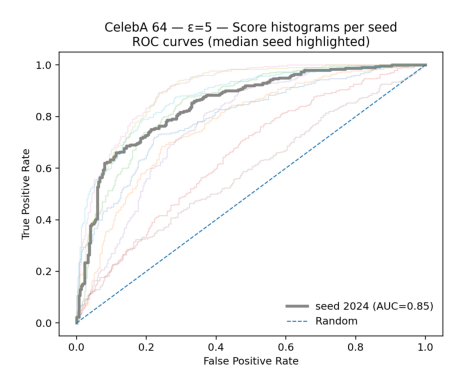

Mean & STD in ROC-AUC Curve


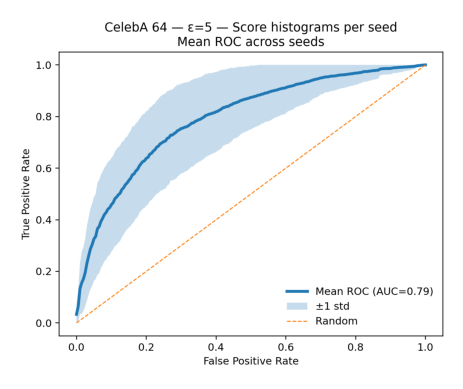

Histogram for different seeds


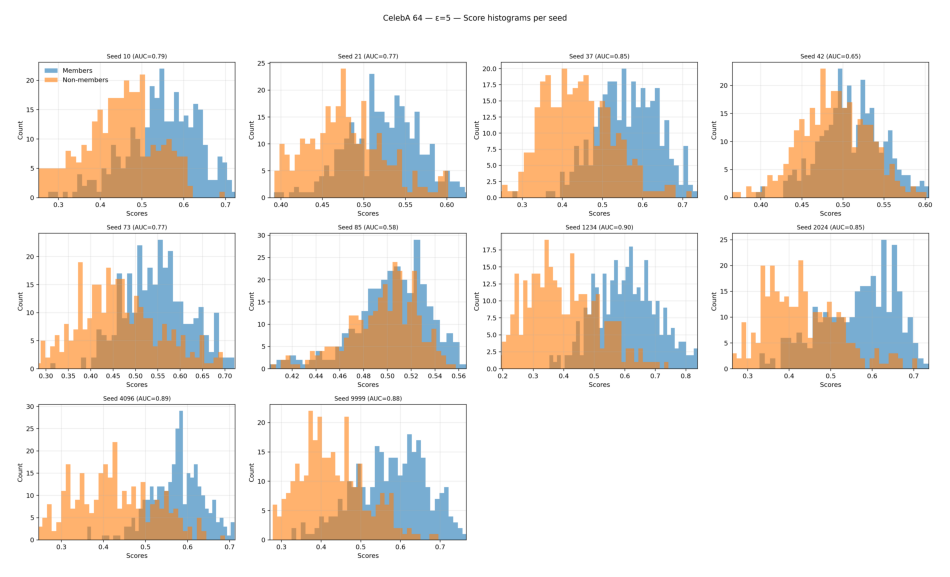

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print("Median in ROC-AUC Curve")
img = mpimg.imread('Celeba64_Eps5_BB_ROC_Curve_overlay.png')
plt.imshow(img)
plt.axis('off')  # Hide axis ticks
plt.show()

print("Mean & STD in ROC-AUC Curve")
img1 = mpimg.imread('Celeba64_Eps5_BB_ROC_Curve_mean.png')
plt.imshow(img1)
plt.axis('off')  # Hide axis ticks
plt.show()

print("Histogram for different seeds")
img2 = mpimg.imread('Celeba64_Eps5_BB_Histogram.png')
plt.figure(figsize=(12, 8))
plt.imshow(img2)
plt.axis('off')  # Hide axis ticks
plt.show()

In [3]:
import os
import math
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import lpips
import clip
import pandas as pd

# --- plotting (headless-safe) ---
import matplotlib
matplotlib.use("Agg")  # safe on servers without display
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
SEEDS = [10, 21, 37, 42, 73, 85, 1234, 2024, 4096, 9999]
N_MEM, N_NONMEM, N_GEN = 100, 100, 1000  # images per seed

# data paths (update if needed)
MEMBERS_DIR    = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train"
NONMEMBERS_DIR = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test"
GEN_DIR        = "Generated Images/samples_celeba64_eps10"

# ---- hard-coded titles / name stem ----
FIG_TITLE = "CelebA 64 — ε=10 — Score histograms per seed"
FILE_STEM = "Celeba64_Eps10_BB"   # final files: <stem>_Histogram.png, _ROC_Curve_mean.png, _ROC_Curve_overlay.png

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
print(f"Using device: {device}")

# -----------------------------
# UTILITIES
# -----------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_image_paths(folder, exts={".png", ".jpg", ".jpeg"}):
    return [os.path.join(folder, f) for f in os.listdir(folder)
            if os.path.splitext(f)[1].lower() in exts]

# models
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
lpips_model = lpips.LPIPS(net="alex").to(device)

def load_image_for_clip(path):
    return clip_preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)

def load_image_for_lpips(path):
    img = Image.open(path).convert("RGB").resize((224, 224))
    t = (torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255.).unsqueeze(0)
    t = (t - 0.5) * 2
    return t.to(device)

@torch.no_grad()
def extract_clip_feature(path):
    img = load_image_for_clip(path)
    feat = clip_model.encode_image(img)
    feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.cpu()

@torch.no_grad()
def lpips_distance(p1, p2):
    return lpips_model(load_image_for_lpips(p1), load_image_for_lpips(p2)).item()

def cosine_similarity(gen_feat, ref_feats):
    g = torch.tensor(gen_feat).unsqueeze(0)
    r = torch.tensor(ref_feats)
    g = F.normalize(g, dim=1); r = F.normalize(r, dim=1)
    return (r @ g.T).squeeze(1).numpy()

def lpips_distances(gen_path, ref_paths):
    return np.array([lpips_distance(gen_path, p) for p in ref_paths])

def stats(arr):
    return [arr.min(), arr.max(), arr.mean(), np.median(arr)]

# -----------------------------
# LOAD PATH LISTS
# -----------------------------
members_all    = get_image_paths(MEMBERS_DIR)
nonmembers_all = get_image_paths(NONMEMBERS_DIR)
generated_all  = get_image_paths(GEN_DIR)

print(f"Pool sizes — members: {len(members_all)}, non-members: {len(nonmembers_all)}, generated: {len(generated_all)}")

# -----------------------------
# RUN EXPERIMENT OVER SEEDS
# -----------------------------
seed_rows = []
roc_curves = []  # store fpr/tpr/auc per seed for overlay figure

# Collect per-seed score distributions for final grid
all_probs_mem_by_seed = []
all_probs_nonmem_by_seed = []
aucs_by_seed = []
seeds_in_order = []

for seed in SEEDS:
    print(f"\n=== Seed {seed} ===")
    set_seed(seed)

    # fresh sample for each seed
    mem_paths    = random.sample(members_all, N_MEM)
    nonmem_paths = random.sample(nonmembers_all, N_NONMEM)
    gen_paths    = random.sample(generated_all, N_GEN)

    # CLIP features (no batching)
    mem_clip    = torch.cat([extract_clip_feature(p) for p in tqdm(mem_paths, desc="CLIP members")], 0).numpy()
    nonmem_clip = torch.cat([extract_clip_feature(p) for p in tqdm(nonmem_paths, desc="CLIP non-members")], 0).numpy()
    gen_clip    = torch.cat([extract_clip_feature(p) for p in tqdm(gen_paths, desc="CLIP generated")], 0).numpy()

    # build features
    all_mem_features, all_nonmem_features = [], []
    for i, gen_path in enumerate(tqdm(gen_paths, desc="Features per generated")):
        cos_mem    = cosine_similarity(gen_clip[i], mem_clip)
        cos_nonmem = cosine_similarity(gen_clip[i], nonmem_clip)
        lp_mem     = lpips_distances(gen_path, mem_paths)
        lp_nonmem  = lpips_distances(gen_path, nonmem_paths)
        all_mem_features.append(stats(cos_mem) + stats(lp_mem))
        all_nonmem_features.append(stats(cos_nonmem) + stats(lp_nonmem))

    X = np.vstack([np.array(all_mem_features), np.array(all_nonmem_features)])
    y = np.array([1]*len(all_mem_features) + [0]*len(all_nonmem_features))

    # split/train/test
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, random_state=seed, stratify=y)
    clf = LogisticRegression(max_iter=500, random_state=seed)
    clf.fit(X_tr, y_tr)
    y_prob = clf.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, y_prob)

    # ROC for later fig
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    roc_curves.append({"seed": seed, "fpr": fpr, "tpr": tpr, "auc": auc})

    # per-seed score distributions
    all_probs_mem_by_seed.append(y_prob[y_te == 1])
    all_probs_nonmem_by_seed.append(y_prob[y_te == 0])
    aucs_by_seed.append(auc)
    seeds_in_order.append(seed)

    print(f"ROC-AUC (seed {seed}): {auc:.4f}")
    seed_rows.append({"seed": seed, "roc_auc": auc})

# -----------------------------
# SUMMARY
# -----------------------------
df = pd.DataFrame(seed_rows).sort_values("seed").reset_index(drop=True)
print("\nPer-seed ROC-AUCs:")
print(df.to_string(index=False, formatters={"roc_auc": lambda x: f"{x:.4f}"}))

aucs = df["roc_auc"].to_numpy()
mean_auc = aucs.mean()
std_auc  = aucs.std(ddof=1)

print("\n=== Summary over seeds ===")
print(f"Mean ROC-AUC: {mean_auc:.4f}")
print(f"Std  ROC-AUC: {std_auc:.4f}")

df.to_csv(f"{FILE_STEM}_seed_results.csv", index=False)
print(f"\nSaved per-seed results to: {FILE_STEM}_seed_results.csv")

# -----------------------------
# FINAL CONSOLIDATED FIGURES
# -----------------------------

# (1) Consolidated histogram grid (counts, per-seed, auto-zoomed)
n = len(seeds_in_order)
ncols = 4
nrows = math.ceil(n / ncols)
BINS  = 40

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = np.array(axes).reshape(-1)

for i, seed in enumerate(seeds_in_order):
    ax  = axes[i]
    mem = np.asarray(all_probs_mem_by_seed[i])
    non = np.asarray(all_probs_nonmem_by_seed[i])

    ax.hist(mem, bins=BINS, alpha=0.6, label="Members")
    ax.hist(non, bins=BINS, alpha=0.6, label="Non-members")

    # zoom to central 99% to make separation visible
    lo, hi = np.percentile(np.r_[mem, non], [0.5, 99.5])
    pad = 0.02 * (hi - lo + 1e-12)
    ax.set_xlim(lo - pad, hi + pad)

    ax.set_title(f"Seed {seed} (AUC={aucs_by_seed[i]:.2f})", fontsize=9)
    ax.set_xlabel("Scores")
    ax.set_ylabel("Count")
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(frameon=False)

# hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.suptitle(FIG_TITLE, y=0.99, fontsize=12)
plt.tight_layout(rect=[0,0,1,0.96])
out_hist = f"{FILE_STEM}_Histogram.png"
plt.savefig(out_hist, dpi=220)
plt.show()
plt.close()
print(f"Saved consolidated histogram grid: {out_hist}")

# (2A) Mean ROC + ±1σ band (single clean curve)
fpr_grid = np.linspace(0.0, 1.0, 201)
tprs_interp = np.array([np.interp(fpr_grid, r["fpr"], r["tpr"]) for r in roc_curves])

mean_tpr = tprs_interp.mean(axis=0)
std_tpr  = tprs_interp.std(axis=0, ddof=1)
lower = np.clip(mean_tpr - std_tpr, 0, 1)
upper = np.clip(mean_tpr + std_tpr, 0, 1)

plt.figure(figsize=(6,5))
plt.plot(fpr_grid, mean_tpr, linewidth=2.8, label=f"Mean ROC (AUC={mean_auc:.2f})")
plt.fill_between(fpr_grid, lower, upper, alpha=0.25, label="±1 std")
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nMean ROC across seeds")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
out_mean = f"{FILE_STEM}_ROC_Curve_mean.png"
plt.savefig(out_mean, dpi=220)
plt.show()
plt.close()
print(f"Saved mean ROC with band: {out_mean}")

# (2B) Overlay all ROCs, highlight median-AUC seed
median_idx = np.argsort(aucs)[len(aucs)//2]
highlight_seed = int(df.loc[median_idx, "seed"])

plt.figure(figsize=(6,5))
for r in roc_curves:
    lw = 1.0
    alpha = 0.20
    if r["seed"] == highlight_seed:
        lw = 2.8
        alpha = 0.95
    plt.plot(r["fpr"], r["tpr"], linewidth=lw, alpha=alpha,
             label=(f"seed {r['seed']} (AUC={r['auc']:.2f})" if r["seed"] == highlight_seed else None))
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"{FIG_TITLE}\nROC curves (median seed highlighted)")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
out_overlay = f"{FILE_STEM}_ROC_Curve_overlay.png"
plt.savefig(out_overlay, dpi=220)
plt.show()
plt.close()
print(f"Saved consolidated ROC overlay: {out_overlay}")


Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


/rds/homes/k/kxr414/.local/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_loc

Pool sizes — members: 162079, non-members: 40520, generated: 60000

=== Seed 10 ===


Features per generated: 100%|██████████| 1000/1000 [14:23<00:00,  1.16it/s]


ROC-AUC (seed 10): 0.8018

=== Seed 21 ===


Features per generated: 100%|██████████| 1000/1000 [14:26<00:00,  1.15it/s]


ROC-AUC (seed 21): 0.7581

=== Seed 37 ===


Features per generated: 100%|██████████| 1000/1000 [14:23<00:00,  1.16it/s]


ROC-AUC (seed 37): 0.8439

=== Seed 42 ===


Features per generated: 100%|██████████| 1000/1000 [14:22<00:00,  1.16it/s]


ROC-AUC (seed 42): 0.6456

=== Seed 73 ===


Features per generated: 100%|██████████| 1000/1000 [14:23<00:00,  1.16it/s]


ROC-AUC (seed 73): 0.7737

=== Seed 85 ===


Features per generated: 100%|██████████| 1000/1000 [14:25<00:00,  1.16it/s]


ROC-AUC (seed 85): 0.5907

=== Seed 1234 ===


Features per generated: 100%|██████████| 1000/1000 [14:27<00:00,  1.15it/s]


ROC-AUC (seed 1234): 0.9127

=== Seed 2024 ===


Features per generated: 100%|██████████| 1000/1000 [14:26<00:00,  1.15it/s]


ROC-AUC (seed 2024): 0.8340

=== Seed 4096 ===


Features per generated: 100%|██████████| 1000/1000 [14:29<00:00,  1.15it/s]


ROC-AUC (seed 4096): 0.9113

=== Seed 9999 ===


Features per generated: 100%|██████████| 1000/1000 [14:21<00:00,  1.16it/s]


ROC-AUC (seed 9999): 0.8647

Per-seed ROC-AUCs:
 seed roc_auc
   10  0.8018
   21  0.7581
   37  0.8439
   42  0.6456
   73  0.7737
   85  0.5907
 1234  0.9127
 2024  0.8340
 4096  0.9113
 9999  0.8647

=== Summary over seeds ===
Mean ROC-AUC: 0.7937
Std  ROC-AUC: 0.1065

Saved per-seed results to: Celeba64_Eps10_BB_seed_results.csv
Saved consolidated histogram grid: Celeba64_Eps10_BB_Histogram.png
Saved mean ROC with band: Celeba64_Eps10_BB_ROC_Curve_mean.png
Saved consolidated ROC overlay: Celeba64_Eps10_BB_ROC_Curve_overlay.png


Median in ROC-AUC Curve


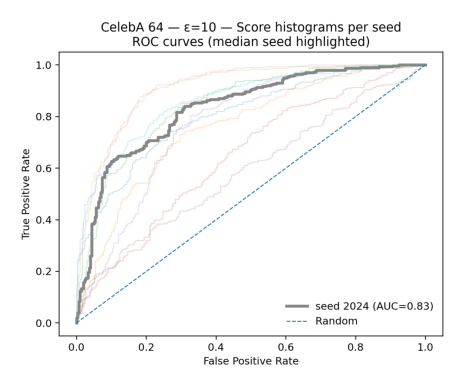

Mean & STD in ROC-AUC Curve


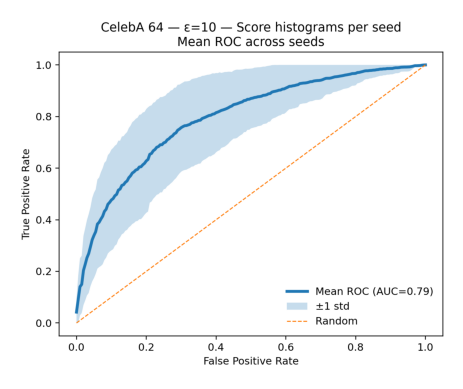

Histogram for different seeds


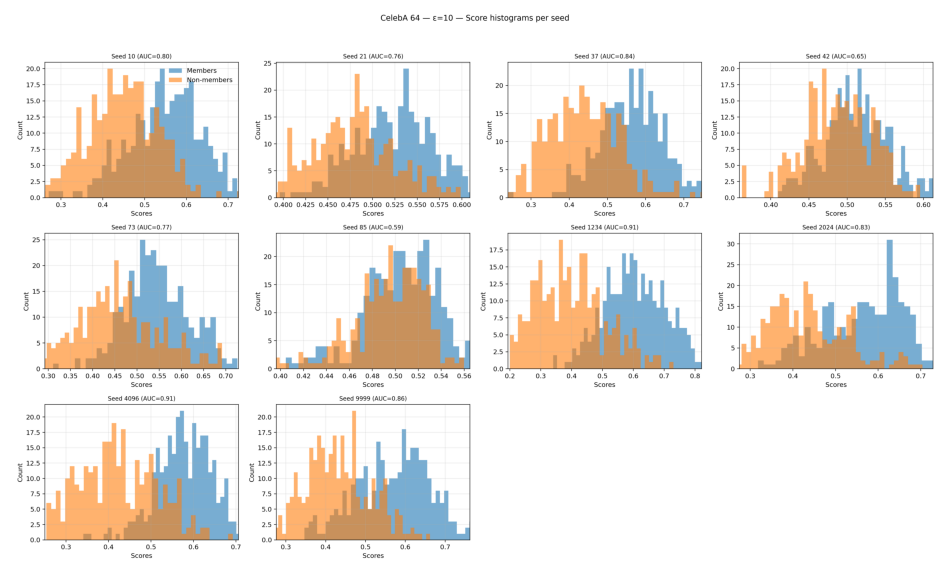

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print("Median in ROC-AUC Curve")
img = mpimg.imread('Celeba64_Eps10_BB_ROC_Curve_overlay.png')
plt.imshow(img)
plt.axis('off')  # Hide axis ticks
plt.show()

print("Mean & STD in ROC-AUC Curve")
img1 = mpimg.imread('Celeba64_Eps10_BB_ROC_Curve_mean.png')
plt.imshow(img1)
plt.axis('off')  # Hide axis ticks
plt.show()

print("Histogram for different seeds")
img2 = mpimg.imread('Celeba64_Eps10_BB_Histogram.png')
plt.figure(figsize=(12, 8))
plt.imshow(img2)
plt.axis('off')  # Hide axis ticks
plt.show()